In [1]:
import re
file_path =  '/Users/ioann/iemocap/IEMOCAP_full_release/Session1/dialog/EmoEvaluation/Ses01F_impro01.txt'
useful_regex = re.compile(r'\[.+\]\n', re.IGNORECASE)
with open(file_path) as f:
    file_content = f.read()
    
info_lines = re.findall(useful_regex, file_content)

In [2]:
import os


info_line = re.compile(r'\[.+\]\n', re.IGNORECASE)

start_times, end_times, wav_file_names, emotions, vals, acts, doms = [], [], [], [], [], [], []

for sess in range(1, 6):
    emo_evaluation_dir = '/Users/ioann/iemocap/IEMOCAP_full_release/Session{}/dialog/EmoEvaluation/'.format(sess)
    evaluation_files = [l for l in os.listdir(emo_evaluation_dir) if 'Ses' in l]
    for file in evaluation_files:
        with open(emo_evaluation_dir + file) as f:
            content = f.read()
        info_lines = re.findall(info_line, content)
        for line in info_lines[1:]:  # the first line is a header
            start_end_time, wav_file_name, emotion, val_act_dom = line.strip().split('\t')
            start_time, end_time = start_end_time[1:-1].split('-')
            val, act, dom = val_act_dom[1:-1].split(',')
            val, act, dom = float(val), float(act), float(dom)
            start_time, end_time = float(start_time), float(end_time)
            start_times.append(start_time)
            end_times.append(end_time)
            wav_file_names.append(wav_file_name)
            emotions.append(emotion)
            vals.append(val)
            acts.append(act)
            doms.append(dom)

In [3]:
import pandas as pd

df_iemocap = pd.DataFrame(columns=['start_time', 'end_time', 'wav_file', 'emotion', 'val', 'act', 'dom'])

df_iemocap['start_time'] = start_times
df_iemocap['end_time'] = end_times
df_iemocap['wav_file'] = wav_file_names
df_iemocap['emotion'] = emotions
df_iemocap['val'] = vals
df_iemocap['act'] = acts
df_iemocap['dom'] = doms

df_iemocap.tail()

,start_time,end_time,wav_file,emotion,val,act,dom
10034,236.57,244.83,Ses05M_script03_2_M041,ang,1.0,4.5,5.0
10035,244.84,246.58,Ses05M_script03_2_M042,ang,1.0,4.5,4.5
10036,246.59,248.83,Ses05M_script03_2_M043,ang,1.5,4.0,4.5
10037,255.86,260.33,Ses05M_script03_2_M044,ang,1.0,5.0,5.0
10038,260.34,266.35,Ses05M_script03_2_M045,ang,1.0,5.0,5.0


In [4]:
#Now that the labels have been extracted, we'll use df_iemocap.csv to split the original wav files into multiple frames
# Try for one file first
import librosa
import os
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as ms
from tqdm import tqdm
import pickle
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from IPython.display import display

import IPython.display
import librosa.display
ms.use('seaborn-muted')
%matplotlib inline

In [5]:
import pandas as pd
import math


labels_df = pd.read_csv('/Users/ioann/df_iemocap.csv')
iemocap_dir = '/Users/ioann/iemocap/IEMOCAP_full_release/'

In [6]:
#build audio vectors
sr = 44100
audio_vectors = {}
for sess in (range(1, 3)): 
    wav_file_path = '{}Session{}/dialog/wav/'.format(iemocap_dir, sess)
    orig_wav_files = os.listdir(wav_file_path)
    for orig_wav_file in tqdm(orig_wav_files):
        try:
            orig_wav_vector, _sr = librosa.load(wav_file_path + orig_wav_file, sr=sr)
            orig_wav_file, file_format = orig_wav_file.split('.')
            for index, row in labels_df[labels_df['wav_file'].str.contains(orig_wav_file)].iterrows():
                start_time, end_time, truncated_wav_file_name, emotion, val, act, dom = row['start_time'], row['end_time'], row['wav_file'], row['emotion'], row['val'], row['act'], row['dom']
                start_frame = math.floor(start_time * sr)
                end_frame = math.floor(end_time * sr)
                truncated_wav_vector = orig_wav_vector[start_frame:end_frame + 1]
                audio_vectors[truncated_wav_file_name] = truncated_wav_vector
        except:
            print('An exception occured for {}'.format(orig_wav_file))
    with open('/Users/ioann/audio_vectors_{}.pkl'.format(sess), 'wb') as f:
        pickle.dump(audio_vectors, f)

 26%|██▌       | 8/31 [01:06<03:02,  7.92s/it]

An exception occured for Ses02F_script01_1.pk


100%|██████████| 31/31 [04:53<00:00, 10.36s/it]


In [7]:
#build audio vectors
sr = 44100
audio_vectors = {}
for sess in (range(3, 5)):  # using one session due to memory constraint, can replace [5] with range(1, 6)
    wav_file_path = '{}Session{}/dialog/wav/'.format(iemocap_dir, sess)
    orig_wav_files = os.listdir(wav_file_path)
    for orig_wav_file in tqdm(orig_wav_files):
        try:
            orig_wav_vector, _sr = librosa.load(wav_file_path + orig_wav_file, sr=sr)
            orig_wav_file, file_format = orig_wav_file.split('.')
            for index, row in labels_df[labels_df['wav_file'].str.contains(orig_wav_file)].iterrows():
                start_time, end_time, truncated_wav_file_name, emotion, val, act, dom = row['start_time'], row['end_time'], row['wav_file'], row['emotion'], row['val'], row['act'], row['dom']
                start_frame = math.floor(start_time * sr)
                end_frame = math.floor(end_time * sr)
                truncated_wav_vector = orig_wav_vector[start_frame:end_frame + 1]
                audio_vectors[truncated_wav_file_name] = truncated_wav_vector
        except:
            print('An exception occured for {}'.format(orig_wav_file))
    with open('/Users/ioann/audio_vectors_{}.pkl'.format(sess), 'wb') as f:
        pickle.dump(audio_vectors, f)

100%|██████████| 30/30 [05:10<00:00, 10.28s/it]


In [8]:
#build audio vectors
sr = 44100
audio_vectors = {}
for sess in [5]:  # using one session due to memory constraint, can replace [5] with range(1, 6)
    wav_file_path = '{}Session{}/dialog/wav/'.format(iemocap_dir, sess)
    orig_wav_files = os.listdir(wav_file_path)
    for orig_wav_file in tqdm(orig_wav_files):
        try:
            orig_wav_vector, _sr = librosa.load(wav_file_path + orig_wav_file, sr=sr)
            orig_wav_file, file_format = orig_wav_file.split('.')
            for index, row in labels_df[labels_df['wav_file'].str.contains(orig_wav_file)].iterrows():
                start_time, end_time, truncated_wav_file_name, emotion, val, act, dom = row['start_time'], row['end_time'], row['wav_file'], row['emotion'], row['val'], row['act'], row['dom']
                start_frame = math.floor(start_time * sr)
                end_frame = math.floor(end_time * sr)
                truncated_wav_vector = orig_wav_vector[start_frame:end_frame + 1]
                audio_vectors[truncated_wav_file_name] = truncated_wav_vector
        except:
            print('An exception occured for {}'.format(orig_wav_file))
    with open('/Users/ioann/audio_vectors_{}.pkl'.format(sess), 'wb') as f:
        pickle.dump(audio_vectors, f)

100%|██████████| 31/31 [05:35<00:00, 11.83s/it]


In [9]:
columns = ['wav_file', 'label', 'feature_mfccs']
df_features = pd.DataFrame(columns=columns)

In [10]:
emotion_dict = {'ang': 0,
                'hap': 1,
                'exc': 1,
                'sad': 2,
                'fru': 0,
                'fea': 2,
                'sur': 1,
                'neu': 3,
                'xxx': 3,
                'oth': 3}

data_dir = '/Users/ioann/'
labels_path = '{}df_iemocap.csv'.format(data_dir)
audio_vectors_path = '{}audio_vectors_'.format(data_dir)

In [11]:
labels_df = pd.read_csv(labels_path)

for sess in (range(1, 6)):
        audio_vectors = pickle.load(open('{}{}.pkl'.format(audio_vectors_path, sess), 'rb'))
        for index, row in tqdm(labels_df[labels_df['wav_file'].str.contains('Ses0{}'.format(sess))].iterrows()):           
            try:
                wav_file_name = row['wav_file']
                label = emotion_dict[row['emotion']]
                y = audio_vectors[wav_file_name]

                feature_list = [wav_file_name, label]  # wav_file, label
                
               # mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
                mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T,axis=0) 

               
                #feature_list.append(np.mean(mfccs))  # rmse_mean
                feature_list.append(mfccs)
               

                

               
                
                df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
            except:
                print('Some exception occured')


767it [00:22, 25.57it/s]

Some exception occured


1819it [00:53, 22.77it/s]
1811it [00:48, 37.12it/s]
1219it [00:31, 35.56it/s]

Some exception occured


2136it [00:56, 37.78it/s]
2103it [01:03, 33.00it/s]
2170it [00:58, 37.38it/s]


In [12]:
df3 = pd.DataFrame(df_features['feature_mfccs'].values.tolist())
df3
new=df_features.drop('feature_mfccs', 1)
new

,wav_file,label
0,Ses01F_impro01_F000,3
1,Ses01F_impro01_F001,3
2,Ses01F_impro01_F002,3
3,Ses01F_impro01_F003,3
4,Ses01F_impro01_F004,3
5,Ses01F_impro01_F005,3
6,Ses01F_impro01_F006,0
7,Ses01F_impro01_F007,0
8,Ses01F_impro01_F008,0
9,Ses01F_impro01_F009,0


In [13]:
newdf = pd.concat([new,df3], axis=1)
newdf

,wav_file,label,0,1,2,3,4,5,6,7,...,30,31,32,33,34,35,36,37,38,39
0,Ses01F_impro01_F000,3,-509.126997,181.965860,-48.599549,31.576114,32.012172,-21.222346,18.036352,4.219425,...,-1.538607,2.361050,1.754320,1.556140,5.038047,2.334538,2.539351,5.077994,1.888022,0.402842
1,Ses01F_impro01_F001,3,-516.757101,166.037926,-13.698110,7.455778,24.127481,-5.943733,8.448324,6.310700,...,-0.200320,-0.469727,-0.599042,-1.689963,-0.042121,2.508860,2.382482,2.270472,0.708341,-1.324735
2,Ses01F_impro01_F002,3,-535.808389,197.637881,-35.971572,16.028582,27.252961,-17.289227,12.078187,6.596235,...,-0.805395,1.045605,0.227568,-0.231600,2.007883,1.608188,2.511622,3.101419,-0.276906,-1.303641
3,Ses01F_impro01_F003,3,-499.505437,173.583604,-26.196286,18.929305,35.394134,-10.336557,5.948212,3.568846,...,-2.648540,0.256012,2.905106,0.806051,1.458800,3.587927,3.186033,1.861609,-0.167564,-0.764474
4,Ses01F_impro01_F004,3,-430.813999,159.862295,-15.155569,11.889576,36.357437,1.025977,0.410147,-2.455916,...,-0.761237,1.874628,3.201370,1.396090,0.352647,0.841803,2.117443,2.855314,1.949633,1.237270
5,Ses01F_impro01_F005,3,-386.503557,153.880057,-8.654504,11.462919,17.005921,-13.288454,3.486613,2.020962,...,-3.797975,1.039531,2.594824,1.138751,2.050575,1.679837,1.086065,1.729483,1.243465,1.516248
6,Ses01F_impro01_F006,0,-338.679136,167.576578,-23.725968,-4.789725,25.580598,-6.741570,-4.581353,2.351062,...,-1.393701,2.189362,2.349536,0.781537,2.358782,3.684598,3.777222,3.235100,1.707252,1.858535
7,Ses01F_impro01_F007,0,-411.708022,166.322311,-27.537525,5.647182,26.333488,-7.406942,5.228053,0.618157,...,-1.476885,0.076237,-0.252111,-0.830246,0.461917,0.633769,0.435840,0.628173,0.029110,-0.212034
8,Ses01F_impro01_F008,0,-364.805749,181.675440,-37.499601,5.804351,33.771206,-14.981616,-6.293604,2.465651,...,-1.283447,0.418868,-1.965341,-3.290352,-0.378126,0.940950,1.865115,1.188642,-0.756106,0.850033
9,Ses01F_impro01_F009,0,-438.489636,160.395622,-24.566140,4.215405,23.486020,-8.647269,5.627794,4.042671,...,-1.455696,-0.133780,-0.066850,-0.594847,0.921930,2.700348,3.346706,1.956133,0.429507,1.637339


In [14]:
def build_ravdess_onesub(file_list):
    
   
    df = { 'actor': [] }
   

    for file in file_list:
        

        props = file.split('_')
        df['actor'].append(props[-1][0])
       

       

    file_properties = pd.DataFrame(df)
    
    return file_properties

In [15]:
wav_list=newdf['wav_file'].values.tolist()
actor_list=build_ravdess_onesub(wav_list)
actor = pd.DataFrame(actor_list)

In [16]:
new_df = pd.concat([newdf, actor], axis=1)

new_df=new_df.fillna(0)
new_df

,wav_file,label,0,1,2,3,4,5,6,7,...,31,32,33,34,35,36,37,38,39,actor
0,Ses01F_impro01_F000,3,-509.126997,181.965860,-48.599549,31.576114,32.012172,-21.222346,18.036352,4.219425,...,2.361050,1.754320,1.556140,5.038047,2.334538,2.539351,5.077994,1.888022,0.402842,F
1,Ses01F_impro01_F001,3,-516.757101,166.037926,-13.698110,7.455778,24.127481,-5.943733,8.448324,6.310700,...,-0.469727,-0.599042,-1.689963,-0.042121,2.508860,2.382482,2.270472,0.708341,-1.324735,F
2,Ses01F_impro01_F002,3,-535.808389,197.637881,-35.971572,16.028582,27.252961,-17.289227,12.078187,6.596235,...,1.045605,0.227568,-0.231600,2.007883,1.608188,2.511622,3.101419,-0.276906,-1.303641,F
3,Ses01F_impro01_F003,3,-499.505437,173.583604,-26.196286,18.929305,35.394134,-10.336557,5.948212,3.568846,...,0.256012,2.905106,0.806051,1.458800,3.587927,3.186033,1.861609,-0.167564,-0.764474,F
4,Ses01F_impro01_F004,3,-430.813999,159.862295,-15.155569,11.889576,36.357437,1.025977,0.410147,-2.455916,...,1.874628,3.201370,1.396090,0.352647,0.841803,2.117443,2.855314,1.949633,1.237270,F
5,Ses01F_impro01_F005,3,-386.503557,153.880057,-8.654504,11.462919,17.005921,-13.288454,3.486613,2.020962,...,1.039531,2.594824,1.138751,2.050575,1.679837,1.086065,1.729483,1.243465,1.516248,F
6,Ses01F_impro01_F006,0,-338.679136,167.576578,-23.725968,-4.789725,25.580598,-6.741570,-4.581353,2.351062,...,2.189362,2.349536,0.781537,2.358782,3.684598,3.777222,3.235100,1.707252,1.858535,F
7,Ses01F_impro01_F007,0,-411.708022,166.322311,-27.537525,5.647182,26.333488,-7.406942,5.228053,0.618157,...,0.076237,-0.252111,-0.830246,0.461917,0.633769,0.435840,0.628173,0.029110,-0.212034,F
8,Ses01F_impro01_F008,0,-364.805749,181.675440,-37.499601,5.804351,33.771206,-14.981616,-6.293604,2.465651,...,0.418868,-1.965341,-3.290352,-0.378126,0.940950,1.865115,1.188642,-0.756106,0.850033,F
9,Ses01F_impro01_F009,0,-438.489636,160.395622,-24.566140,4.215405,23.486020,-8.647269,5.627794,4.042671,...,-0.133780,-0.066850,-0.594847,0.921930,2.700348,3.346706,1.956133,0.429507,1.637339,F


In [17]:
male_df=(new_df.loc[new_df['actor'] != 'F'])

male_df=male_df.fillna(0)
male_df

,wav_file,label,0,1,2,3,4,5,6,7,...,31,32,33,34,35,36,37,38,39,actor
16,Ses01F_impro01_M000,0,-500.868896,189.220418,-39.465266,23.731857,29.020871,-19.606596,14.521496,5.271700,...,0.411655,-1.047636,-1.711674,0.769288,-0.724040,0.779484,2.742180,-1.131312,-1.763866,M
17,Ses01F_impro01_M001,0,-551.920351,190.156384,-31.789207,26.912930,28.437289,-15.544731,19.287128,4.743374,...,1.402052,-0.059979,-1.805427,1.975802,2.110636,2.039491,2.750905,-0.884431,-2.027302,M
18,Ses01F_impro01_M002,0,-453.311027,177.804713,-7.397124,10.015991,23.802517,-6.882265,4.921888,3.716574,...,-1.760344,0.542684,1.309095,1.936453,2.176804,2.111282,1.675785,0.594713,-0.437201,M
19,Ses01F_impro01_M003,0,-403.048533,181.799432,-14.145654,7.708017,32.421439,1.347308,4.017974,-1.762557,...,-2.988795,-0.911225,-3.186680,-3.672203,-3.078186,-2.004483,-0.755949,-2.304451,-2.545736,M
20,Ses01F_impro01_M004,0,-351.990479,171.319116,-22.519727,12.871459,20.564285,-16.718388,4.953248,-0.095530,...,-0.770522,0.812760,-0.571074,1.112561,0.812306,0.702490,2.276348,2.260750,3.238430,M
21,Ses01F_impro01_M005,0,-385.884181,160.783136,-18.526413,11.540446,25.342296,-6.830500,6.591985,1.633257,...,-2.269004,0.867927,-0.293444,0.724103,0.932124,0.697719,2.364543,1.903766,1.400758,M
22,Ses01F_impro01_M006,0,-341.273623,164.841184,-20.418370,1.865021,27.571589,-3.034831,0.829058,2.587804,...,-2.962400,-0.023875,0.128166,0.122750,0.320520,2.275541,3.389964,1.410729,1.216505,M
23,Ses01F_impro01_M007,0,-373.608032,183.271739,-28.118691,1.899592,32.755013,-5.640236,-4.987555,-1.336995,...,-0.866364,-1.520096,-3.218172,-2.242329,-2.705122,-1.147214,-0.217342,-3.589838,-3.865216,M
24,Ses01F_impro01_M008,0,-422.673923,156.481155,0.007827,0.973423,20.740656,-0.008099,-0.660442,2.572434,...,0.129588,1.044892,0.610438,1.411224,2.432421,3.522774,2.919995,0.276803,-0.966494,M
25,Ses01F_impro01_M009,0,-372.405518,147.831702,-13.513593,3.590041,21.687190,-4.453812,0.810892,0.396668,...,-0.611928,0.456740,-0.236500,1.670564,2.432559,2.133772,1.886000,0.019482,-0.261595,M


In [18]:
female_df=(new_df.loc[new_df['actor'] != 'M'])

female_df=female_df.fillna(0)
female_df

,wav_file,label,0,1,2,3,4,5,6,7,...,31,32,33,34,35,36,37,38,39,actor
0,Ses01F_impro01_F000,3,-509.126997,181.965860,-48.599549,31.576114,32.012172,-21.222346,18.036352,4.219425,...,2.361050,1.754320,1.556140,5.038047,2.334538,2.539351,5.077994,1.888022,0.402842,F
1,Ses01F_impro01_F001,3,-516.757101,166.037926,-13.698110,7.455778,24.127481,-5.943733,8.448324,6.310700,...,-0.469727,-0.599042,-1.689963,-0.042121,2.508860,2.382482,2.270472,0.708341,-1.324735,F
2,Ses01F_impro01_F002,3,-535.808389,197.637881,-35.971572,16.028582,27.252961,-17.289227,12.078187,6.596235,...,1.045605,0.227568,-0.231600,2.007883,1.608188,2.511622,3.101419,-0.276906,-1.303641,F
3,Ses01F_impro01_F003,3,-499.505437,173.583604,-26.196286,18.929305,35.394134,-10.336557,5.948212,3.568846,...,0.256012,2.905106,0.806051,1.458800,3.587927,3.186033,1.861609,-0.167564,-0.764474,F
4,Ses01F_impro01_F004,3,-430.813999,159.862295,-15.155569,11.889576,36.357437,1.025977,0.410147,-2.455916,...,1.874628,3.201370,1.396090,0.352647,0.841803,2.117443,2.855314,1.949633,1.237270,F
5,Ses01F_impro01_F005,3,-386.503557,153.880057,-8.654504,11.462919,17.005921,-13.288454,3.486613,2.020962,...,1.039531,2.594824,1.138751,2.050575,1.679837,1.086065,1.729483,1.243465,1.516248,F
6,Ses01F_impro01_F006,0,-338.679136,167.576578,-23.725968,-4.789725,25.580598,-6.741570,-4.581353,2.351062,...,2.189362,2.349536,0.781537,2.358782,3.684598,3.777222,3.235100,1.707252,1.858535,F
7,Ses01F_impro01_F007,0,-411.708022,166.322311,-27.537525,5.647182,26.333488,-7.406942,5.228053,0.618157,...,0.076237,-0.252111,-0.830246,0.461917,0.633769,0.435840,0.628173,0.029110,-0.212034,F
8,Ses01F_impro01_F008,0,-364.805749,181.675440,-37.499601,5.804351,33.771206,-14.981616,-6.293604,2.465651,...,0.418868,-1.965341,-3.290352,-0.378126,0.940950,1.865115,1.188642,-0.756106,0.850033,F
9,Ses01F_impro01_F009,0,-438.489636,160.395622,-24.566140,4.215405,23.486020,-8.647269,5.627794,4.042671,...,-0.133780,-0.066850,-0.594847,0.921930,2.700348,3.346706,1.956133,0.429507,1.637339,F


In [19]:
def build_onesub(file_list):
    
   
    df = { 'session': [] }
   

    for file in file_list:
        

        props = file.split('_')
        df['session'].append(props[0][:-1])
       

       

    file_properties = pd.DataFrame(df)
    
    return file_properties

In [20]:
wav_list=new_df['wav_file'].values.tolist()
session_list=build_onesub(wav_list)
session = pd.DataFrame(session_list)
session

,session
0,Ses01
1,Ses01
2,Ses01
3,Ses01
4,Ses01
5,Ses01
6,Ses01
7,Ses01
8,Ses01
9,Ses01


In [21]:
new_df_ses = pd.concat([newdf, actor, session], axis=1)

new_df_ses=new_df_ses.fillna(0)
new_df_ses

,wav_file,label,0,1,2,3,4,5,6,7,...,32,33,34,35,36,37,38,39,actor,session
0,Ses01F_impro01_F000,3,-509.126997,181.965860,-48.599549,31.576114,32.012172,-21.222346,18.036352,4.219425,...,1.754320,1.556140,5.038047,2.334538,2.539351,5.077994,1.888022,0.402842,F,Ses01
1,Ses01F_impro01_F001,3,-516.757101,166.037926,-13.698110,7.455778,24.127481,-5.943733,8.448324,6.310700,...,-0.599042,-1.689963,-0.042121,2.508860,2.382482,2.270472,0.708341,-1.324735,F,Ses01
2,Ses01F_impro01_F002,3,-535.808389,197.637881,-35.971572,16.028582,27.252961,-17.289227,12.078187,6.596235,...,0.227568,-0.231600,2.007883,1.608188,2.511622,3.101419,-0.276906,-1.303641,F,Ses01
3,Ses01F_impro01_F003,3,-499.505437,173.583604,-26.196286,18.929305,35.394134,-10.336557,5.948212,3.568846,...,2.905106,0.806051,1.458800,3.587927,3.186033,1.861609,-0.167564,-0.764474,F,Ses01
4,Ses01F_impro01_F004,3,-430.813999,159.862295,-15.155569,11.889576,36.357437,1.025977,0.410147,-2.455916,...,3.201370,1.396090,0.352647,0.841803,2.117443,2.855314,1.949633,1.237270,F,Ses01
5,Ses01F_impro01_F005,3,-386.503557,153.880057,-8.654504,11.462919,17.005921,-13.288454,3.486613,2.020962,...,2.594824,1.138751,2.050575,1.679837,1.086065,1.729483,1.243465,1.516248,F,Ses01
6,Ses01F_impro01_F006,0,-338.679136,167.576578,-23.725968,-4.789725,25.580598,-6.741570,-4.581353,2.351062,...,2.349536,0.781537,2.358782,3.684598,3.777222,3.235100,1.707252,1.858535,F,Ses01
7,Ses01F_impro01_F007,0,-411.708022,166.322311,-27.537525,5.647182,26.333488,-7.406942,5.228053,0.618157,...,-0.252111,-0.830246,0.461917,0.633769,0.435840,0.628173,0.029110,-0.212034,F,Ses01
8,Ses01F_impro01_F008,0,-364.805749,181.675440,-37.499601,5.804351,33.771206,-14.981616,-6.293604,2.465651,...,-1.965341,-3.290352,-0.378126,0.940950,1.865115,1.188642,-0.756106,0.850033,F,Ses01
9,Ses01F_impro01_F009,0,-438.489636,160.395622,-24.566140,4.215405,23.486020,-8.647269,5.627794,4.042671,...,-0.066850,-0.594847,0.921930,2.700348,3.346706,1.956133,0.429507,1.637339,F,Ses01


In [22]:
#gia male me ses
male_df_ses=(new_df_ses.loc[new_df['actor'] != 'F'])

male_df_ses=male_df_ses.fillna(0)
male_df_ses

,wav_file,label,0,1,2,3,4,5,6,7,...,32,33,34,35,36,37,38,39,actor,session
16,Ses01F_impro01_M000,0,-500.868896,189.220418,-39.465266,23.731857,29.020871,-19.606596,14.521496,5.271700,...,-1.047636,-1.711674,0.769288,-0.724040,0.779484,2.742180,-1.131312,-1.763866,M,Ses01
17,Ses01F_impro01_M001,0,-551.920351,190.156384,-31.789207,26.912930,28.437289,-15.544731,19.287128,4.743374,...,-0.059979,-1.805427,1.975802,2.110636,2.039491,2.750905,-0.884431,-2.027302,M,Ses01
18,Ses01F_impro01_M002,0,-453.311027,177.804713,-7.397124,10.015991,23.802517,-6.882265,4.921888,3.716574,...,0.542684,1.309095,1.936453,2.176804,2.111282,1.675785,0.594713,-0.437201,M,Ses01
19,Ses01F_impro01_M003,0,-403.048533,181.799432,-14.145654,7.708017,32.421439,1.347308,4.017974,-1.762557,...,-0.911225,-3.186680,-3.672203,-3.078186,-2.004483,-0.755949,-2.304451,-2.545736,M,Ses01
20,Ses01F_impro01_M004,0,-351.990479,171.319116,-22.519727,12.871459,20.564285,-16.718388,4.953248,-0.095530,...,0.812760,-0.571074,1.112561,0.812306,0.702490,2.276348,2.260750,3.238430,M,Ses01
21,Ses01F_impro01_M005,0,-385.884181,160.783136,-18.526413,11.540446,25.342296,-6.830500,6.591985,1.633257,...,0.867927,-0.293444,0.724103,0.932124,0.697719,2.364543,1.903766,1.400758,M,Ses01
22,Ses01F_impro01_M006,0,-341.273623,164.841184,-20.418370,1.865021,27.571589,-3.034831,0.829058,2.587804,...,-0.023875,0.128166,0.122750,0.320520,2.275541,3.389964,1.410729,1.216505,M,Ses01
23,Ses01F_impro01_M007,0,-373.608032,183.271739,-28.118691,1.899592,32.755013,-5.640236,-4.987555,-1.336995,...,-1.520096,-3.218172,-2.242329,-2.705122,-1.147214,-0.217342,-3.589838,-3.865216,M,Ses01
24,Ses01F_impro01_M008,0,-422.673923,156.481155,0.007827,0.973423,20.740656,-0.008099,-0.660442,2.572434,...,1.044892,0.610438,1.411224,2.432421,3.522774,2.919995,0.276803,-0.966494,M,Ses01
25,Ses01F_impro01_M009,0,-372.405518,147.831702,-13.513593,3.590041,21.687190,-4.453812,0.810892,0.396668,...,0.456740,-0.236500,1.670564,2.432559,2.133772,1.886000,0.019482,-0.261595,M,Ses01


In [23]:
#gia female me ses
female_df_ses=(new_df_ses.loc[new_df['actor'] != 'M'])

female_df_ses=female_df_ses.fillna(0)
female_df_ses


,wav_file,label,0,1,2,3,4,5,6,7,...,32,33,34,35,36,37,38,39,actor,session
0,Ses01F_impro01_F000,3,-509.126997,181.965860,-48.599549,31.576114,32.012172,-21.222346,18.036352,4.219425,...,1.754320,1.556140,5.038047,2.334538,2.539351,5.077994,1.888022,0.402842,F,Ses01
1,Ses01F_impro01_F001,3,-516.757101,166.037926,-13.698110,7.455778,24.127481,-5.943733,8.448324,6.310700,...,-0.599042,-1.689963,-0.042121,2.508860,2.382482,2.270472,0.708341,-1.324735,F,Ses01
2,Ses01F_impro01_F002,3,-535.808389,197.637881,-35.971572,16.028582,27.252961,-17.289227,12.078187,6.596235,...,0.227568,-0.231600,2.007883,1.608188,2.511622,3.101419,-0.276906,-1.303641,F,Ses01
3,Ses01F_impro01_F003,3,-499.505437,173.583604,-26.196286,18.929305,35.394134,-10.336557,5.948212,3.568846,...,2.905106,0.806051,1.458800,3.587927,3.186033,1.861609,-0.167564,-0.764474,F,Ses01
4,Ses01F_impro01_F004,3,-430.813999,159.862295,-15.155569,11.889576,36.357437,1.025977,0.410147,-2.455916,...,3.201370,1.396090,0.352647,0.841803,2.117443,2.855314,1.949633,1.237270,F,Ses01
5,Ses01F_impro01_F005,3,-386.503557,153.880057,-8.654504,11.462919,17.005921,-13.288454,3.486613,2.020962,...,2.594824,1.138751,2.050575,1.679837,1.086065,1.729483,1.243465,1.516248,F,Ses01
6,Ses01F_impro01_F006,0,-338.679136,167.576578,-23.725968,-4.789725,25.580598,-6.741570,-4.581353,2.351062,...,2.349536,0.781537,2.358782,3.684598,3.777222,3.235100,1.707252,1.858535,F,Ses01
7,Ses01F_impro01_F007,0,-411.708022,166.322311,-27.537525,5.647182,26.333488,-7.406942,5.228053,0.618157,...,-0.252111,-0.830246,0.461917,0.633769,0.435840,0.628173,0.029110,-0.212034,F,Ses01
8,Ses01F_impro01_F008,0,-364.805749,181.675440,-37.499601,5.804351,33.771206,-14.981616,-6.293604,2.465651,...,-1.965341,-3.290352,-0.378126,0.940950,1.865115,1.188642,-0.756106,0.850033,F,Ses01
9,Ses01F_impro01_F009,0,-438.489636,160.395622,-24.566140,4.215405,23.486020,-8.647269,5.627794,4.042671,...,-0.066850,-0.594847,0.921930,2.700348,3.346706,1.956133,0.429507,1.637339,F,Ses01


In [24]:
#ta sessios jexorista
session1=(new_df_ses.loc[new_df_ses['session'] == 'Ses01'])
session2=(new_df_ses.loc[new_df_ses['session'] == 'Ses02'])
session3=(new_df_ses.loc[new_df_ses['session'] == 'Ses03'])
session4=(new_df_ses.loc[new_df_ses['session'] == 'Ses04'])
session5=(new_df_ses.loc[new_df_ses['session'] == 'Ses05'])

In [237]:
#test set
test=(female_df_ses.loc[female_df_ses['session'] == 'Ses05'])

test=test.fillna(0)
test


,wav_file,label,0,1,2,3,4,5,6,7,...,32,33,34,35,36,37,38,39,actor,session
7867,Ses05F_impro01_F000,3,-585.852802,198.867099,-35.402785,25.608204,31.915689,-20.628153,12.542390,7.062307,...,-0.725490,-2.759125,0.132562,0.770999,0.737975,1.642577,-0.123987,0.143570,F,Ses05
7868,Ses05F_impro01_F001,0,-533.893890,188.525680,-12.882806,12.114414,26.861663,-7.700467,8.306076,3.648815,...,-1.353904,-2.393861,-0.037116,1.299204,0.635383,1.620514,2.629586,1.268480,F,Ses05
7869,Ses05F_impro01_F002,0,-530.920623,189.495789,-20.643350,12.406362,28.736482,-13.490322,5.215672,6.015763,...,0.202706,-1.041471,2.395469,5.481087,4.341295,2.807534,2.421824,0.085479,F,Ses05
7870,Ses05F_impro01_F003,0,-532.522069,187.812399,-14.155742,14.979636,34.069731,-10.316361,0.391044,3.150193,...,3.512778,0.711750,1.545054,2.229873,-0.202369,-0.882060,0.445256,0.019209,F,Ses05
7871,Ses05F_impro01_F004,0,-459.823822,185.527681,-40.886769,28.305041,37.132338,-23.203142,5.151591,3.610659,...,5.092653,2.399904,3.708929,4.725662,4.652699,5.132569,4.557204,4.173012,F,Ses05
7872,Ses05F_impro01_F005,0,-428.617653,208.443979,-33.827115,10.761690,27.972914,-25.215471,-1.949873,3.694628,...,0.947340,-1.150100,-0.164499,1.421523,0.613617,-0.720976,-2.605340,-3.027388,F,Ses05
7873,Ses05F_impro01_F006,0,-455.309703,177.457854,-27.271942,6.219689,29.569399,-17.049014,-3.581623,6.416520,...,1.989035,1.970364,3.527211,4.056161,3.406622,3.236684,2.701955,1.629213,F,Ses05
7874,Ses05F_impro01_F007,0,-486.144134,180.223827,-23.857040,5.591753,27.781481,-16.763066,-3.466697,5.502682,...,2.416606,1.979190,2.500062,2.724847,3.021664,3.665444,3.581198,3.523417,F,Ses05
7875,Ses05F_impro01_F008,3,-476.238778,186.939744,-34.736982,14.157448,30.816447,-23.685803,0.009929,5.585601,...,1.988673,1.102847,3.165118,4.094647,5.370751,8.120942,6.835108,3.817647,F,Ses05
7876,Ses05F_impro01_F009,0,-548.998456,173.222571,-18.048247,10.106872,22.354704,-14.788894,6.136228,8.086484,...,4.913514,3.483173,3.690874,4.197776,4.329406,5.085555,4.174868,1.383461,F,Ses05


In [238]:
#train set
session5_female=(female_df_ses.loc[female_df_ses['session'] == 'Ses05'])

session5_male=(male_df_ses.loc[male_df_ses['session'] == 'Ses05'])
session4_female=(female_df_ses.loc[female_df_ses['session'] == 'Ses04'])

session4_male=(male_df_ses.loc[male_df_ses['session'] == 'Ses04'])
session3_female=(female_df_ses.loc[female_df_ses['session'] == 'Ses03'])

session3_male=(male_df_ses.loc[male_df_ses['session'] == 'Ses03'])
session2_female=(female_df_ses.loc[female_df_ses['session'] == 'Ses02'])

session2_male=(male_df_ses.loc[male_df_ses['session'] == 'Ses02'])
session1_female=(female_df_ses.loc[female_df_ses['session'] == 'Ses01'])

session1_male=(male_df_ses.loc[male_df_ses['session'] == 'Ses01'])


In [239]:
train = pd.concat([session3 ,session5_male ,session4 ,session2,session1], axis=0)

train=train.fillna(0)
train

,wav_file,label,0,1,2,3,4,5,6,7,...,32,33,34,35,36,37,38,39,actor,session
3629,Ses03F_impro01_F000,3,-487.908952,171.299201,-49.420560,-7.710047,22.014007,-15.527215,3.559150,7.195682,...,3.987260,2.139599,4.290557,4.147698,3.148018,4.199734,3.817483,3.422592,F,Ses03
3630,Ses03F_impro01_F001,3,-568.153066,191.533968,-46.290784,9.338268,21.947019,-16.526939,18.230053,9.205195,...,2.629194,1.734220,3.947117,2.251207,2.989081,2.532742,-1.532419,-0.530029,F,Ses03
3631,Ses03F_impro01_F002,3,-652.815521,193.574241,-16.224658,14.510835,21.766940,-14.908387,14.087528,14.232708,...,4.611889,2.399714,2.402479,5.203794,4.632854,3.002575,1.468721,-1.040257,F,Ses03
3632,Ses03F_impro01_F003,0,-483.411616,168.530454,-40.192908,12.452698,29.454969,-24.485880,-4.510416,4.273712,...,2.245109,0.149047,2.399115,3.034765,2.050127,3.266782,2.318137,0.204523,F,Ses03
3633,Ses03F_impro01_F004,0,-548.796499,156.973741,-15.489600,7.613593,19.313668,-16.255719,-0.133125,6.857087,...,0.251747,-0.909827,0.383243,2.198411,3.455754,3.146209,2.438067,2.751034,F,Ses03
3634,Ses03F_impro01_F005,0,-444.450925,166.239112,-45.639215,-9.475188,20.988813,-26.087929,-16.465395,1.600998,...,2.365135,-1.323090,-0.698251,-1.742186,-2.676289,0.101502,1.923848,1.402902,F,Ses03
3635,Ses03F_impro01_F006,0,-475.066976,164.704756,-51.083694,6.014806,27.122535,-25.437174,-5.566767,2.827652,...,5.028642,4.126940,4.738491,1.042243,-0.530116,0.548506,0.200898,0.616515,F,Ses03
3636,Ses03F_impro01_F007,0,-442.507758,158.629222,-34.655729,-8.745709,18.205818,-12.396355,-5.004748,-2.747985,...,-0.791711,0.034398,3.087654,1.443263,1.032133,2.031383,-0.648796,-1.434306,F,Ses03
3637,Ses03F_impro01_F008,0,-473.022530,193.563019,-40.119641,9.297527,31.710927,-14.189763,6.042544,7.043348,...,-6.969887,-4.304376,0.296378,-1.965350,-3.306724,-4.377804,-9.464512,-7.057574,F,Ses03
3638,Ses03F_impro01_F009,0,-489.581381,178.726806,-45.390527,3.876106,27.505155,-20.364995,-2.678592,2.930537,...,7.377019,5.882534,6.833331,5.177469,3.566726,3.696503,2.289944,1.077090,F,Ses03


In [240]:
trainlabel=train.iloc[:,1:2]
trainfeatures = train.iloc[: ,2:-2]
testfeatures = test.iloc[:, 2:-2]
testlabel=test.iloc[:, 1:2]

In [241]:
X_train = np.array(trainfeatures)
y_train = np.array(trainlabel)
X_test = np.array(testfeatures)
y_test = np.array(testlabel)

In [242]:
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder



lb = LabelEncoder()

y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

C:\Users\ioann\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [243]:
#for cnn
x_traincnn =np.expand_dims(X_train, axis=2)
x_testcnn= np.expand_dims(X_test, axis=2)

In [244]:
import numpy as np
import keras
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
model = Sequential()



model.add(Conv1D(256, 5,padding='same',
                 input_shape=(40,1)))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
#model.add(Conv1D(128, 5,padding='same',))
#model.add(Activation('relu'))
#model.add(Conv1D(128, 5,padding='same',))
#model.add(Activation('relu'))
#model.add(Dropout(0.2))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(4))
model.add(Activation('softmax'))
opt = keras.optimizers.rmsprop(lr=0.00001, decay=1e-6)

In [245]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_33 (Conv1D)           (None, 40, 256)           1536      
_________________________________________________________________
activation_41 (Activation)   (None, 40, 256)           0         
_________________________________________________________________
conv1d_34 (Conv1D)           (None, 40, 128)           163968    
_________________________________________________________________
activation_42 (Activation)   (None, 40, 128)           0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 40, 128)           0         
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 5, 128)            0         
_________________________________________________________________
conv1d_35 (Conv1D)           (None, 5, 128)           

In [246]:
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

In [247]:
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=400, validation_data=(x_testcnn, y_test))

Train on 9004 samples, validate on 1033 samples
Epoch 1/400
9004/9004 [==============================] - ETA: 2:41 - loss: 1.7875 - accuracy: 0.43 - ETA: 27s - loss: 2.4040 - accuracy: 0.3750 - ETA: 14s - loss: 1.8917 - accuracy: 0.412 - ETA: 10s - loss: 1.7624 - accuracy: 0.399 - ETA: 8s - loss: 1.6883 - accuracy: 0.383 - ETA: 7s - loss: 1.6555 - accuracy: 0.37 - ETA: 6s - loss: 1.6251 - accuracy: 0.36 - ETA: 6s - loss: 1.6189 - accuracy: 0.35 - ETA: 5s - loss: 1.6052 - accuracy: 0.35 - ETA: 5s - loss: 1.5832 - accuracy: 0.35 - ETA: 5s - loss: 1.5804 - accuracy: 0.35 - ETA: 4s - loss: 1.5692 - accuracy: 0.35 - ETA: 4s - loss: 1.5492 - accuracy: 0.35 - ETA: 4s - loss: 1.5426 - accuracy: 0.35 - ETA: 4s - loss: 1.5306 - accuracy: 0.36 - ETA: 4s - loss: 1.5244 - accuracy: 0.36 - ETA: 4s - loss: 1.5169 - accuracy: 0.36 - ETA: 3s - loss: 1.5042 - accuracy: 0.36 - ETA: 3s - loss: 1.4954 - accuracy: 0.36 - ETA: 3s - loss: 1.4887 - accuracy: 0.36 - ETA: 3s - loss: 1.4775 - accuracy: 0.37 - ETA

9004/9004 [==============================] - ETA: 3s - loss: 1.1657 - accuracy: 0.50 - ETA: 3s - loss: 1.2176 - accuracy: 0.44 - ETA: 3s - loss: 1.1998 - accuracy: 0.43 - ETA: 3s - loss: 1.1808 - accuracy: 0.44 - ETA: 3s - loss: 1.1824 - accuracy: 0.44 - ETA: 3s - loss: 1.1785 - accuracy: 0.45 - ETA: 3s - loss: 1.1742 - accuracy: 0.45 - ETA: 3s - loss: 1.1827 - accuracy: 0.43 - ETA: 3s - loss: 1.1805 - accuracy: 0.45 - ETA: 3s - loss: 1.1788 - accuracy: 0.45 - ETA: 3s - loss: 1.1755 - accuracy: 0.45 - ETA: 3s - loss: 1.1728 - accuracy: 0.45 - ETA: 3s - loss: 1.1764 - accuracy: 0.44 - ETA: 3s - loss: 1.1730 - accuracy: 0.44 - ETA: 3s - loss: 1.1766 - accuracy: 0.43 - ETA: 2s - loss: 1.1764 - accuracy: 0.44 - ETA: 2s - loss: 1.1775 - accuracy: 0.44 - ETA: 2s - loss: 1.1813 - accuracy: 0.43 - ETA: 2s - loss: 1.1834 - accuracy: 0.43 - ETA: 2s - loss: 1.1817 - accuracy: 0.44 - ETA: 2s - loss: 1.1839 - accuracy: 0.44 - ETA: 2s - loss: 1.1844 - accuracy: 0.44 - ETA: 2s - loss: 1.1847 - accura

9004/9004 [==============================] - ETA: 3s - loss: 1.1692 - accuracy: 0.37 - ETA: 3s - loss: 1.1750 - accuracy: 0.40 - ETA: 3s - loss: 1.1301 - accuracy: 0.48 - ETA: 3s - loss: 1.1303 - accuracy: 0.47 - ETA: 3s - loss: 1.1373 - accuracy: 0.47 - ETA: 3s - loss: 1.1407 - accuracy: 0.46 - ETA: 3s - loss: 1.1491 - accuracy: 0.46 - ETA: 3s - loss: 1.1570 - accuracy: 0.45 - ETA: 3s - loss: 1.1598 - accuracy: 0.45 - ETA: 3s - loss: 1.1621 - accuracy: 0.45 - ETA: 3s - loss: 1.1578 - accuracy: 0.45 - ETA: 3s - loss: 1.1581 - accuracy: 0.45 - ETA: 3s - loss: 1.1543 - accuracy: 0.45 - ETA: 3s - loss: 1.1501 - accuracy: 0.45 - ETA: 3s - loss: 1.1553 - accuracy: 0.45 - ETA: 2s - loss: 1.1468 - accuracy: 0.46 - ETA: 2s - loss: 1.1511 - accuracy: 0.45 - ETA: 2s - loss: 1.1502 - accuracy: 0.45 - ETA: 2s - loss: 1.1481 - accuracy: 0.45 - ETA: 2s - loss: 1.1500 - accuracy: 0.45 - ETA: 2s - loss: 1.1495 - accuracy: 0.45 - ETA: 2s - loss: 1.1535 - accuracy: 0.45 - ETA: 2s - loss: 1.1561 - accura

9004/9004 [==============================] - ETA: 3s - loss: 1.2043 - accuracy: 0.25 - ETA: 3s - loss: 1.1610 - accuracy: 0.43 - ETA: 3s - loss: 1.1541 - accuracy: 0.45 - ETA: 3s - loss: 1.1577 - accuracy: 0.45 - ETA: 3s - loss: 1.1641 - accuracy: 0.44 - ETA: 3s - loss: 1.1686 - accuracy: 0.45 - ETA: 3s - loss: 1.1760 - accuracy: 0.45 - ETA: 3s - loss: 1.1755 - accuracy: 0.45 - ETA: 3s - loss: 1.1672 - accuracy: 0.45 - ETA: 3s - loss: 1.1605 - accuracy: 0.46 - ETA: 3s - loss: 1.1611 - accuracy: 0.45 - ETA: 3s - loss: 1.1589 - accuracy: 0.45 - ETA: 3s - loss: 1.1554 - accuracy: 0.46 - ETA: 3s - loss: 1.1546 - accuracy: 0.46 - ETA: 3s - loss: 1.1483 - accuracy: 0.46 - ETA: 2s - loss: 1.1409 - accuracy: 0.46 - ETA: 2s - loss: 1.1426 - accuracy: 0.46 - ETA: 2s - loss: 1.1423 - accuracy: 0.46 - ETA: 2s - loss: 1.1466 - accuracy: 0.46 - ETA: 2s - loss: 1.1469 - accuracy: 0.46 - ETA: 2s - loss: 1.1479 - accuracy: 0.46 - ETA: 2s - loss: 1.1475 - accuracy: 0.46 - ETA: 2s - loss: 1.1506 - accura

9004/9004 [==============================] - ETA: 3s - loss: 1.3157 - accuracy: 0.18 - ETA: 3s - loss: 1.1708 - accuracy: 0.42 - ETA: 3s - loss: 1.1374 - accuracy: 0.45 - ETA: 3s - loss: 1.1295 - accuracy: 0.45 - ETA: 3s - loss: 1.1370 - accuracy: 0.45 - ETA: 3s - loss: 1.1538 - accuracy: 0.43 - ETA: 3s - loss: 1.1582 - accuracy: 0.44 - ETA: 3s - loss: 1.1481 - accuracy: 0.46 - ETA: 3s - loss: 1.1394 - accuracy: 0.46 - ETA: 3s - loss: 1.1338 - accuracy: 0.47 - ETA: 3s - loss: 1.1325 - accuracy: 0.47 - ETA: 3s - loss: 1.1290 - accuracy: 0.47 - ETA: 3s - loss: 1.1321 - accuracy: 0.47 - ETA: 3s - loss: 1.1411 - accuracy: 0.46 - ETA: 3s - loss: 1.1499 - accuracy: 0.45 - ETA: 2s - loss: 1.1489 - accuracy: 0.46 - ETA: 2s - loss: 1.1470 - accuracy: 0.46 - ETA: 2s - loss: 1.1430 - accuracy: 0.46 - ETA: 2s - loss: 1.1434 - accuracy: 0.46 - ETA: 2s - loss: 1.1454 - accuracy: 0.46 - ETA: 2s - loss: 1.1459 - accuracy: 0.46 - ETA: 2s - loss: 1.1403 - accuracy: 0.46 - ETA: 2s - loss: 1.1391 - accura

9004/9004 [==============================] - ETA: 3s - loss: 1.2386 - accuracy: 0.37 - ETA: 3s - loss: 1.1720 - accuracy: 0.47 - ETA: 3s - loss: 1.1056 - accuracy: 0.51 - ETA: 3s - loss: 1.1094 - accuracy: 0.51 - ETA: 3s - loss: 1.0948 - accuracy: 0.50 - ETA: 3s - loss: 1.1022 - accuracy: 0.50 - ETA: 3s - loss: 1.1004 - accuracy: 0.50 - ETA: 3s - loss: 1.0994 - accuracy: 0.51 - ETA: 3s - loss: 1.0962 - accuracy: 0.52 - ETA: 3s - loss: 1.0976 - accuracy: 0.51 - ETA: 3s - loss: 1.1054 - accuracy: 0.50 - ETA: 3s - loss: 1.1056 - accuracy: 0.50 - ETA: 3s - loss: 1.1069 - accuracy: 0.50 - ETA: 3s - loss: 1.1034 - accuracy: 0.50 - ETA: 3s - loss: 1.1084 - accuracy: 0.49 - ETA: 2s - loss: 1.1103 - accuracy: 0.49 - ETA: 2s - loss: 1.1086 - accuracy: 0.49 - ETA: 2s - loss: 1.1058 - accuracy: 0.49 - ETA: 2s - loss: 1.1045 - accuracy: 0.49 - ETA: 2s - loss: 1.1060 - accuracy: 0.49 - ETA: 2s - loss: 1.1077 - accuracy: 0.49 - ETA: 2s - loss: 1.1046 - accuracy: 0.49 - ETA: 2s - loss: 1.1049 - accura

9004/9004 [==============================] - ETA: 3s - loss: 1.4173 - accuracy: 0.18 - ETA: 3s - loss: 1.1349 - accuracy: 0.48 - ETA: 3s - loss: 1.0875 - accuracy: 0.53 - ETA: 3s - loss: 1.1093 - accuracy: 0.51 - ETA: 3s - loss: 1.1114 - accuracy: 0.51 - ETA: 3s - loss: 1.1061 - accuracy: 0.51 - ETA: 3s - loss: 1.1092 - accuracy: 0.51 - ETA: 3s - loss: 1.1181 - accuracy: 0.50 - ETA: 3s - loss: 1.1244 - accuracy: 0.50 - ETA: 3s - loss: 1.1236 - accuracy: 0.50 - ETA: 3s - loss: 1.1200 - accuracy: 0.49 - ETA: 3s - loss: 1.1187 - accuracy: 0.50 - ETA: 3s - loss: 1.1237 - accuracy: 0.50 - ETA: 3s - loss: 1.1245 - accuracy: 0.50 - ETA: 3s - loss: 1.1258 - accuracy: 0.49 - ETA: 2s - loss: 1.1270 - accuracy: 0.49 - ETA: 2s - loss: 1.1237 - accuracy: 0.50 - ETA: 2s - loss: 1.1223 - accuracy: 0.49 - ETA: 2s - loss: 1.1236 - accuracy: 0.50 - ETA: 2s - loss: 1.1235 - accuracy: 0.50 - ETA: 2s - loss: 1.1216 - accuracy: 0.50 - ETA: 2s - loss: 1.1236 - accuracy: 0.49 - ETA: 2s - loss: 1.1261 - accura

9004/9004 [==============================] - ETA: 3s - loss: 1.1816 - accuracy: 0.37 - ETA: 3s - loss: 1.1547 - accuracy: 0.47 - ETA: 3s - loss: 1.1671 - accuracy: 0.47 - ETA: 3s - loss: 1.1186 - accuracy: 0.50 - ETA: 3s - loss: 1.1367 - accuracy: 0.48 - ETA: 3s - loss: 1.1251 - accuracy: 0.49 - ETA: 3s - loss: 1.1149 - accuracy: 0.49 - ETA: 3s - loss: 1.1171 - accuracy: 0.49 - ETA: 3s - loss: 1.1168 - accuracy: 0.49 - ETA: 3s - loss: 1.1137 - accuracy: 0.48 - ETA: 3s - loss: 1.1189 - accuracy: 0.48 - ETA: 3s - loss: 1.1160 - accuracy: 0.49 - ETA: 3s - loss: 1.1230 - accuracy: 0.48 - ETA: 3s - loss: 1.1212 - accuracy: 0.48 - ETA: 2s - loss: 1.1202 - accuracy: 0.48 - ETA: 2s - loss: 1.1250 - accuracy: 0.47 - ETA: 2s - loss: 1.1271 - accuracy: 0.47 - ETA: 2s - loss: 1.1268 - accuracy: 0.47 - ETA: 2s - loss: 1.1298 - accuracy: 0.47 - ETA: 2s - loss: 1.1324 - accuracy: 0.47 - ETA: 2s - loss: 1.1344 - accuracy: 0.46 - ETA: 2s - loss: 1.1337 - accuracy: 0.47 - ETA: 2s - loss: 1.1274 - accura

9004/9004 [==============================] - ETA: 3s - loss: 1.0637 - accuracy: 0.43 - ETA: 3s - loss: 1.1284 - accuracy: 0.45 - ETA: 3s - loss: 1.0963 - accuracy: 0.47 - ETA: 3s - loss: 1.1146 - accuracy: 0.46 - ETA: 3s - loss: 1.1021 - accuracy: 0.46 - ETA: 3s - loss: 1.1093 - accuracy: 0.46 - ETA: 3s - loss: 1.1161 - accuracy: 0.45 - ETA: 3s - loss: 1.1170 - accuracy: 0.46 - ETA: 3s - loss: 1.1223 - accuracy: 0.46 - ETA: 3s - loss: 1.1194 - accuracy: 0.47 - ETA: 3s - loss: 1.1254 - accuracy: 0.47 - ETA: 3s - loss: 1.1242 - accuracy: 0.47 - ETA: 3s - loss: 1.1255 - accuracy: 0.46 - ETA: 3s - loss: 1.1244 - accuracy: 0.47 - ETA: 2s - loss: 1.1210 - accuracy: 0.47 - ETA: 2s - loss: 1.1237 - accuracy: 0.47 - ETA: 2s - loss: 1.1279 - accuracy: 0.47 - ETA: 2s - loss: 1.1271 - accuracy: 0.47 - ETA: 2s - loss: 1.1255 - accuracy: 0.48 - ETA: 2s - loss: 1.1245 - accuracy: 0.48 - ETA: 2s - loss: 1.1269 - accuracy: 0.48 - ETA: 2s - loss: 1.1275 - accuracy: 0.48 - ETA: 2s - loss: 1.1248 - accura

9004/9004 [==============================] - ETA: 3s - loss: 0.9943 - accuracy: 0.62 - ETA: 3s - loss: 1.1714 - accuracy: 0.47 - ETA: 3s - loss: 1.1573 - accuracy: 0.44 - ETA: 3s - loss: 1.1486 - accuracy: 0.46 - ETA: 6s - loss: 1.1453 - accuracy: 0.46 - ETA: 5s - loss: 1.1388 - accuracy: 0.48 - ETA: 5s - loss: 1.1221 - accuracy: 0.49 - ETA: 4s - loss: 1.1253 - accuracy: 0.48 - ETA: 4s - loss: 1.1163 - accuracy: 0.48 - ETA: 4s - loss: 1.1174 - accuracy: 0.48 - ETA: 4s - loss: 1.1286 - accuracy: 0.47 - ETA: 4s - loss: 1.1280 - accuracy: 0.47 - ETA: 3s - loss: 1.1252 - accuracy: 0.48 - ETA: 3s - loss: 1.1274 - accuracy: 0.48 - ETA: 3s - loss: 1.1197 - accuracy: 0.48 - ETA: 3s - loss: 1.1214 - accuracy: 0.47 - ETA: 3s - loss: 1.1189 - accuracy: 0.48 - ETA: 3s - loss: 1.1185 - accuracy: 0.47 - ETA: 3s - loss: 1.1199 - accuracy: 0.47 - ETA: 3s - loss: 1.1200 - accuracy: 0.47 - ETA: 3s - loss: 1.1124 - accuracy: 0.48 - ETA: 3s - loss: 1.1115 - accuracy: 0.48 - ETA: 2s - loss: 1.1114 - accura

9004/9004 [==============================] - ETA: 3s - loss: 1.0100 - accuracy: 0.56 - ETA: 3s - loss: 1.0763 - accuracy: 0.50 - ETA: 3s - loss: 1.0770 - accuracy: 0.51 - ETA: 3s - loss: 1.0687 - accuracy: 0.51 - ETA: 3s - loss: 1.0727 - accuracy: 0.51 - ETA: 3s - loss: 1.1011 - accuracy: 0.50 - ETA: 3s - loss: 1.0974 - accuracy: 0.50 - ETA: 3s - loss: 1.0894 - accuracy: 0.50 - ETA: 3s - loss: 1.0858 - accuracy: 0.51 - ETA: 3s - loss: 1.0942 - accuracy: 0.51 - ETA: 3s - loss: 1.0937 - accuracy: 0.51 - ETA: 3s - loss: 1.0960 - accuracy: 0.50 - ETA: 3s - loss: 1.0972 - accuracy: 0.50 - ETA: 3s - loss: 1.1016 - accuracy: 0.50 - ETA: 3s - loss: 1.0993 - accuracy: 0.50 - ETA: 2s - loss: 1.0974 - accuracy: 0.50 - ETA: 2s - loss: 1.1005 - accuracy: 0.50 - ETA: 2s - loss: 1.1014 - accuracy: 0.50 - ETA: 2s - loss: 1.0958 - accuracy: 0.50 - ETA: 2s - loss: 1.0966 - accuracy: 0.50 - ETA: 2s - loss: 1.0981 - accuracy: 0.49 - ETA: 2s - loss: 1.0991 - accuracy: 0.49 - ETA: 2s - loss: 1.0985 - accura

9004/9004 [==============================] - ETA: 3s - loss: 1.1190 - accuracy: 0.62 - ETA: 3s - loss: 1.1475 - accuracy: 0.45 - ETA: 3s - loss: 1.1364 - accuracy: 0.46 - ETA: 3s - loss: 1.1316 - accuracy: 0.46 - ETA: 3s - loss: 1.1345 - accuracy: 0.47 - ETA: 3s - loss: 1.1128 - accuracy: 0.48 - ETA: 3s - loss: 1.0908 - accuracy: 0.50 - ETA: 3s - loss: 1.0960 - accuracy: 0.50 - ETA: 3s - loss: 1.0976 - accuracy: 0.50 - ETA: 3s - loss: 1.0969 - accuracy: 0.50 - ETA: 3s - loss: 1.0932 - accuracy: 0.50 - ETA: 3s - loss: 1.0935 - accuracy: 0.51 - ETA: 3s - loss: 1.0913 - accuracy: 0.50 - ETA: 3s - loss: 1.0916 - accuracy: 0.50 - ETA: 2s - loss: 1.0856 - accuracy: 0.51 - ETA: 2s - loss: 1.0881 - accuracy: 0.51 - ETA: 2s - loss: 1.0863 - accuracy: 0.51 - ETA: 2s - loss: 1.0854 - accuracy: 0.51 - ETA: 2s - loss: 1.0869 - accuracy: 0.51 - ETA: 2s - loss: 1.0841 - accuracy: 0.51 - ETA: 2s - loss: 1.0863 - accuracy: 0.50 - ETA: 2s - loss: 1.0866 - accuracy: 0.50 - ETA: 2s - loss: 1.0887 - accura

9004/9004 [==============================] - ETA: 4s - loss: 1.2513 - accuracy: 0.56 - ETA: 3s - loss: 1.1055 - accuracy: 0.47 - ETA: 3s - loss: 1.0992 - accuracy: 0.48 - ETA: 3s - loss: 1.0935 - accuracy: 0.51 - ETA: 3s - loss: 1.1128 - accuracy: 0.50 - ETA: 3s - loss: 1.1052 - accuracy: 0.50 - ETA: 3s - loss: 1.0993 - accuracy: 0.50 - ETA: 3s - loss: 1.0875 - accuracy: 0.51 - ETA: 3s - loss: 1.0811 - accuracy: 0.51 - ETA: 3s - loss: 1.0815 - accuracy: 0.51 - ETA: 3s - loss: 1.0783 - accuracy: 0.51 - ETA: 3s - loss: 1.0736 - accuracy: 0.52 - ETA: 3s - loss: 1.0747 - accuracy: 0.52 - ETA: 3s - loss: 1.0763 - accuracy: 0.52 - ETA: 2s - loss: 1.0725 - accuracy: 0.52 - ETA: 2s - loss: 1.0806 - accuracy: 0.52 - ETA: 2s - loss: 1.0742 - accuracy: 0.52 - ETA: 2s - loss: 1.0799 - accuracy: 0.52 - ETA: 2s - loss: 1.0804 - accuracy: 0.52 - ETA: 2s - loss: 1.0879 - accuracy: 0.52 - ETA: 2s - loss: 1.0885 - accuracy: 0.51 - ETA: 2s - loss: 1.0868 - accuracy: 0.51 - ETA: 2s - loss: 1.0870 - accura

9004/9004 [==============================] - ETA: 4s - loss: 1.0564 - accuracy: 0.43 - ETA: 3s - loss: 1.0009 - accuracy: 0.49 - ETA: 3s - loss: 0.9953 - accuracy: 0.54 - ETA: 3s - loss: 0.9951 - accuracy: 0.55 - ETA: 3s - loss: 1.0100 - accuracy: 0.55 - ETA: 3s - loss: 1.0401 - accuracy: 0.54 - ETA: 3s - loss: 1.0578 - accuracy: 0.52 - ETA: 3s - loss: 1.0590 - accuracy: 0.52 - ETA: 3s - loss: 1.0609 - accuracy: 0.52 - ETA: 3s - loss: 1.0604 - accuracy: 0.52 - ETA: 3s - loss: 1.0579 - accuracy: 0.53 - ETA: 3s - loss: 1.0601 - accuracy: 0.52 - ETA: 3s - loss: 1.0639 - accuracy: 0.53 - ETA: 3s - loss: 1.0659 - accuracy: 0.53 - ETA: 3s - loss: 1.0661 - accuracy: 0.53 - ETA: 2s - loss: 1.0663 - accuracy: 0.52 - ETA: 2s - loss: 1.0672 - accuracy: 0.52 - ETA: 2s - loss: 1.0636 - accuracy: 0.52 - ETA: 2s - loss: 1.0632 - accuracy: 0.52 - ETA: 2s - loss: 1.0621 - accuracy: 0.52 - ETA: 2s - loss: 1.0582 - accuracy: 0.52 - ETA: 2s - loss: 1.0566 - accuracy: 0.53 - ETA: 2s - loss: 1.0568 - accura

9004/9004 [==============================] - ETA: 3s - loss: 1.2010 - accuracy: 0.50 - ETA: 3s - loss: 1.0289 - accuracy: 0.51 - ETA: 3s - loss: 1.0838 - accuracy: 0.49 - ETA: 3s - loss: 1.0922 - accuracy: 0.48 - ETA: 3s - loss: 1.0920 - accuracy: 0.49 - ETA: 3s - loss: 1.0695 - accuracy: 0.50 - ETA: 3s - loss: 1.0722 - accuracy: 0.51 - ETA: 3s - loss: 1.0764 - accuracy: 0.51 - ETA: 3s - loss: 1.0851 - accuracy: 0.50 - ETA: 3s - loss: 1.0882 - accuracy: 0.50 - ETA: 3s - loss: 1.0950 - accuracy: 0.48 - ETA: 3s - loss: 1.0919 - accuracy: 0.49 - ETA: 3s - loss: 1.0904 - accuracy: 0.49 - ETA: 3s - loss: 1.0863 - accuracy: 0.50 - ETA: 3s - loss: 1.0777 - accuracy: 0.50 - ETA: 3s - loss: 1.0744 - accuracy: 0.50 - ETA: 2s - loss: 1.0785 - accuracy: 0.50 - ETA: 2s - loss: 1.0777 - accuracy: 0.50 - ETA: 2s - loss: 1.0798 - accuracy: 0.50 - ETA: 2s - loss: 1.0821 - accuracy: 0.50 - ETA: 2s - loss: 1.0840 - accuracy: 0.50 - ETA: 2s - loss: 1.0800 - accuracy: 0.50 - ETA: 2s - loss: 1.0758 - accura

9004/9004 [==============================] - ETA: 3s - loss: 0.9894 - accuracy: 0.56 - ETA: 3s - loss: 1.1208 - accuracy: 0.57 - ETA: 3s - loss: 1.1077 - accuracy: 0.52 - ETA: 3s - loss: 1.1174 - accuracy: 0.51 - ETA: 3s - loss: 1.0984 - accuracy: 0.51 - ETA: 3s - loss: 1.0961 - accuracy: 0.51 - ETA: 3s - loss: 1.0961 - accuracy: 0.51 - ETA: 3s - loss: 1.0886 - accuracy: 0.51 - ETA: 3s - loss: 1.0818 - accuracy: 0.52 - ETA: 3s - loss: 1.0889 - accuracy: 0.52 - ETA: 3s - loss: 1.0944 - accuracy: 0.51 - ETA: 3s - loss: 1.0931 - accuracy: 0.51 - ETA: 3s - loss: 1.1016 - accuracy: 0.51 - ETA: 3s - loss: 1.0995 - accuracy: 0.51 - ETA: 3s - loss: 1.1063 - accuracy: 0.50 - ETA: 3s - loss: 1.1047 - accuracy: 0.50 - ETA: 2s - loss: 1.1047 - accuracy: 0.50 - ETA: 2s - loss: 1.1073 - accuracy: 0.50 - ETA: 2s - loss: 1.1051 - accuracy: 0.50 - ETA: 2s - loss: 1.1029 - accuracy: 0.50 - ETA: 2s - loss: 1.0993 - accuracy: 0.50 - ETA: 2s - loss: 1.0949 - accuracy: 0.50 - ETA: 2s - loss: 1.0950 - accura

9004/9004 [==============================] - ETA: 3s - loss: 0.9989 - accuracy: 0.62 - ETA: 3s - loss: 1.0608 - accuracy: 0.54 - ETA: 3s - loss: 1.0523 - accuracy: 0.53 - ETA: 3s - loss: 1.0649 - accuracy: 0.50 - ETA: 3s - loss: 1.0639 - accuracy: 0.49 - ETA: 3s - loss: 1.0729 - accuracy: 0.50 - ETA: 3s - loss: 1.0740 - accuracy: 0.50 - ETA: 3s - loss: 1.0692 - accuracy: 0.51 - ETA: 3s - loss: 1.0745 - accuracy: 0.51 - ETA: 3s - loss: 1.0771 - accuracy: 0.51 - ETA: 3s - loss: 1.0770 - accuracy: 0.51 - ETA: 3s - loss: 1.0699 - accuracy: 0.52 - ETA: 3s - loss: 1.0673 - accuracy: 0.51 - ETA: 3s - loss: 1.0637 - accuracy: 0.51 - ETA: 3s - loss: 1.0669 - accuracy: 0.51 - ETA: 2s - loss: 1.0651 - accuracy: 0.51 - ETA: 2s - loss: 1.0640 - accuracy: 0.51 - ETA: 2s - loss: 1.0660 - accuracy: 0.51 - ETA: 2s - loss: 1.0674 - accuracy: 0.51 - ETA: 2s - loss: 1.0719 - accuracy: 0.51 - ETA: 2s - loss: 1.0707 - accuracy: 0.51 - ETA: 2s - loss: 1.0658 - accuracy: 0.51 - ETA: 2s - loss: 1.0655 - accura

9004/9004 [==============================] - ETA: 3s - loss: 1.2410 - accuracy: 0.25 - ETA: 3s - loss: 1.0589 - accuracy: 0.52 - ETA: 3s - loss: 1.0422 - accuracy: 0.52 - ETA: 3s - loss: 1.0587 - accuracy: 0.52 - ETA: 3s - loss: 1.0637 - accuracy: 0.51 - ETA: 3s - loss: 1.0465 - accuracy: 0.52 - ETA: 3s - loss: 1.0509 - accuracy: 0.52 - ETA: 3s - loss: 1.0537 - accuracy: 0.51 - ETA: 3s - loss: 1.0457 - accuracy: 0.52 - ETA: 3s - loss: 1.0517 - accuracy: 0.51 - ETA: 3s - loss: 1.0435 - accuracy: 0.52 - ETA: 3s - loss: 1.0411 - accuracy: 0.53 - ETA: 3s - loss: 1.0478 - accuracy: 0.53 - ETA: 3s - loss: 1.0505 - accuracy: 0.52 - ETA: 2s - loss: 1.0522 - accuracy: 0.52 - ETA: 2s - loss: 1.0540 - accuracy: 0.52 - ETA: 2s - loss: 1.0629 - accuracy: 0.51 - ETA: 2s - loss: 1.0599 - accuracy: 0.51 - ETA: 2s - loss: 1.0576 - accuracy: 0.51 - ETA: 2s - loss: 1.0548 - accuracy: 0.51 - ETA: 2s - loss: 1.0601 - accuracy: 0.51 - ETA: 2s - loss: 1.0580 - accuracy: 0.52 - ETA: 2s - loss: 1.0589 - accura

9004/9004 [==============================] - ETA: 3s - loss: 0.8538 - accuracy: 0.68 - ETA: 3s - loss: 1.1453 - accuracy: 0.45 - ETA: 3s - loss: 1.0556 - accuracy: 0.51 - ETA: 3s - loss: 1.0658 - accuracy: 0.53 - ETA: 3s - loss: 1.0639 - accuracy: 0.53 - ETA: 3s - loss: 1.0624 - accuracy: 0.53 - ETA: 3s - loss: 1.0751 - accuracy: 0.52 - ETA: 3s - loss: 1.0713 - accuracy: 0.52 - ETA: 3s - loss: 1.0703 - accuracy: 0.52 - ETA: 3s - loss: 1.0734 - accuracy: 0.51 - ETA: 3s - loss: 1.0730 - accuracy: 0.51 - ETA: 3s - loss: 1.0743 - accuracy: 0.51 - ETA: 3s - loss: 1.0739 - accuracy: 0.51 - ETA: 3s - loss: 1.0787 - accuracy: 0.51 - ETA: 2s - loss: 1.0741 - accuracy: 0.51 - ETA: 2s - loss: 1.0681 - accuracy: 0.51 - ETA: 2s - loss: 1.0588 - accuracy: 0.52 - ETA: 2s - loss: 1.0581 - accuracy: 0.52 - ETA: 2s - loss: 1.0591 - accuracy: 0.52 - ETA: 2s - loss: 1.0606 - accuracy: 0.52 - ETA: 2s - loss: 1.0571 - accuracy: 0.52 - ETA: 2s - loss: 1.0619 - accuracy: 0.52 - ETA: 2s - loss: 1.0633 - accura

9004/9004 [==============================] - ETA: 4s - loss: 0.9434 - accuracy: 0.75 - ETA: 3s - loss: 1.0253 - accuracy: 0.62 - ETA: 3s - loss: 1.0753 - accuracy: 0.56 - ETA: 3s - loss: 1.0666 - accuracy: 0.54 - ETA: 3s - loss: 1.0761 - accuracy: 0.53 - ETA: 3s - loss: 1.0665 - accuracy: 0.53 - ETA: 3s - loss: 1.0663 - accuracy: 0.54 - ETA: 3s - loss: 1.0615 - accuracy: 0.54 - ETA: 3s - loss: 1.0638 - accuracy: 0.54 - ETA: 3s - loss: 1.0626 - accuracy: 0.53 - ETA: 3s - loss: 1.0586 - accuracy: 0.53 - ETA: 3s - loss: 1.0635 - accuracy: 0.52 - ETA: 3s - loss: 1.0631 - accuracy: 0.52 - ETA: 3s - loss: 1.0682 - accuracy: 0.52 - ETA: 2s - loss: 1.0801 - accuracy: 0.52 - ETA: 2s - loss: 1.0741 - accuracy: 0.52 - ETA: 2s - loss: 1.0763 - accuracy: 0.52 - ETA: 2s - loss: 1.0790 - accuracy: 0.52 - ETA: 2s - loss: 1.0789 - accuracy: 0.52 - ETA: 2s - loss: 1.0777 - accuracy: 0.52 - ETA: 2s - loss: 1.0821 - accuracy: 0.52 - ETA: 2s - loss: 1.0802 - accuracy: 0.52 - ETA: 2s - loss: 1.0785 - accura

9004/9004 [==============================] - ETA: 3s - loss: 0.9211 - accuracy: 0.50 - ETA: 3s - loss: 0.9975 - accuracy: 0.56 - ETA: 3s - loss: 0.9858 - accuracy: 0.57 - ETA: 3s - loss: 0.9973 - accuracy: 0.55 - ETA: 3s - loss: 1.0205 - accuracy: 0.53 - ETA: 3s - loss: 1.0327 - accuracy: 0.52 - ETA: 3s - loss: 1.0318 - accuracy: 0.52 - ETA: 3s - loss: 1.0375 - accuracy: 0.52 - ETA: 3s - loss: 1.0415 - accuracy: 0.53 - ETA: 3s - loss: 1.0368 - accuracy: 0.53 - ETA: 3s - loss: 1.0423 - accuracy: 0.52 - ETA: 3s - loss: 1.0552 - accuracy: 0.51 - ETA: 3s - loss: 1.0571 - accuracy: 0.51 - ETA: 3s - loss: 1.0673 - accuracy: 0.51 - ETA: 2s - loss: 1.0634 - accuracy: 0.51 - ETA: 2s - loss: 1.0659 - accuracy: 0.51 - ETA: 2s - loss: 1.0641 - accuracy: 0.51 - ETA: 2s - loss: 1.0615 - accuracy: 0.51 - ETA: 2s - loss: 1.0669 - accuracy: 0.51 - ETA: 2s - loss: 1.0611 - accuracy: 0.51 - ETA: 2s - loss: 1.0574 - accuracy: 0.51 - ETA: 2s - loss: 1.0616 - accuracy: 0.51 - ETA: 2s - loss: 1.0581 - accura

9004/9004 [==============================] - ETA: 4s - loss: 1.1856 - accuracy: 0.62 - ETA: 3s - loss: 1.1108 - accuracy: 0.53 - ETA: 3s - loss: 1.1052 - accuracy: 0.51 - ETA: 3s - loss: 1.0879 - accuracy: 0.52 - ETA: 3s - loss: 1.0744 - accuracy: 0.52 - ETA: 3s - loss: 1.0708 - accuracy: 0.53 - ETA: 3s - loss: 1.0573 - accuracy: 0.52 - ETA: 3s - loss: 1.0599 - accuracy: 0.52 - ETA: 3s - loss: 1.0465 - accuracy: 0.53 - ETA: 3s - loss: 1.0351 - accuracy: 0.53 - ETA: 3s - loss: 1.0342 - accuracy: 0.53 - ETA: 3s - loss: 1.0324 - accuracy: 0.53 - ETA: 3s - loss: 1.0330 - accuracy: 0.53 - ETA: 3s - loss: 1.0345 - accuracy: 0.53 - ETA: 2s - loss: 1.0398 - accuracy: 0.52 - ETA: 2s - loss: 1.0454 - accuracy: 0.52 - ETA: 2s - loss: 1.0422 - accuracy: 0.52 - ETA: 2s - loss: 1.0393 - accuracy: 0.52 - ETA: 2s - loss: 1.0357 - accuracy: 0.53 - ETA: 2s - loss: 1.0342 - accuracy: 0.53 - ETA: 2s - loss: 1.0377 - accuracy: 0.53 - ETA: 2s - loss: 1.0364 - accuracy: 0.53 - ETA: 2s - loss: 1.0376 - accura

9004/9004 [==============================] - ETA: 3s - loss: 1.0310 - accuracy: 0.56 - ETA: 3s - loss: 1.0804 - accuracy: 0.51 - ETA: 3s - loss: 1.0403 - accuracy: 0.51 - ETA: 3s - loss: 1.0525 - accuracy: 0.51 - ETA: 3s - loss: 1.0624 - accuracy: 0.51 - ETA: 3s - loss: 1.0654 - accuracy: 0.51 - ETA: 3s - loss: 1.0547 - accuracy: 0.52 - ETA: 3s - loss: 1.0554 - accuracy: 0.52 - ETA: 3s - loss: 1.0635 - accuracy: 0.51 - ETA: 3s - loss: 1.0680 - accuracy: 0.51 - ETA: 3s - loss: 1.0773 - accuracy: 0.51 - ETA: 3s - loss: 1.0683 - accuracy: 0.51 - ETA: 3s - loss: 1.0668 - accuracy: 0.51 - ETA: 3s - loss: 1.0655 - accuracy: 0.51 - ETA: 2s - loss: 1.0624 - accuracy: 0.52 - ETA: 2s - loss: 1.0631 - accuracy: 0.52 - ETA: 2s - loss: 1.0575 - accuracy: 0.52 - ETA: 2s - loss: 1.0556 - accuracy: 0.53 - ETA: 2s - loss: 1.0581 - accuracy: 0.52 - ETA: 2s - loss: 1.0595 - accuracy: 0.52 - ETA: 2s - loss: 1.0609 - accuracy: 0.52 - ETA: 2s - loss: 1.0587 - accuracy: 0.53 - ETA: 2s - loss: 1.0627 - accura

9004/9004 [==============================] - ETA: 3s - loss: 0.8635 - accuracy: 0.50 - ETA: 3s - loss: 0.9800 - accuracy: 0.56 - ETA: 3s - loss: 1.0149 - accuracy: 0.54 - ETA: 3s - loss: 1.0087 - accuracy: 0.56 - ETA: 3s - loss: 1.0213 - accuracy: 0.55 - ETA: 3s - loss: 1.0315 - accuracy: 0.55 - ETA: 3s - loss: 1.0466 - accuracy: 0.55 - ETA: 3s - loss: 1.0570 - accuracy: 0.55 - ETA: 3s - loss: 1.0479 - accuracy: 0.56 - ETA: 3s - loss: 1.0445 - accuracy: 0.56 - ETA: 3s - loss: 1.0571 - accuracy: 0.55 - ETA: 3s - loss: 1.0474 - accuracy: 0.56 - ETA: 3s - loss: 1.0487 - accuracy: 0.56 - ETA: 3s - loss: 1.0482 - accuracy: 0.55 - ETA: 2s - loss: 1.0463 - accuracy: 0.55 - ETA: 2s - loss: 1.0484 - accuracy: 0.55 - ETA: 2s - loss: 1.0458 - accuracy: 0.54 - ETA: 2s - loss: 1.0423 - accuracy: 0.55 - ETA: 2s - loss: 1.0420 - accuracy: 0.55 - ETA: 2s - loss: 1.0441 - accuracy: 0.55 - ETA: 2s - loss: 1.0438 - accuracy: 0.54 - ETA: 2s - loss: 1.0448 - accuracy: 0.54 - ETA: 2s - loss: 1.0439 - accura

9004/9004 [==============================] - ETA: 3s - loss: 1.0223 - accuracy: 0.56 - ETA: 3s - loss: 1.0067 - accuracy: 0.54 - ETA: 3s - loss: 1.0169 - accuracy: 0.54 - ETA: 3s - loss: 1.0462 - accuracy: 0.54 - ETA: 3s - loss: 1.0582 - accuracy: 0.53 - ETA: 3s - loss: 1.0391 - accuracy: 0.54 - ETA: 3s - loss: 1.0483 - accuracy: 0.53 - ETA: 3s - loss: 1.0449 - accuracy: 0.54 - ETA: 3s - loss: 1.0466 - accuracy: 0.54 - ETA: 3s - loss: 1.0463 - accuracy: 0.54 - ETA: 3s - loss: 1.0566 - accuracy: 0.53 - ETA: 3s - loss: 1.0592 - accuracy: 0.54 - ETA: 3s - loss: 1.0592 - accuracy: 0.53 - ETA: 3s - loss: 1.0590 - accuracy: 0.53 - ETA: 2s - loss: 1.0630 - accuracy: 0.53 - ETA: 2s - loss: 1.0583 - accuracy: 0.53 - ETA: 2s - loss: 1.0435 - accuracy: 0.54 - ETA: 2s - loss: 1.0506 - accuracy: 0.54 - ETA: 2s - loss: 1.0484 - accuracy: 0.54 - ETA: 2s - loss: 1.0517 - accuracy: 0.54 - ETA: 2s - loss: 1.0514 - accuracy: 0.54 - ETA: 2s - loss: 1.0493 - accuracy: 0.54 - ETA: 2s - loss: 1.0485 - accura

9004/9004 [==============================] - ETA: 3s - loss: 1.1133 - accuracy: 0.43 - ETA: 3s - loss: 1.1647 - accuracy: 0.50 - ETA: 3s - loss: 1.0770 - accuracy: 0.53 - ETA: 3s - loss: 1.0575 - accuracy: 0.54 - ETA: 3s - loss: 1.0645 - accuracy: 0.52 - ETA: 3s - loss: 1.0724 - accuracy: 0.52 - ETA: 3s - loss: 1.0596 - accuracy: 0.53 - ETA: 3s - loss: 1.0604 - accuracy: 0.53 - ETA: 3s - loss: 1.0612 - accuracy: 0.53 - ETA: 3s - loss: 1.0628 - accuracy: 0.53 - ETA: 3s - loss: 1.0640 - accuracy: 0.52 - ETA: 3s - loss: 1.0668 - accuracy: 0.51 - ETA: 3s - loss: 1.0636 - accuracy: 0.52 - ETA: 3s - loss: 1.0571 - accuracy: 0.52 - ETA: 2s - loss: 1.0551 - accuracy: 0.52 - ETA: 2s - loss: 1.0585 - accuracy: 0.52 - ETA: 2s - loss: 1.0616 - accuracy: 0.52 - ETA: 2s - loss: 1.0564 - accuracy: 0.52 - ETA: 2s - loss: 1.0518 - accuracy: 0.53 - ETA: 2s - loss: 1.0540 - accuracy: 0.53 - ETA: 2s - loss: 1.0528 - accuracy: 0.52 - ETA: 2s - loss: 1.0516 - accuracy: 0.53 - ETA: 2s - loss: 1.0539 - accura

9004/9004 [==============================] - ETA: 3s - loss: 0.8430 - accuracy: 0.62 - ETA: 3s - loss: 1.0638 - accuracy: 0.51 - ETA: 3s - loss: 0.9973 - accuracy: 0.54 - ETA: 3s - loss: 1.0305 - accuracy: 0.54 - ETA: 3s - loss: 1.0262 - accuracy: 0.54 - ETA: 3s - loss: 1.0223 - accuracy: 0.56 - ETA: 3s - loss: 1.0272 - accuracy: 0.56 - ETA: 3s - loss: 1.0287 - accuracy: 0.55 - ETA: 3s - loss: 1.0415 - accuracy: 0.55 - ETA: 3s - loss: 1.0339 - accuracy: 0.55 - ETA: 3s - loss: 1.0345 - accuracy: 0.55 - ETA: 3s - loss: 1.0311 - accuracy: 0.55 - ETA: 3s - loss: 1.0245 - accuracy: 0.55 - ETA: 3s - loss: 1.0247 - accuracy: 0.55 - ETA: 2s - loss: 1.0269 - accuracy: 0.55 - ETA: 2s - loss: 1.0251 - accuracy: 0.55 - ETA: 2s - loss: 1.0258 - accuracy: 0.55 - ETA: 2s - loss: 1.0227 - accuracy: 0.55 - ETA: 2s - loss: 1.0231 - accuracy: 0.55 - ETA: 2s - loss: 1.0258 - accuracy: 0.55 - ETA: 2s - loss: 1.0254 - accuracy: 0.55 - ETA: 2s - loss: 1.0295 - accuracy: 0.55 - ETA: 2s - loss: 1.0292 - accura

9004/9004 [==============================] - ETA: 4s - loss: 0.9899 - accuracy: 0.68 - ETA: 3s - loss: 1.0206 - accuracy: 0.59 - ETA: 3s - loss: 1.0070 - accuracy: 0.57 - ETA: 3s - loss: 1.0250 - accuracy: 0.55 - ETA: 3s - loss: 1.0460 - accuracy: 0.55 - ETA: 3s - loss: 1.0560 - accuracy: 0.54 - ETA: 3s - loss: 1.0484 - accuracy: 0.55 - ETA: 3s - loss: 1.0441 - accuracy: 0.55 - ETA: 3s - loss: 1.0496 - accuracy: 0.55 - ETA: 3s - loss: 1.0482 - accuracy: 0.55 - ETA: 3s - loss: 1.0504 - accuracy: 0.55 - ETA: 3s - loss: 1.0448 - accuracy: 0.56 - ETA: 3s - loss: 1.0517 - accuracy: 0.55 - ETA: 3s - loss: 1.0439 - accuracy: 0.55 - ETA: 2s - loss: 1.0482 - accuracy: 0.55 - ETA: 2s - loss: 1.0464 - accuracy: 0.54 - ETA: 2s - loss: 1.0392 - accuracy: 0.55 - ETA: 2s - loss: 1.0339 - accuracy: 0.55 - ETA: 2s - loss: 1.0308 - accuracy: 0.55 - ETA: 2s - loss: 1.0306 - accuracy: 0.55 - ETA: 2s - loss: 1.0314 - accuracy: 0.55 - ETA: 2s - loss: 1.0328 - accuracy: 0.55 - ETA: 2s - loss: 1.0386 - accura

9004/9004 [==============================] - ETA: 3s - loss: 1.0123 - accuracy: 0.50 - ETA: 3s - loss: 0.9207 - accuracy: 0.58 - ETA: 3s - loss: 0.9526 - accuracy: 0.58 - ETA: 3s - loss: 0.9522 - accuracy: 0.57 - ETA: 3s - loss: 0.9694 - accuracy: 0.56 - ETA: 3s - loss: 0.9707 - accuracy: 0.57 - ETA: 3s - loss: 0.9850 - accuracy: 0.55 - ETA: 3s - loss: 0.9844 - accuracy: 0.55 - ETA: 3s - loss: 0.9938 - accuracy: 0.55 - ETA: 3s - loss: 0.9982 - accuracy: 0.54 - ETA: 3s - loss: 1.0032 - accuracy: 0.55 - ETA: 3s - loss: 1.0040 - accuracy: 0.55 - ETA: 3s - loss: 1.0116 - accuracy: 0.55 - ETA: 3s - loss: 1.0108 - accuracy: 0.55 - ETA: 2s - loss: 1.0187 - accuracy: 0.55 - ETA: 2s - loss: 1.0224 - accuracy: 0.54 - ETA: 2s - loss: 1.0196 - accuracy: 0.55 - ETA: 2s - loss: 1.0241 - accuracy: 0.54 - ETA: 2s - loss: 1.0200 - accuracy: 0.55 - ETA: 2s - loss: 1.0285 - accuracy: 0.54 - ETA: 2s - loss: 1.0285 - accuracy: 0.54 - ETA: 2s - loss: 1.0280 - accuracy: 0.54 - ETA: 2s - loss: 1.0297 - accura

9004/9004 [==============================] - ETA: 4s - loss: 0.7588 - accuracy: 0.68 - ETA: 3s - loss: 1.0329 - accuracy: 0.56 - ETA: 3s - loss: 0.9975 - accuracy: 0.59 - ETA: 3s - loss: 1.0198 - accuracy: 0.58 - ETA: 3s - loss: 1.0121 - accuracy: 0.58 - ETA: 3s - loss: 1.0170 - accuracy: 0.57 - ETA: 3s - loss: 1.0301 - accuracy: 0.56 - ETA: 3s - loss: 1.0276 - accuracy: 0.55 - ETA: 3s - loss: 1.0215 - accuracy: 0.54 - ETA: 3s - loss: 1.0139 - accuracy: 0.55 - ETA: 3s - loss: 1.0142 - accuracy: 0.55 - ETA: 3s - loss: 1.0130 - accuracy: 0.55 - ETA: 3s - loss: 1.0014 - accuracy: 0.56 - ETA: 3s - loss: 1.0097 - accuracy: 0.55 - ETA: 2s - loss: 1.0112 - accuracy: 0.55 - ETA: 2s - loss: 1.0155 - accuracy: 0.55 - ETA: 2s - loss: 1.0119 - accuracy: 0.55 - ETA: 2s - loss: 1.0126 - accuracy: 0.55 - ETA: 2s - loss: 1.0127 - accuracy: 0.55 - ETA: 2s - loss: 1.0206 - accuracy: 0.55 - ETA: 2s - loss: 1.0244 - accuracy: 0.54 - ETA: 2s - loss: 1.0225 - accuracy: 0.54 - ETA: 2s - loss: 1.0203 - accura

9004/9004 [==============================] - ETA: 3s - loss: 1.1036 - accuracy: 0.50 - ETA: 3s - loss: 1.1080 - accuracy: 0.52 - ETA: 3s - loss: 1.1024 - accuracy: 0.51 - ETA: 3s - loss: 1.0393 - accuracy: 0.54 - ETA: 3s - loss: 1.0592 - accuracy: 0.53 - ETA: 3s - loss: 1.0604 - accuracy: 0.52 - ETA: 3s - loss: 1.0599 - accuracy: 0.52 - ETA: 3s - loss: 1.0492 - accuracy: 0.52 - ETA: 3s - loss: 1.0412 - accuracy: 0.53 - ETA: 3s - loss: 1.0340 - accuracy: 0.53 - ETA: 3s - loss: 1.0329 - accuracy: 0.53 - ETA: 3s - loss: 1.0317 - accuracy: 0.53 - ETA: 3s - loss: 1.0293 - accuracy: 0.53 - ETA: 3s - loss: 1.0249 - accuracy: 0.53 - ETA: 2s - loss: 1.0274 - accuracy: 0.53 - ETA: 2s - loss: 1.0299 - accuracy: 0.53 - ETA: 2s - loss: 1.0307 - accuracy: 0.53 - ETA: 2s - loss: 1.0343 - accuracy: 0.53 - ETA: 2s - loss: 1.0342 - accuracy: 0.53 - ETA: 2s - loss: 1.0346 - accuracy: 0.53 - ETA: 2s - loss: 1.0307 - accuracy: 0.54 - ETA: 2s - loss: 1.0238 - accuracy: 0.54 - ETA: 2s - loss: 1.0255 - accura

9004/9004 [==============================] - ETA: 3s - loss: 1.0824 - accuracy: 0.50 - ETA: 3s - loss: 0.9846 - accuracy: 0.59 - ETA: 3s - loss: 1.0195 - accuracy: 0.55 - ETA: 3s - loss: 1.0156 - accuracy: 0.54 - ETA: 3s - loss: 1.0008 - accuracy: 0.53 - ETA: 3s - loss: 0.9954 - accuracy: 0.54 - ETA: 3s - loss: 1.0059 - accuracy: 0.54 - ETA: 3s - loss: 1.0040 - accuracy: 0.54 - ETA: 3s - loss: 1.0080 - accuracy: 0.54 - ETA: 3s - loss: 1.0178 - accuracy: 0.54 - ETA: 3s - loss: 1.0167 - accuracy: 0.54 - ETA: 3s - loss: 1.0185 - accuracy: 0.54 - ETA: 3s - loss: 1.0160 - accuracy: 0.54 - ETA: 3s - loss: 1.0091 - accuracy: 0.55 - ETA: 2s - loss: 1.0119 - accuracy: 0.54 - ETA: 2s - loss: 1.0160 - accuracy: 0.55 - ETA: 2s - loss: 1.0189 - accuracy: 0.55 - ETA: 2s - loss: 1.0198 - accuracy: 0.55 - ETA: 2s - loss: 1.0168 - accuracy: 0.55 - ETA: 2s - loss: 1.0170 - accuracy: 0.55 - ETA: 2s - loss: 1.0195 - accuracy: 0.55 - ETA: 2s - loss: 1.0196 - accuracy: 0.55 - ETA: 2s - loss: 1.0182 - accura

9004/9004 [==============================] - ETA: 3s - loss: 0.9958 - accuracy: 0.56 - ETA: 3s - loss: 1.0008 - accuracy: 0.59 - ETA: 3s - loss: 1.0059 - accuracy: 0.58 - ETA: 3s - loss: 1.0305 - accuracy: 0.53 - ETA: 3s - loss: 1.0421 - accuracy: 0.52 - ETA: 3s - loss: 1.0201 - accuracy: 0.53 - ETA: 3s - loss: 1.0150 - accuracy: 0.54 - ETA: 3s - loss: 1.0140 - accuracy: 0.55 - ETA: 3s - loss: 1.0143 - accuracy: 0.55 - ETA: 3s - loss: 1.0144 - accuracy: 0.55 - ETA: 3s - loss: 1.0138 - accuracy: 0.55 - ETA: 3s - loss: 1.0096 - accuracy: 0.55 - ETA: 3s - loss: 1.0026 - accuracy: 0.56 - ETA: 3s - loss: 1.0003 - accuracy: 0.56 - ETA: 2s - loss: 0.9923 - accuracy: 0.56 - ETA: 2s - loss: 0.9959 - accuracy: 0.56 - ETA: 2s - loss: 1.0045 - accuracy: 0.55 - ETA: 2s - loss: 1.0057 - accuracy: 0.55 - ETA: 2s - loss: 1.0083 - accuracy: 0.55 - ETA: 2s - loss: 1.0121 - accuracy: 0.55 - ETA: 2s - loss: 1.0167 - accuracy: 0.55 - ETA: 2s - loss: 1.0192 - accuracy: 0.55 - ETA: 2s - loss: 1.0195 - accura

9004/9004 [==============================] - ETA: 4s - loss: 0.8227 - accuracy: 0.62 - ETA: 3s - loss: 1.0115 - accuracy: 0.53 - ETA: 3s - loss: 0.9952 - accuracy: 0.56 - ETA: 3s - loss: 0.9998 - accuracy: 0.58 - ETA: 3s - loss: 1.0023 - accuracy: 0.58 - ETA: 3s - loss: 0.9902 - accuracy: 0.58 - ETA: 3s - loss: 0.9877 - accuracy: 0.58 - ETA: 3s - loss: 0.9830 - accuracy: 0.57 - ETA: 3s - loss: 0.9791 - accuracy: 0.58 - ETA: 3s - loss: 0.9830 - accuracy: 0.58 - ETA: 3s - loss: 0.9771 - accuracy: 0.58 - ETA: 3s - loss: 0.9925 - accuracy: 0.57 - ETA: 3s - loss: 0.9975 - accuracy: 0.57 - ETA: 3s - loss: 0.9953 - accuracy: 0.57 - ETA: 2s - loss: 0.9948 - accuracy: 0.57 - ETA: 2s - loss: 0.9950 - accuracy: 0.57 - ETA: 2s - loss: 0.9959 - accuracy: 0.56 - ETA: 2s - loss: 0.9949 - accuracy: 0.56 - ETA: 2s - loss: 0.9942 - accuracy: 0.56 - ETA: 2s - loss: 0.9972 - accuracy: 0.56 - ETA: 2s - loss: 1.0015 - accuracy: 0.56 - ETA: 2s - loss: 1.0040 - accuracy: 0.56 - ETA: 2s - loss: 1.0084 - accura

9004/9004 [==============================] - ETA: 3s - loss: 0.8452 - accuracy: 0.62 - ETA: 3s - loss: 0.9283 - accuracy: 0.59 - ETA: 3s - loss: 0.9229 - accuracy: 0.60 - ETA: 3s - loss: 0.9861 - accuracy: 0.56 - ETA: 3s - loss: 0.9749 - accuracy: 0.56 - ETA: 3s - loss: 0.9689 - accuracy: 0.56 - ETA: 3s - loss: 0.9596 - accuracy: 0.56 - ETA: 3s - loss: 0.9626 - accuracy: 0.56 - ETA: 3s - loss: 0.9700 - accuracy: 0.56 - ETA: 3s - loss: 0.9793 - accuracy: 0.55 - ETA: 3s - loss: 0.9895 - accuracy: 0.55 - ETA: 3s - loss: 0.9947 - accuracy: 0.55 - ETA: 3s - loss: 0.9965 - accuracy: 0.55 - ETA: 3s - loss: 0.9945 - accuracy: 0.55 - ETA: 3s - loss: 0.9992 - accuracy: 0.55 - ETA: 2s - loss: 1.0049 - accuracy: 0.55 - ETA: 2s - loss: 1.0074 - accuracy: 0.55 - ETA: 2s - loss: 1.0078 - accuracy: 0.54 - ETA: 2s - loss: 1.0059 - accuracy: 0.54 - ETA: 2s - loss: 1.0038 - accuracy: 0.55 - ETA: 2s - loss: 1.0082 - accuracy: 0.55 - ETA: 2s - loss: 1.0067 - accuracy: 0.54 - ETA: 2s - loss: 1.0109 - accura

9004/9004 [==============================] - ETA: 3s - loss: 1.5150 - accuracy: 0.50 - ETA: 3s - loss: 1.1099 - accuracy: 0.55 - ETA: 3s - loss: 1.0708 - accuracy: 0.56 - ETA: 3s - loss: 1.0734 - accuracy: 0.57 - ETA: 3s - loss: 1.0834 - accuracy: 0.55 - ETA: 3s - loss: 1.0602 - accuracy: 0.56 - ETA: 3s - loss: 1.0434 - accuracy: 0.56 - ETA: 3s - loss: 1.0328 - accuracy: 0.56 - ETA: 3s - loss: 1.0214 - accuracy: 0.56 - ETA: 3s - loss: 1.0070 - accuracy: 0.57 - ETA: 3s - loss: 1.0113 - accuracy: 0.57 - ETA: 3s - loss: 1.0201 - accuracy: 0.56 - ETA: 3s - loss: 1.0246 - accuracy: 0.56 - ETA: 3s - loss: 1.0260 - accuracy: 0.55 - ETA: 2s - loss: 1.0289 - accuracy: 0.55 - ETA: 2s - loss: 1.0267 - accuracy: 0.55 - ETA: 2s - loss: 1.0187 - accuracy: 0.56 - ETA: 2s - loss: 1.0168 - accuracy: 0.55 - ETA: 2s - loss: 1.0191 - accuracy: 0.55 - ETA: 2s - loss: 1.0217 - accuracy: 0.55 - ETA: 2s - loss: 1.0214 - accuracy: 0.55 - ETA: 2s - loss: 1.0198 - accuracy: 0.55 - ETA: 2s - loss: 1.0152 - accura

9004/9004 [==============================] - ETA: 3s - loss: 0.9157 - accuracy: 0.68 - ETA: 3s - loss: 1.0312 - accuracy: 0.56 - ETA: 3s - loss: 1.0133 - accuracy: 0.55 - ETA: 3s - loss: 1.0178 - accuracy: 0.54 - ETA: 3s - loss: 1.0154 - accuracy: 0.55 - ETA: 3s - loss: 1.0151 - accuracy: 0.55 - ETA: 3s - loss: 1.0192 - accuracy: 0.55 - ETA: 3s - loss: 1.0223 - accuracy: 0.55 - ETA: 3s - loss: 1.0210 - accuracy: 0.55 - ETA: 3s - loss: 1.0135 - accuracy: 0.55 - ETA: 3s - loss: 1.0088 - accuracy: 0.56 - ETA: 3s - loss: 1.0092 - accuracy: 0.56 - ETA: 3s - loss: 1.0091 - accuracy: 0.56 - ETA: 3s - loss: 1.0045 - accuracy: 0.56 - ETA: 2s - loss: 1.0115 - accuracy: 0.55 - ETA: 2s - loss: 1.0047 - accuracy: 0.56 - ETA: 2s - loss: 1.0057 - accuracy: 0.56 - ETA: 2s - loss: 1.0058 - accuracy: 0.56 - ETA: 2s - loss: 1.0060 - accuracy: 0.56 - ETA: 2s - loss: 1.0120 - accuracy: 0.55 - ETA: 2s - loss: 1.0129 - accuracy: 0.55 - ETA: 2s - loss: 1.0196 - accuracy: 0.55 - ETA: 2s - loss: 1.0169 - accura

9004/9004 [==============================] - ETA: 3s - loss: 1.2486 - accuracy: 0.50 - ETA: 3s - loss: 1.0283 - accuracy: 0.55 - ETA: 3s - loss: 1.0216 - accuracy: 0.55 - ETA: 3s - loss: 1.0107 - accuracy: 0.55 - ETA: 3s - loss: 1.0042 - accuracy: 0.55 - ETA: 3s - loss: 1.0228 - accuracy: 0.54 - ETA: 3s - loss: 1.0252 - accuracy: 0.53 - ETA: 3s - loss: 1.0143 - accuracy: 0.54 - ETA: 3s - loss: 1.0147 - accuracy: 0.54 - ETA: 3s - loss: 1.0088 - accuracy: 0.55 - ETA: 3s - loss: 1.0080 - accuracy: 0.55 - ETA: 3s - loss: 1.0141 - accuracy: 0.54 - ETA: 3s - loss: 1.0113 - accuracy: 0.55 - ETA: 3s - loss: 1.0128 - accuracy: 0.55 - ETA: 2s - loss: 1.0095 - accuracy: 0.55 - ETA: 2s - loss: 1.0042 - accuracy: 0.55 - ETA: 2s - loss: 1.0001 - accuracy: 0.55 - ETA: 2s - loss: 0.9950 - accuracy: 0.55 - ETA: 2s - loss: 0.9985 - accuracy: 0.56 - ETA: 2s - loss: 1.0036 - accuracy: 0.56 - ETA: 2s - loss: 0.9999 - accuracy: 0.56 - ETA: 2s - loss: 0.9984 - accuracy: 0.56 - ETA: 2s - loss: 0.9997 - accura

9004/9004 [==============================] - ETA: 4s - loss: 1.0368 - accuracy: 0.50 - ETA: 3s - loss: 1.0036 - accuracy: 0.58 - ETA: 3s - loss: 1.0333 - accuracy: 0.52 - ETA: 3s - loss: 1.0422 - accuracy: 0.53 - ETA: 3s - loss: 1.0164 - accuracy: 0.55 - ETA: 3s - loss: 1.0095 - accuracy: 0.56 - ETA: 3s - loss: 0.9981 - accuracy: 0.56 - ETA: 3s - loss: 0.9989 - accuracy: 0.56 - ETA: 3s - loss: 0.9948 - accuracy: 0.56 - ETA: 3s - loss: 1.0018 - accuracy: 0.55 - ETA: 3s - loss: 1.0055 - accuracy: 0.56 - ETA: 3s - loss: 1.0095 - accuracy: 0.55 - ETA: 3s - loss: 1.0045 - accuracy: 0.55 - ETA: 3s - loss: 1.0039 - accuracy: 0.56 - ETA: 2s - loss: 1.0090 - accuracy: 0.55 - ETA: 2s - loss: 1.0082 - accuracy: 0.55 - ETA: 2s - loss: 1.0057 - accuracy: 0.55 - ETA: 2s - loss: 1.0050 - accuracy: 0.55 - ETA: 2s - loss: 1.0069 - accuracy: 0.55 - ETA: 2s - loss: 1.0110 - accuracy: 0.55 - ETA: 2s - loss: 1.0088 - accuracy: 0.55 - ETA: 2s - loss: 1.0111 - accuracy: 0.55 - ETA: 2s - loss: 1.0130 - accura

9004/9004 [==============================] - ETA: 3s - loss: 1.0374 - accuracy: 0.50 - ETA: 3s - loss: 1.0124 - accuracy: 0.56 - ETA: 3s - loss: 1.0211 - accuracy: 0.55 - ETA: 3s - loss: 1.0143 - accuracy: 0.56 - ETA: 3s - loss: 1.0022 - accuracy: 0.56 - ETA: 3s - loss: 1.0102 - accuracy: 0.55 - ETA: 3s - loss: 1.0192 - accuracy: 0.55 - ETA: 3s - loss: 1.0145 - accuracy: 0.55 - ETA: 3s - loss: 1.0181 - accuracy: 0.55 - ETA: 3s - loss: 1.0126 - accuracy: 0.55 - ETA: 3s - loss: 1.0026 - accuracy: 0.56 - ETA: 3s - loss: 1.0011 - accuracy: 0.56 - ETA: 3s - loss: 0.9992 - accuracy: 0.56 - ETA: 3s - loss: 1.0042 - accuracy: 0.56 - ETA: 3s - loss: 1.0034 - accuracy: 0.56 - ETA: 2s - loss: 1.0018 - accuracy: 0.56 - ETA: 2s - loss: 0.9995 - accuracy: 0.56 - ETA: 2s - loss: 1.0010 - accuracy: 0.56 - ETA: 2s - loss: 1.0013 - accuracy: 0.55 - ETA: 2s - loss: 1.0002 - accuracy: 0.55 - ETA: 2s - loss: 0.9985 - accuracy: 0.56 - ETA: 2s - loss: 1.0013 - accuracy: 0.55 - ETA: 2s - loss: 0.9977 - accura

9004/9004 [==============================] - ETA: 4s - loss: 1.1041 - accuracy: 0.56 - ETA: 3s - loss: 1.0138 - accuracy: 0.57 - ETA: 3s - loss: 1.0503 - accuracy: 0.54 - ETA: 3s - loss: 1.0414 - accuracy: 0.55 - ETA: 3s - loss: 1.0095 - accuracy: 0.57 - ETA: 3s - loss: 1.0100 - accuracy: 0.57 - ETA: 3s - loss: 1.0170 - accuracy: 0.57 - ETA: 3s - loss: 1.0054 - accuracy: 0.57 - ETA: 3s - loss: 0.9999 - accuracy: 0.56 - ETA: 3s - loss: 0.9926 - accuracy: 0.57 - ETA: 3s - loss: 0.9915 - accuracy: 0.58 - ETA: 3s - loss: 0.9832 - accuracy: 0.58 - ETA: 3s - loss: 0.9831 - accuracy: 0.58 - ETA: 3s - loss: 0.9845 - accuracy: 0.58 - ETA: 2s - loss: 0.9928 - accuracy: 0.57 - ETA: 2s - loss: 0.9920 - accuracy: 0.57 - ETA: 2s - loss: 0.9965 - accuracy: 0.57 - ETA: 2s - loss: 0.9962 - accuracy: 0.57 - ETA: 2s - loss: 0.9979 - accuracy: 0.57 - ETA: 2s - loss: 0.9979 - accuracy: 0.57 - ETA: 2s - loss: 1.0008 - accuracy: 0.57 - ETA: 2s - loss: 0.9989 - accuracy: 0.57 - ETA: 2s - loss: 1.0007 - accura

9004/9004 [==============================] - ETA: 4s - loss: 0.9884 - accuracy: 0.56 - ETA: 3s - loss: 1.0581 - accuracy: 0.52 - ETA: 3s - loss: 0.9978 - accuracy: 0.54 - ETA: 3s - loss: 1.0037 - accuracy: 0.52 - ETA: 3s - loss: 0.9741 - accuracy: 0.55 - ETA: 3s - loss: 0.9704 - accuracy: 0.56 - ETA: 3s - loss: 0.9785 - accuracy: 0.56 - ETA: 3s - loss: 0.9616 - accuracy: 0.57 - ETA: 3s - loss: 0.9624 - accuracy: 0.56 - ETA: 3s - loss: 0.9703 - accuracy: 0.56 - ETA: 3s - loss: 0.9715 - accuracy: 0.56 - ETA: 3s - loss: 0.9719 - accuracy: 0.56 - ETA: 3s - loss: 0.9827 - accuracy: 0.55 - ETA: 3s - loss: 0.9963 - accuracy: 0.55 - ETA: 2s - loss: 1.0029 - accuracy: 0.55 - ETA: 2s - loss: 1.0057 - accuracy: 0.55 - ETA: 2s - loss: 1.0007 - accuracy: 0.55 - ETA: 2s - loss: 0.9996 - accuracy: 0.55 - ETA: 2s - loss: 0.9995 - accuracy: 0.55 - ETA: 2s - loss: 1.0001 - accuracy: 0.55 - ETA: 2s - loss: 1.0018 - accuracy: 0.55 - ETA: 2s - loss: 0.9988 - accuracy: 0.55 - ETA: 2s - loss: 1.0011 - accura

9004/9004 [==============================] - ETA: 4s - loss: 0.9733 - accuracy: 0.68 - ETA: 4s - loss: 0.9947 - accuracy: 0.56 - ETA: 3s - loss: 0.9947 - accuracy: 0.55 - ETA: 3s - loss: 1.0081 - accuracy: 0.54 - ETA: 3s - loss: 0.9963 - accuracy: 0.55 - ETA: 3s - loss: 1.0013 - accuracy: 0.56 - ETA: 3s - loss: 1.0130 - accuracy: 0.55 - ETA: 3s - loss: 1.0071 - accuracy: 0.56 - ETA: 3s - loss: 1.0095 - accuracy: 0.54 - ETA: 3s - loss: 1.0086 - accuracy: 0.55 - ETA: 3s - loss: 1.0038 - accuracy: 0.55 - ETA: 3s - loss: 1.0000 - accuracy: 0.54 - ETA: 3s - loss: 1.0033 - accuracy: 0.54 - ETA: 3s - loss: 0.9975 - accuracy: 0.54 - ETA: 3s - loss: 1.0026 - accuracy: 0.54 - ETA: 3s - loss: 0.9968 - accuracy: 0.55 - ETA: 3s - loss: 0.9948 - accuracy: 0.55 - ETA: 3s - loss: 0.9933 - accuracy: 0.55 - ETA: 3s - loss: 0.9930 - accuracy: 0.55 - ETA: 3s - loss: 0.9899 - accuracy: 0.55 - ETA: 2s - loss: 0.9867 - accuracy: 0.55 - ETA: 2s - loss: 0.9913 - accuracy: 0.55 - ETA: 2s - loss: 0.9925 - accura

9004/9004 [==============================] - ETA: 3s - loss: 1.0352 - accuracy: 0.56 - ETA: 3s - loss: 0.9073 - accuracy: 0.63 - ETA: 3s - loss: 0.9817 - accuracy: 0.60 - ETA: 3s - loss: 0.9807 - accuracy: 0.60 - ETA: 3s - loss: 0.9818 - accuracy: 0.59 - ETA: 3s - loss: 0.9965 - accuracy: 0.58 - ETA: 3s - loss: 0.9913 - accuracy: 0.58 - ETA: 3s - loss: 0.9873 - accuracy: 0.58 - ETA: 3s - loss: 0.9895 - accuracy: 0.57 - ETA: 3s - loss: 0.9942 - accuracy: 0.57 - ETA: 3s - loss: 0.9943 - accuracy: 0.56 - ETA: 3s - loss: 0.9880 - accuracy: 0.57 - ETA: 3s - loss: 0.9918 - accuracy: 0.57 - ETA: 3s - loss: 0.9873 - accuracy: 0.57 - ETA: 3s - loss: 0.9824 - accuracy: 0.57 - ETA: 3s - loss: 0.9793 - accuracy: 0.57 - ETA: 3s - loss: 0.9815 - accuracy: 0.57 - ETA: 3s - loss: 0.9809 - accuracy: 0.57 - ETA: 3s - loss: 0.9821 - accuracy: 0.57 - ETA: 2s - loss: 0.9788 - accuracy: 0.57 - ETA: 2s - loss: 0.9757 - accuracy: 0.57 - ETA: 2s - loss: 0.9760 - accuracy: 0.57 - ETA: 2s - loss: 0.9740 - accura

9004/9004 [==============================] - ETA: 4s - loss: 0.8539 - accuracy: 0.75 - ETA: 3s - loss: 1.0104 - accuracy: 0.51 - ETA: 3s - loss: 1.0527 - accuracy: 0.53 - ETA: 3s - loss: 1.0471 - accuracy: 0.54 - ETA: 3s - loss: 1.0227 - accuracy: 0.55 - ETA: 3s - loss: 0.9981 - accuracy: 0.57 - ETA: 3s - loss: 1.0140 - accuracy: 0.56 - ETA: 3s - loss: 1.0070 - accuracy: 0.55 - ETA: 3s - loss: 1.0231 - accuracy: 0.55 - ETA: 3s - loss: 1.0276 - accuracy: 0.55 - ETA: 3s - loss: 1.0160 - accuracy: 0.55 - ETA: 3s - loss: 1.0096 - accuracy: 0.55 - ETA: 3s - loss: 0.9978 - accuracy: 0.56 - ETA: 3s - loss: 0.9992 - accuracy: 0.56 - ETA: 3s - loss: 0.9941 - accuracy: 0.57 - ETA: 3s - loss: 0.9925 - accuracy: 0.56 - ETA: 3s - loss: 0.9921 - accuracy: 0.56 - ETA: 3s - loss: 0.9978 - accuracy: 0.56 - ETA: 2s - loss: 0.9993 - accuracy: 0.56 - ETA: 2s - loss: 0.9967 - accuracy: 0.56 - ETA: 2s - loss: 0.9937 - accuracy: 0.56 - ETA: 2s - loss: 0.9914 - accuracy: 0.57 - ETA: 2s - loss: 0.9923 - accura

9004/9004 [==============================] - ETA: 5s - loss: 1.0234 - accuracy: 0.50 - ETA: 3s - loss: 0.9132 - accuracy: 0.62 - ETA: 3s - loss: 0.9113 - accuracy: 0.62 - ETA: 3s - loss: 0.9319 - accuracy: 0.59 - ETA: 3s - loss: 0.9513 - accuracy: 0.56 - ETA: 3s - loss: 0.9703 - accuracy: 0.57 - ETA: 3s - loss: 0.9721 - accuracy: 0.56 - ETA: 3s - loss: 0.9701 - accuracy: 0.56 - ETA: 3s - loss: 0.9728 - accuracy: 0.56 - ETA: 3s - loss: 0.9706 - accuracy: 0.56 - ETA: 3s - loss: 0.9651 - accuracy: 0.56 - ETA: 3s - loss: 0.9670 - accuracy: 0.56 - ETA: 3s - loss: 0.9605 - accuracy: 0.56 - ETA: 3s - loss: 0.9575 - accuracy: 0.57 - ETA: 3s - loss: 0.9702 - accuracy: 0.56 - ETA: 3s - loss: 0.9680 - accuracy: 0.56 - ETA: 3s - loss: 0.9704 - accuracy: 0.56 - ETA: 3s - loss: 0.9741 - accuracy: 0.56 - ETA: 3s - loss: 0.9789 - accuracy: 0.55 - ETA: 3s - loss: 0.9753 - accuracy: 0.56 - ETA: 3s - loss: 0.9744 - accuracy: 0.56 - ETA: 2s - loss: 0.9672 - accuracy: 0.56 - ETA: 2s - loss: 0.9716 - accura

9004/9004 [==============================] - ETA: 3s - loss: 0.9068 - accuracy: 0.62 - ETA: 3s - loss: 1.0361 - accuracy: 0.51 - ETA: 3s - loss: 1.0313 - accuracy: 0.52 - ETA: 3s - loss: 1.0079 - accuracy: 0.55 - ETA: 3s - loss: 1.0055 - accuracy: 0.55 - ETA: 3s - loss: 1.0054 - accuracy: 0.55 - ETA: 3s - loss: 1.0145 - accuracy: 0.54 - ETA: 3s - loss: 1.0188 - accuracy: 0.54 - ETA: 3s - loss: 1.0166 - accuracy: 0.54 - ETA: 3s - loss: 1.0131 - accuracy: 0.54 - ETA: 3s - loss: 1.0145 - accuracy: 0.55 - ETA: 3s - loss: 1.0044 - accuracy: 0.55 - ETA: 3s - loss: 1.0033 - accuracy: 0.55 - ETA: 3s - loss: 1.0035 - accuracy: 0.55 - ETA: 3s - loss: 1.0047 - accuracy: 0.55 - ETA: 3s - loss: 1.0043 - accuracy: 0.55 - ETA: 3s - loss: 0.9988 - accuracy: 0.56 - ETA: 3s - loss: 0.9919 - accuracy: 0.56 - ETA: 3s - loss: 0.9850 - accuracy: 0.56 - ETA: 2s - loss: 0.9838 - accuracy: 0.56 - ETA: 2s - loss: 0.9846 - accuracy: 0.56 - ETA: 2s - loss: 0.9882 - accuracy: 0.56 - ETA: 2s - loss: 0.9913 - accura

9004/9004 [==============================] - ETA: 4s - loss: 0.9044 - accuracy: 0.50 - ETA: 4s - loss: 0.9611 - accuracy: 0.57 - ETA: 4s - loss: 1.0147 - accuracy: 0.55 - ETA: 4s - loss: 1.0153 - accuracy: 0.56 - ETA: 4s - loss: 1.0306 - accuracy: 0.56 - ETA: 3s - loss: 0.9933 - accuracy: 0.57 - ETA: 3s - loss: 0.9867 - accuracy: 0.58 - ETA: 3s - loss: 0.9916 - accuracy: 0.57 - ETA: 3s - loss: 0.9787 - accuracy: 0.57 - ETA: 3s - loss: 0.9811 - accuracy: 0.57 - ETA: 3s - loss: 0.9811 - accuracy: 0.57 - ETA: 3s - loss: 0.9842 - accuracy: 0.57 - ETA: 3s - loss: 0.9872 - accuracy: 0.57 - ETA: 3s - loss: 0.9800 - accuracy: 0.58 - ETA: 3s - loss: 0.9781 - accuracy: 0.57 - ETA: 3s - loss: 0.9743 - accuracy: 0.58 - ETA: 3s - loss: 0.9763 - accuracy: 0.58 - ETA: 3s - loss: 0.9803 - accuracy: 0.57 - ETA: 3s - loss: 0.9816 - accuracy: 0.57 - ETA: 3s - loss: 0.9812 - accuracy: 0.57 - ETA: 3s - loss: 0.9785 - accuracy: 0.57 - ETA: 2s - loss: 0.9825 - accuracy: 0.57 - ETA: 2s - loss: 0.9841 - accura

9004/9004 [==============================] - ETA: 3s - loss: 1.2969 - accuracy: 0.25 - ETA: 3s - loss: 1.1035 - accuracy: 0.52 - ETA: 3s - loss: 1.0648 - accuracy: 0.56 - ETA: 3s - loss: 1.0331 - accuracy: 0.55 - ETA: 3s - loss: 1.0129 - accuracy: 0.57 - ETA: 3s - loss: 1.0137 - accuracy: 0.58 - ETA: 3s - loss: 1.0144 - accuracy: 0.57 - ETA: 3s - loss: 0.9986 - accuracy: 0.57 - ETA: 3s - loss: 1.0057 - accuracy: 0.57 - ETA: 3s - loss: 1.0027 - accuracy: 0.57 - ETA: 3s - loss: 1.0002 - accuracy: 0.57 - ETA: 3s - loss: 1.0029 - accuracy: 0.57 - ETA: 3s - loss: 1.0069 - accuracy: 0.56 - ETA: 3s - loss: 1.0046 - accuracy: 0.57 - ETA: 3s - loss: 0.9964 - accuracy: 0.57 - ETA: 3s - loss: 0.9942 - accuracy: 0.57 - ETA: 3s - loss: 0.9911 - accuracy: 0.57 - ETA: 3s - loss: 0.9836 - accuracy: 0.57 - ETA: 3s - loss: 0.9835 - accuracy: 0.57 - ETA: 2s - loss: 0.9796 - accuracy: 0.58 - ETA: 2s - loss: 0.9827 - accuracy: 0.57 - ETA: 2s - loss: 0.9838 - accuracy: 0.57 - ETA: 2s - loss: 0.9791 - accura

9004/9004 [==============================] - ETA: 3s - loss: 0.8277 - accuracy: 0.75 - ETA: 3s - loss: 0.9710 - accuracy: 0.61 - ETA: 3s - loss: 1.0048 - accuracy: 0.57 - ETA: 3s - loss: 1.0092 - accuracy: 0.56 - ETA: 3s - loss: 0.9968 - accuracy: 0.56 - ETA: 3s - loss: 0.9888 - accuracy: 0.55 - ETA: 3s - loss: 0.9928 - accuracy: 0.56 - ETA: 3s - loss: 1.0012 - accuracy: 0.55 - ETA: 3s - loss: 0.9876 - accuracy: 0.57 - ETA: 3s - loss: 0.9893 - accuracy: 0.57 - ETA: 3s - loss: 0.9925 - accuracy: 0.56 - ETA: 3s - loss: 0.9950 - accuracy: 0.56 - ETA: 3s - loss: 0.9918 - accuracy: 0.56 - ETA: 3s - loss: 0.9938 - accuracy: 0.56 - ETA: 3s - loss: 0.9893 - accuracy: 0.56 - ETA: 3s - loss: 0.9821 - accuracy: 0.56 - ETA: 3s - loss: 0.9845 - accuracy: 0.56 - ETA: 3s - loss: 0.9863 - accuracy: 0.56 - ETA: 3s - loss: 0.9819 - accuracy: 0.57 - ETA: 2s - loss: 0.9809 - accuracy: 0.57 - ETA: 2s - loss: 0.9845 - accuracy: 0.57 - ETA: 2s - loss: 0.9820 - accuracy: 0.57 - ETA: 2s - loss: 0.9818 - accura

9004/9004 [==============================] - ETA: 4s - loss: 0.9106 - accuracy: 0.43 - ETA: 3s - loss: 0.8609 - accuracy: 0.63 - ETA: 3s - loss: 0.8966 - accuracy: 0.61 - ETA: 3s - loss: 0.8823 - accuracy: 0.62 - ETA: 3s - loss: 0.9042 - accuracy: 0.61 - ETA: 3s - loss: 0.9036 - accuracy: 0.61 - ETA: 3s - loss: 0.9247 - accuracy: 0.60 - ETA: 3s - loss: 0.9155 - accuracy: 0.60 - ETA: 3s - loss: 0.9292 - accuracy: 0.60 - ETA: 3s - loss: 0.9327 - accuracy: 0.60 - ETA: 3s - loss: 0.9382 - accuracy: 0.60 - ETA: 3s - loss: 0.9366 - accuracy: 0.59 - ETA: 3s - loss: 0.9498 - accuracy: 0.59 - ETA: 3s - loss: 0.9527 - accuracy: 0.59 - ETA: 3s - loss: 0.9621 - accuracy: 0.58 - ETA: 3s - loss: 0.9660 - accuracy: 0.58 - ETA: 3s - loss: 0.9656 - accuracy: 0.58 - ETA: 3s - loss: 0.9600 - accuracy: 0.58 - ETA: 3s - loss: 0.9649 - accuracy: 0.58 - ETA: 3s - loss: 0.9643 - accuracy: 0.58 - ETA: 3s - loss: 0.9631 - accuracy: 0.57 - ETA: 3s - loss: 0.9646 - accuracy: 0.57 - ETA: 2s - loss: 0.9612 - accura

9004/9004 [==============================] - ETA: 3s - loss: 1.1818 - accuracy: 0.43 - ETA: 4s - loss: 1.0536 - accuracy: 0.54 - ETA: 3s - loss: 0.9900 - accuracy: 0.57 - ETA: 3s - loss: 0.9812 - accuracy: 0.59 - ETA: 3s - loss: 0.9768 - accuracy: 0.59 - ETA: 3s - loss: 0.9607 - accuracy: 0.60 - ETA: 3s - loss: 0.9750 - accuracy: 0.59 - ETA: 3s - loss: 0.9671 - accuracy: 0.59 - ETA: 3s - loss: 0.9583 - accuracy: 0.59 - ETA: 3s - loss: 0.9473 - accuracy: 0.60 - ETA: 3s - loss: 0.9477 - accuracy: 0.60 - ETA: 3s - loss: 0.9509 - accuracy: 0.59 - ETA: 3s - loss: 0.9540 - accuracy: 0.59 - ETA: 3s - loss: 0.9480 - accuracy: 0.59 - ETA: 3s - loss: 0.9444 - accuracy: 0.60 - ETA: 3s - loss: 0.9523 - accuracy: 0.59 - ETA: 3s - loss: 0.9518 - accuracy: 0.59 - ETA: 3s - loss: 0.9621 - accuracy: 0.58 - ETA: 3s - loss: 0.9636 - accuracy: 0.58 - ETA: 2s - loss: 0.9607 - accuracy: 0.58 - ETA: 2s - loss: 0.9642 - accuracy: 0.58 - ETA: 2s - loss: 0.9652 - accuracy: 0.58 - ETA: 2s - loss: 0.9682 - accura

9004/9004 [==============================] - ETA: 3s - loss: 0.9607 - accuracy: 0.43 - ETA: 3s - loss: 0.9955 - accuracy: 0.54 - ETA: 3s - loss: 0.9649 - accuracy: 0.55 - ETA: 3s - loss: 0.9570 - accuracy: 0.55 - ETA: 3s - loss: 0.9161 - accuracy: 0.58 - ETA: 3s - loss: 0.9341 - accuracy: 0.58 - ETA: 3s - loss: 0.9318 - accuracy: 0.59 - ETA: 3s - loss: 0.9365 - accuracy: 0.58 - ETA: 3s - loss: 0.9493 - accuracy: 0.58 - ETA: 3s - loss: 0.9498 - accuracy: 0.58 - ETA: 3s - loss: 0.9525 - accuracy: 0.57 - ETA: 3s - loss: 0.9524 - accuracy: 0.58 - ETA: 3s - loss: 0.9546 - accuracy: 0.58 - ETA: 3s - loss: 0.9609 - accuracy: 0.58 - ETA: 3s - loss: 0.9625 - accuracy: 0.58 - ETA: 3s - loss: 0.9680 - accuracy: 0.57 - ETA: 3s - loss: 0.9725 - accuracy: 0.57 - ETA: 3s - loss: 0.9719 - accuracy: 0.57 - ETA: 2s - loss: 0.9691 - accuracy: 0.57 - ETA: 2s - loss: 0.9648 - accuracy: 0.58 - ETA: 2s - loss: 0.9629 - accuracy: 0.58 - ETA: 2s - loss: 0.9616 - accuracy: 0.58 - ETA: 2s - loss: 0.9611 - accura

9004/9004 [==============================] - ETA: 5s - loss: 0.8131 - accuracy: 0.56 - ETA: 4s - loss: 1.0436 - accuracy: 0.54 - ETA: 4s - loss: 0.9761 - accuracy: 0.58 - ETA: 3s - loss: 0.9710 - accuracy: 0.57 - ETA: 3s - loss: 0.9649 - accuracy: 0.57 - ETA: 3s - loss: 0.9532 - accuracy: 0.58 - ETA: 3s - loss: 0.9576 - accuracy: 0.58 - ETA: 3s - loss: 0.9564 - accuracy: 0.58 - ETA: 3s - loss: 0.9538 - accuracy: 0.58 - ETA: 3s - loss: 0.9581 - accuracy: 0.58 - ETA: 3s - loss: 0.9578 - accuracy: 0.58 - ETA: 3s - loss: 0.9487 - accuracy: 0.59 - ETA: 3s - loss: 0.9560 - accuracy: 0.58 - ETA: 3s - loss: 0.9537 - accuracy: 0.58 - ETA: 3s - loss: 0.9500 - accuracy: 0.58 - ETA: 3s - loss: 0.9536 - accuracy: 0.58 - ETA: 3s - loss: 0.9508 - accuracy: 0.58 - ETA: 3s - loss: 0.9544 - accuracy: 0.58 - ETA: 3s - loss: 0.9553 - accuracy: 0.58 - ETA: 2s - loss: 0.9576 - accuracy: 0.58 - ETA: 2s - loss: 0.9585 - accuracy: 0.58 - ETA: 2s - loss: 0.9615 - accuracy: 0.58 - ETA: 2s - loss: 0.9644 - accura

9004/9004 [==============================] - ETA: 4s - loss: 0.9439 - accuracy: 0.56 - ETA: 3s - loss: 0.9590 - accuracy: 0.57 - ETA: 3s - loss: 0.9557 - accuracy: 0.57 - ETA: 3s - loss: 0.9511 - accuracy: 0.57 - ETA: 3s - loss: 0.9525 - accuracy: 0.57 - ETA: 3s - loss: 0.9857 - accuracy: 0.56 - ETA: 3s - loss: 0.9939 - accuracy: 0.55 - ETA: 3s - loss: 0.9975 - accuracy: 0.55 - ETA: 3s - loss: 0.9908 - accuracy: 0.56 - ETA: 3s - loss: 0.9773 - accuracy: 0.57 - ETA: 3s - loss: 0.9762 - accuracy: 0.57 - ETA: 3s - loss: 0.9873 - accuracy: 0.56 - ETA: 3s - loss: 0.9845 - accuracy: 0.57 - ETA: 3s - loss: 0.9784 - accuracy: 0.57 - ETA: 3s - loss: 0.9737 - accuracy: 0.57 - ETA: 3s - loss: 0.9757 - accuracy: 0.57 - ETA: 3s - loss: 0.9769 - accuracy: 0.57 - ETA: 3s - loss: 0.9710 - accuracy: 0.57 - ETA: 3s - loss: 0.9706 - accuracy: 0.57 - ETA: 2s - loss: 0.9762 - accuracy: 0.57 - ETA: 2s - loss: 0.9803 - accuracy: 0.56 - ETA: 2s - loss: 0.9758 - accuracy: 0.57 - ETA: 2s - loss: 0.9789 - accura

9004/9004 [==============================] - ETA: 5s - loss: 0.7472 - accuracy: 0.68 - ETA: 4s - loss: 0.8478 - accuracy: 0.63 - ETA: 4s - loss: 0.9046 - accuracy: 0.62 - ETA: 3s - loss: 0.9300 - accuracy: 0.60 - ETA: 3s - loss: 0.9475 - accuracy: 0.58 - ETA: 3s - loss: 0.9558 - accuracy: 0.58 - ETA: 3s - loss: 0.9432 - accuracy: 0.59 - ETA: 3s - loss: 0.9235 - accuracy: 0.60 - ETA: 3s - loss: 0.9212 - accuracy: 0.60 - ETA: 3s - loss: 0.9261 - accuracy: 0.60 - ETA: 3s - loss: 0.9319 - accuracy: 0.60 - ETA: 3s - loss: 0.9317 - accuracy: 0.60 - ETA: 3s - loss: 0.9333 - accuracy: 0.60 - ETA: 3s - loss: 0.9408 - accuracy: 0.59 - ETA: 3s - loss: 0.9397 - accuracy: 0.59 - ETA: 3s - loss: 0.9402 - accuracy: 0.59 - ETA: 3s - loss: 0.9379 - accuracy: 0.59 - ETA: 3s - loss: 0.9365 - accuracy: 0.59 - ETA: 3s - loss: 0.9372 - accuracy: 0.59 - ETA: 3s - loss: 0.9342 - accuracy: 0.59 - ETA: 2s - loss: 0.9317 - accuracy: 0.59 - ETA: 2s - loss: 0.9342 - accuracy: 0.59 - ETA: 2s - loss: 0.9364 - accura

9004/9004 [==============================] - ETA: 3s - loss: 0.9356 - accuracy: 0.68 - ETA: 3s - loss: 0.9273 - accuracy: 0.59 - ETA: 3s - loss: 0.9536 - accuracy: 0.61 - ETA: 3s - loss: 0.9594 - accuracy: 0.60 - ETA: 3s - loss: 0.9229 - accuracy: 0.61 - ETA: 3s - loss: 0.9456 - accuracy: 0.60 - ETA: 3s - loss: 0.9435 - accuracy: 0.60 - ETA: 3s - loss: 0.9424 - accuracy: 0.60 - ETA: 3s - loss: 0.9418 - accuracy: 0.60 - ETA: 3s - loss: 0.9371 - accuracy: 0.60 - ETA: 3s - loss: 0.9417 - accuracy: 0.60 - ETA: 3s - loss: 0.9424 - accuracy: 0.60 - ETA: 3s - loss: 0.9509 - accuracy: 0.59 - ETA: 3s - loss: 0.9519 - accuracy: 0.59 - ETA: 3s - loss: 0.9551 - accuracy: 0.59 - ETA: 3s - loss: 0.9505 - accuracy: 0.59 - ETA: 3s - loss: 0.9511 - accuracy: 0.59 - ETA: 3s - loss: 0.9501 - accuracy: 0.59 - ETA: 3s - loss: 0.9463 - accuracy: 0.59 - ETA: 2s - loss: 0.9460 - accuracy: 0.59 - ETA: 2s - loss: 0.9492 - accuracy: 0.59 - ETA: 2s - loss: 0.9433 - accuracy: 0.59 - ETA: 2s - loss: 0.9461 - accura

9004/9004 [==============================] - ETA: 3s - loss: 0.9174 - accuracy: 0.62 - ETA: 3s - loss: 0.9852 - accuracy: 0.53 - ETA: 3s - loss: 0.9516 - accuracy: 0.56 - ETA: 3s - loss: 0.9695 - accuracy: 0.54 - ETA: 3s - loss: 0.9699 - accuracy: 0.55 - ETA: 3s - loss: 0.9641 - accuracy: 0.57 - ETA: 3s - loss: 0.9479 - accuracy: 0.57 - ETA: 3s - loss: 0.9601 - accuracy: 0.57 - ETA: 3s - loss: 0.9645 - accuracy: 0.57 - ETA: 3s - loss: 0.9658 - accuracy: 0.57 - ETA: 3s - loss: 0.9617 - accuracy: 0.58 - ETA: 3s - loss: 0.9582 - accuracy: 0.57 - ETA: 3s - loss: 0.9580 - accuracy: 0.58 - ETA: 3s - loss: 0.9559 - accuracy: 0.58 - ETA: 3s - loss: 0.9625 - accuracy: 0.58 - ETA: 3s - loss: 0.9652 - accuracy: 0.58 - ETA: 3s - loss: 0.9677 - accuracy: 0.58 - ETA: 3s - loss: 0.9660 - accuracy: 0.58 - ETA: 3s - loss: 0.9614 - accuracy: 0.58 - ETA: 2s - loss: 0.9549 - accuracy: 0.58 - ETA: 2s - loss: 0.9535 - accuracy: 0.58 - ETA: 2s - loss: 0.9528 - accuracy: 0.58 - ETA: 2s - loss: 0.9511 - accura

9004/9004 [==============================] - ETA: 5s - loss: 0.9302 - accuracy: 0.62 - ETA: 3s - loss: 1.0393 - accuracy: 0.56 - ETA: 3s - loss: 0.9540 - accuracy: 0.62 - ETA: 3s - loss: 0.9435 - accuracy: 0.63 - ETA: 3s - loss: 0.9505 - accuracy: 0.61 - ETA: 3s - loss: 0.9444 - accuracy: 0.61 - ETA: 3s - loss: 0.9452 - accuracy: 0.61 - ETA: 3s - loss: 0.9515 - accuracy: 0.60 - ETA: 3s - loss: 0.9503 - accuracy: 0.59 - ETA: 3s - loss: 0.9541 - accuracy: 0.59 - ETA: 3s - loss: 0.9589 - accuracy: 0.58 - ETA: 3s - loss: 0.9607 - accuracy: 0.59 - ETA: 3s - loss: 0.9609 - accuracy: 0.58 - ETA: 3s - loss: 0.9574 - accuracy: 0.58 - ETA: 3s - loss: 0.9503 - accuracy: 0.58 - ETA: 3s - loss: 0.9491 - accuracy: 0.58 - ETA: 3s - loss: 0.9515 - accuracy: 0.58 - ETA: 3s - loss: 0.9467 - accuracy: 0.58 - ETA: 3s - loss: 0.9489 - accuracy: 0.58 - ETA: 3s - loss: 0.9546 - accuracy: 0.58 - ETA: 2s - loss: 0.9529 - accuracy: 0.58 - ETA: 2s - loss: 0.9502 - accuracy: 0.58 - ETA: 2s - loss: 0.9492 - accura

9004/9004 [==============================] - ETA: 3s - loss: 0.8895 - accuracy: 0.62 - ETA: 3s - loss: 0.9467 - accuracy: 0.59 - ETA: 3s - loss: 0.9244 - accuracy: 0.59 - ETA: 3s - loss: 0.9291 - accuracy: 0.60 - ETA: 3s - loss: 0.9511 - accuracy: 0.59 - ETA: 3s - loss: 0.9534 - accuracy: 0.60 - ETA: 3s - loss: 0.9674 - accuracy: 0.58 - ETA: 3s - loss: 0.9630 - accuracy: 0.59 - ETA: 3s - loss: 0.9547 - accuracy: 0.59 - ETA: 3s - loss: 0.9491 - accuracy: 0.60 - ETA: 3s - loss: 0.9488 - accuracy: 0.60 - ETA: 3s - loss: 0.9508 - accuracy: 0.60 - ETA: 3s - loss: 0.9492 - accuracy: 0.60 - ETA: 3s - loss: 0.9437 - accuracy: 0.60 - ETA: 3s - loss: 0.9401 - accuracy: 0.59 - ETA: 3s - loss: 0.9422 - accuracy: 0.59 - ETA: 3s - loss: 0.9374 - accuracy: 0.59 - ETA: 3s - loss: 0.9364 - accuracy: 0.59 - ETA: 3s - loss: 0.9347 - accuracy: 0.59 - ETA: 2s - loss: 0.9363 - accuracy: 0.60 - ETA: 2s - loss: 0.9369 - accuracy: 0.60 - ETA: 2s - loss: 0.9385 - accuracy: 0.59 - ETA: 2s - loss: 0.9364 - accura

9004/9004 [==============================] - ETA: 4s - loss: 0.8497 - accuracy: 0.50 - ETA: 3s - loss: 1.0088 - accuracy: 0.53 - ETA: 3s - loss: 1.0220 - accuracy: 0.53 - ETA: 3s - loss: 1.0131 - accuracy: 0.55 - ETA: 3s - loss: 0.9941 - accuracy: 0.56 - ETA: 3s - loss: 0.9839 - accuracy: 0.56 - ETA: 3s - loss: 0.9766 - accuracy: 0.57 - ETA: 3s - loss: 0.9551 - accuracy: 0.58 - ETA: 3s - loss: 0.9580 - accuracy: 0.58 - ETA: 3s - loss: 0.9564 - accuracy: 0.57 - ETA: 3s - loss: 0.9683 - accuracy: 0.56 - ETA: 3s - loss: 0.9690 - accuracy: 0.56 - ETA: 3s - loss: 0.9677 - accuracy: 0.56 - ETA: 3s - loss: 0.9665 - accuracy: 0.57 - ETA: 3s - loss: 0.9573 - accuracy: 0.58 - ETA: 3s - loss: 0.9510 - accuracy: 0.58 - ETA: 3s - loss: 0.9516 - accuracy: 0.58 - ETA: 3s - loss: 0.9482 - accuracy: 0.58 - ETA: 3s - loss: 0.9496 - accuracy: 0.58 - ETA: 2s - loss: 0.9511 - accuracy: 0.58 - ETA: 2s - loss: 0.9495 - accuracy: 0.58 - ETA: 2s - loss: 0.9511 - accuracy: 0.58 - ETA: 2s - loss: 0.9533 - accura

9004/9004 [==============================] - ETA: 3s - loss: 0.9107 - accuracy: 0.56 - ETA: 3s - loss: 0.9404 - accuracy: 0.59 - ETA: 3s - loss: 0.8932 - accuracy: 0.61 - ETA: 3s - loss: 0.9103 - accuracy: 0.59 - ETA: 3s - loss: 0.9240 - accuracy: 0.59 - ETA: 3s - loss: 0.9103 - accuracy: 0.61 - ETA: 3s - loss: 0.9218 - accuracy: 0.60 - ETA: 3s - loss: 0.9162 - accuracy: 0.60 - ETA: 3s - loss: 0.9161 - accuracy: 0.59 - ETA: 3s - loss: 0.9137 - accuracy: 0.60 - ETA: 3s - loss: 0.8998 - accuracy: 0.60 - ETA: 3s - loss: 0.9102 - accuracy: 0.60 - ETA: 3s - loss: 0.9225 - accuracy: 0.59 - ETA: 3s - loss: 0.9188 - accuracy: 0.60 - ETA: 3s - loss: 0.9213 - accuracy: 0.60 - ETA: 3s - loss: 0.9205 - accuracy: 0.60 - ETA: 3s - loss: 0.9242 - accuracy: 0.60 - ETA: 3s - loss: 0.9253 - accuracy: 0.60 - ETA: 2s - loss: 0.9215 - accuracy: 0.60 - ETA: 2s - loss: 0.9205 - accuracy: 0.60 - ETA: 2s - loss: 0.9233 - accuracy: 0.60 - ETA: 2s - loss: 0.9269 - accuracy: 0.60 - ETA: 2s - loss: 0.9318 - accura

9004/9004 [==============================] - ETA: 4s - loss: 1.4079 - accuracy: 0.50 - ETA: 3s - loss: 0.9861 - accuracy: 0.59 - ETA: 3s - loss: 0.9558 - accuracy: 0.60 - ETA: 3s - loss: 0.9659 - accuracy: 0.59 - ETA: 3s - loss: 0.9364 - accuracy: 0.61 - ETA: 3s - loss: 0.9218 - accuracy: 0.62 - ETA: 3s - loss: 0.9278 - accuracy: 0.61 - ETA: 3s - loss: 0.9268 - accuracy: 0.61 - ETA: 3s - loss: 0.9197 - accuracy: 0.61 - ETA: 3s - loss: 0.9254 - accuracy: 0.60 - ETA: 3s - loss: 0.9174 - accuracy: 0.61 - ETA: 3s - loss: 0.9158 - accuracy: 0.61 - ETA: 3s - loss: 0.9149 - accuracy: 0.61 - ETA: 3s - loss: 0.9084 - accuracy: 0.62 - ETA: 3s - loss: 0.9158 - accuracy: 0.61 - ETA: 3s - loss: 0.9117 - accuracy: 0.61 - ETA: 3s - loss: 0.9133 - accuracy: 0.61 - ETA: 3s - loss: 0.9199 - accuracy: 0.61 - ETA: 3s - loss: 0.9173 - accuracy: 0.61 - ETA: 2s - loss: 0.9158 - accuracy: 0.61 - ETA: 2s - loss: 0.9140 - accuracy: 0.61 - ETA: 2s - loss: 0.9129 - accuracy: 0.61 - ETA: 2s - loss: 0.9163 - accura

9004/9004 [==============================] - ETA: 3s - loss: 0.6265 - accuracy: 0.93 - ETA: 4s - loss: 0.9315 - accuracy: 0.63 - ETA: 3s - loss: 0.9423 - accuracy: 0.59 - ETA: 3s - loss: 0.9221 - accuracy: 0.61 - ETA: 3s - loss: 0.9080 - accuracy: 0.61 - ETA: 3s - loss: 0.9226 - accuracy: 0.60 - ETA: 3s - loss: 0.9181 - accuracy: 0.60 - ETA: 3s - loss: 0.9130 - accuracy: 0.60 - ETA: 3s - loss: 0.9118 - accuracy: 0.60 - ETA: 3s - loss: 0.9089 - accuracy: 0.60 - ETA: 3s - loss: 0.9015 - accuracy: 0.60 - ETA: 3s - loss: 0.9004 - accuracy: 0.60 - ETA: 3s - loss: 0.9113 - accuracy: 0.59 - ETA: 3s - loss: 0.9097 - accuracy: 0.59 - ETA: 3s - loss: 0.9129 - accuracy: 0.59 - ETA: 3s - loss: 0.9233 - accuracy: 0.59 - ETA: 3s - loss: 0.9254 - accuracy: 0.59 - ETA: 3s - loss: 0.9235 - accuracy: 0.59 - ETA: 3s - loss: 0.9237 - accuracy: 0.59 - ETA: 2s - loss: 0.9257 - accuracy: 0.59 - ETA: 2s - loss: 0.9284 - accuracy: 0.59 - ETA: 2s - loss: 0.9299 - accuracy: 0.59 - ETA: 2s - loss: 0.9287 - accura

9004/9004 [==============================] - ETA: 3s - loss: 0.7483 - accuracy: 0.75 - ETA: 3s - loss: 0.8880 - accuracy: 0.65 - ETA: 3s - loss: 0.9254 - accuracy: 0.60 - ETA: 3s - loss: 0.8897 - accuracy: 0.62 - ETA: 3s - loss: 0.9030 - accuracy: 0.63 - ETA: 3s - loss: 0.9052 - accuracy: 0.63 - ETA: 3s - loss: 0.9127 - accuracy: 0.62 - ETA: 3s - loss: 0.9343 - accuracy: 0.61 - ETA: 3s - loss: 0.9243 - accuracy: 0.61 - ETA: 3s - loss: 0.9316 - accuracy: 0.60 - ETA: 3s - loss: 0.9387 - accuracy: 0.59 - ETA: 3s - loss: 0.9353 - accuracy: 0.60 - ETA: 3s - loss: 0.9366 - accuracy: 0.60 - ETA: 3s - loss: 0.9410 - accuracy: 0.60 - ETA: 3s - loss: 0.9391 - accuracy: 0.59 - ETA: 3s - loss: 0.9350 - accuracy: 0.60 - ETA: 3s - loss: 0.9314 - accuracy: 0.60 - ETA: 3s - loss: 0.9347 - accuracy: 0.59 - ETA: 3s - loss: 0.9341 - accuracy: 0.59 - ETA: 2s - loss: 0.9378 - accuracy: 0.59 - ETA: 2s - loss: 0.9342 - accuracy: 0.59 - ETA: 2s - loss: 0.9323 - accuracy: 0.60 - ETA: 2s - loss: 0.9353 - accura

9004/9004 [==============================] - ETA: 3s - loss: 1.1344 - accuracy: 0.43 - ETA: 4s - loss: 0.9384 - accuracy: 0.57 - ETA: 3s - loss: 1.0164 - accuracy: 0.53 - ETA: 3s - loss: 0.9660 - accuracy: 0.55 - ETA: 3s - loss: 0.9372 - accuracy: 0.58 - ETA: 3s - loss: 0.9377 - accuracy: 0.59 - ETA: 3s - loss: 0.9369 - accuracy: 0.58 - ETA: 3s - loss: 0.9434 - accuracy: 0.57 - ETA: 3s - loss: 0.9371 - accuracy: 0.58 - ETA: 3s - loss: 0.9338 - accuracy: 0.58 - ETA: 3s - loss: 0.9462 - accuracy: 0.57 - ETA: 3s - loss: 0.9489 - accuracy: 0.57 - ETA: 3s - loss: 0.9400 - accuracy: 0.57 - ETA: 3s - loss: 0.9385 - accuracy: 0.57 - ETA: 3s - loss: 0.9371 - accuracy: 0.58 - ETA: 3s - loss: 0.9352 - accuracy: 0.58 - ETA: 3s - loss: 0.9362 - accuracy: 0.58 - ETA: 3s - loss: 0.9398 - accuracy: 0.58 - ETA: 3s - loss: 0.9345 - accuracy: 0.58 - ETA: 3s - loss: 0.9324 - accuracy: 0.58 - ETA: 3s - loss: 0.9326 - accuracy: 0.58 - ETA: 2s - loss: 0.9366 - accuracy: 0.58 - ETA: 2s - loss: 0.9347 - accura

9004/9004 [==============================] - ETA: 3s - loss: 0.8431 - accuracy: 0.56 - ETA: 4s - loss: 0.9302 - accuracy: 0.60 - ETA: 4s - loss: 0.9499 - accuracy: 0.59 - ETA: 4s - loss: 0.9279 - accuracy: 0.59 - ETA: 3s - loss: 0.9374 - accuracy: 0.59 - ETA: 3s - loss: 0.9316 - accuracy: 0.59 - ETA: 3s - loss: 0.9298 - accuracy: 0.60 - ETA: 3s - loss: 0.9208 - accuracy: 0.60 - ETA: 3s - loss: 0.9186 - accuracy: 0.60 - ETA: 3s - loss: 0.9095 - accuracy: 0.61 - ETA: 3s - loss: 0.9115 - accuracy: 0.60 - ETA: 3s - loss: 0.9219 - accuracy: 0.60 - ETA: 3s - loss: 0.9188 - accuracy: 0.61 - ETA: 3s - loss: 0.9116 - accuracy: 0.61 - ETA: 3s - loss: 0.9115 - accuracy: 0.61 - ETA: 3s - loss: 0.9084 - accuracy: 0.61 - ETA: 3s - loss: 0.9094 - accuracy: 0.61 - ETA: 3s - loss: 0.9107 - accuracy: 0.61 - ETA: 3s - loss: 0.9082 - accuracy: 0.61 - ETA: 3s - loss: 0.9107 - accuracy: 0.61 - ETA: 3s - loss: 0.9147 - accuracy: 0.61 - ETA: 2s - loss: 0.9176 - accuracy: 0.61 - ETA: 2s - loss: 0.9162 - accura

9004/9004 [==============================] - ETA: 3s - loss: 0.7337 - accuracy: 0.62 - ETA: 3s - loss: 0.8971 - accuracy: 0.62 - ETA: 3s - loss: 0.9028 - accuracy: 0.62 - ETA: 3s - loss: 0.9039 - accuracy: 0.63 - ETA: 3s - loss: 0.8971 - accuracy: 0.62 - ETA: 3s - loss: 0.9067 - accuracy: 0.61 - ETA: 3s - loss: 0.9148 - accuracy: 0.61 - ETA: 3s - loss: 0.9052 - accuracy: 0.61 - ETA: 3s - loss: 0.8972 - accuracy: 0.61 - ETA: 3s - loss: 0.9014 - accuracy: 0.61 - ETA: 3s - loss: 0.9024 - accuracy: 0.61 - ETA: 3s - loss: 0.9072 - accuracy: 0.61 - ETA: 3s - loss: 0.9110 - accuracy: 0.61 - ETA: 3s - loss: 0.9083 - accuracy: 0.61 - ETA: 3s - loss: 0.9072 - accuracy: 0.61 - ETA: 3s - loss: 0.9041 - accuracy: 0.61 - ETA: 3s - loss: 0.9052 - accuracy: 0.61 - ETA: 3s - loss: 0.9017 - accuracy: 0.61 - ETA: 2s - loss: 0.9045 - accuracy: 0.61 - ETA: 2s - loss: 0.8993 - accuracy: 0.61 - ETA: 2s - loss: 0.9053 - accuracy: 0.61 - ETA: 2s - loss: 0.9048 - accuracy: 0.60 - ETA: 2s - loss: 0.9049 - accura

9004/9004 [==============================] - ETA: 3s - loss: 1.0566 - accuracy: 0.56 - ETA: 3s - loss: 0.9192 - accuracy: 0.60 - ETA: 3s - loss: 0.9617 - accuracy: 0.57 - ETA: 3s - loss: 0.9072 - accuracy: 0.61 - ETA: 3s - loss: 0.8992 - accuracy: 0.61 - ETA: 3s - loss: 0.9258 - accuracy: 0.59 - ETA: 3s - loss: 0.9270 - accuracy: 0.58 - ETA: 3s - loss: 0.9210 - accuracy: 0.58 - ETA: 3s - loss: 0.9269 - accuracy: 0.58 - ETA: 3s - loss: 0.9316 - accuracy: 0.58 - ETA: 3s - loss: 0.9289 - accuracy: 0.59 - ETA: 3s - loss: 0.9218 - accuracy: 0.59 - ETA: 3s - loss: 0.9240 - accuracy: 0.59 - ETA: 3s - loss: 0.9232 - accuracy: 0.59 - ETA: 3s - loss: 0.9282 - accuracy: 0.59 - ETA: 3s - loss: 0.9310 - accuracy: 0.59 - ETA: 3s - loss: 0.9318 - accuracy: 0.59 - ETA: 3s - loss: 0.9389 - accuracy: 0.59 - ETA: 3s - loss: 0.9377 - accuracy: 0.59 - ETA: 2s - loss: 0.9396 - accuracy: 0.59 - ETA: 2s - loss: 0.9423 - accuracy: 0.59 - ETA: 2s - loss: 0.9411 - accuracy: 0.59 - ETA: 2s - loss: 0.9363 - accura

9004/9004 [==============================] - ETA: 3s - loss: 0.8429 - accuracy: 0.62 - ETA: 3s - loss: 0.9508 - accuracy: 0.60 - ETA: 3s - loss: 0.8808 - accuracy: 0.63 - ETA: 3s - loss: 0.9082 - accuracy: 0.62 - ETA: 3s - loss: 0.9216 - accuracy: 0.61 - ETA: 3s - loss: 0.9512 - accuracy: 0.59 - ETA: 3s - loss: 0.9380 - accuracy: 0.60 - ETA: 3s - loss: 0.9331 - accuracy: 0.60 - ETA: 3s - loss: 0.9459 - accuracy: 0.59 - ETA: 3s - loss: 0.9345 - accuracy: 0.60 - ETA: 3s - loss: 0.9374 - accuracy: 0.60 - ETA: 3s - loss: 0.9399 - accuracy: 0.60 - ETA: 3s - loss: 0.9415 - accuracy: 0.60 - ETA: 3s - loss: 0.9433 - accuracy: 0.60 - ETA: 3s - loss: 0.9483 - accuracy: 0.60 - ETA: 3s - loss: 0.9456 - accuracy: 0.60 - ETA: 3s - loss: 0.9439 - accuracy: 0.60 - ETA: 3s - loss: 0.9412 - accuracy: 0.60 - ETA: 3s - loss: 0.9426 - accuracy: 0.60 - ETA: 2s - loss: 0.9410 - accuracy: 0.60 - ETA: 2s - loss: 0.9336 - accuracy: 0.61 - ETA: 2s - loss: 0.9302 - accuracy: 0.60 - ETA: 2s - loss: 0.9237 - accura

9004/9004 [==============================] - ETA: 3s - loss: 0.7543 - accuracy: 0.81 - ETA: 4s - loss: 0.9028 - accuracy: 0.64 - ETA: 3s - loss: 0.9215 - accuracy: 0.64 - ETA: 3s - loss: 0.9314 - accuracy: 0.61 - ETA: 3s - loss: 0.9505 - accuracy: 0.60 - ETA: 3s - loss: 0.9274 - accuracy: 0.60 - ETA: 3s - loss: 0.9199 - accuracy: 0.60 - ETA: 3s - loss: 0.9087 - accuracy: 0.61 - ETA: 3s - loss: 0.9163 - accuracy: 0.60 - ETA: 3s - loss: 0.9243 - accuracy: 0.60 - ETA: 3s - loss: 0.9236 - accuracy: 0.60 - ETA: 3s - loss: 0.9248 - accuracy: 0.60 - ETA: 3s - loss: 0.9309 - accuracy: 0.60 - ETA: 3s - loss: 0.9251 - accuracy: 0.60 - ETA: 3s - loss: 0.9248 - accuracy: 0.60 - ETA: 3s - loss: 0.9278 - accuracy: 0.60 - ETA: 3s - loss: 0.9321 - accuracy: 0.61 - ETA: 3s - loss: 0.9312 - accuracy: 0.61 - ETA: 3s - loss: 0.9269 - accuracy: 0.61 - ETA: 3s - loss: 0.9267 - accuracy: 0.61 - ETA: 2s - loss: 0.9236 - accuracy: 0.61 - ETA: 2s - loss: 0.9228 - accuracy: 0.61 - ETA: 2s - loss: 0.9241 - accura

9004/9004 [==============================] - ETA: 5s - loss: 0.8919 - accuracy: 0.68 - ETA: 3s - loss: 0.9802 - accuracy: 0.60 - ETA: 3s - loss: 0.9292 - accuracy: 0.62 - ETA: 3s - loss: 0.9396 - accuracy: 0.62 - ETA: 3s - loss: 0.9341 - accuracy: 0.61 - ETA: 3s - loss: 0.9145 - accuracy: 0.62 - ETA: 3s - loss: 0.9222 - accuracy: 0.61 - ETA: 3s - loss: 0.9162 - accuracy: 0.61 - ETA: 3s - loss: 0.9230 - accuracy: 0.61 - ETA: 3s - loss: 0.9218 - accuracy: 0.61 - ETA: 3s - loss: 0.9179 - accuracy: 0.61 - ETA: 3s - loss: 0.9259 - accuracy: 0.60 - ETA: 3s - loss: 0.9191 - accuracy: 0.60 - ETA: 3s - loss: 0.9233 - accuracy: 0.59 - ETA: 3s - loss: 0.9236 - accuracy: 0.60 - ETA: 3s - loss: 0.9223 - accuracy: 0.60 - ETA: 3s - loss: 0.9215 - accuracy: 0.60 - ETA: 3s - loss: 0.9201 - accuracy: 0.60 - ETA: 3s - loss: 0.9233 - accuracy: 0.60 - ETA: 2s - loss: 0.9185 - accuracy: 0.60 - ETA: 2s - loss: 0.9166 - accuracy: 0.60 - ETA: 2s - loss: 0.9130 - accuracy: 0.61 - ETA: 2s - loss: 0.9114 - accura

9004/9004 [==============================] - ETA: 3s - loss: 0.9252 - accuracy: 0.62 - ETA: 3s - loss: 0.9543 - accuracy: 0.58 - ETA: 3s - loss: 0.8824 - accuracy: 0.62 - ETA: 3s - loss: 0.8903 - accuracy: 0.61 - ETA: 3s - loss: 0.9046 - accuracy: 0.60 - ETA: 3s - loss: 0.8942 - accuracy: 0.60 - ETA: 3s - loss: 0.8963 - accuracy: 0.60 - ETA: 3s - loss: 0.9042 - accuracy: 0.60 - ETA: 3s - loss: 0.9187 - accuracy: 0.59 - ETA: 3s - loss: 0.9198 - accuracy: 0.59 - ETA: 3s - loss: 0.9072 - accuracy: 0.60 - ETA: 3s - loss: 0.9049 - accuracy: 0.60 - ETA: 3s - loss: 0.9161 - accuracy: 0.59 - ETA: 3s - loss: 0.9295 - accuracy: 0.59 - ETA: 3s - loss: 0.9271 - accuracy: 0.59 - ETA: 3s - loss: 0.9287 - accuracy: 0.59 - ETA: 3s - loss: 0.9307 - accuracy: 0.59 - ETA: 3s - loss: 0.9284 - accuracy: 0.59 - ETA: 3s - loss: 0.9229 - accuracy: 0.59 - ETA: 2s - loss: 0.9201 - accuracy: 0.60 - ETA: 2s - loss: 0.9191 - accuracy: 0.60 - ETA: 2s - loss: 0.9195 - accuracy: 0.60 - ETA: 2s - loss: 0.9223 - accura

9004/9004 [==============================] - ETA: 4s - loss: 1.0156 - accuracy: 0.62 - ETA: 4s - loss: 0.8642 - accuracy: 0.67 - ETA: 4s - loss: 0.8639 - accuracy: 0.67 - ETA: 3s - loss: 0.8655 - accuracy: 0.66 - ETA: 3s - loss: 0.8593 - accuracy: 0.65 - ETA: 3s - loss: 0.8645 - accuracy: 0.64 - ETA: 3s - loss: 0.8850 - accuracy: 0.61 - ETA: 3s - loss: 0.9046 - accuracy: 0.61 - ETA: 3s - loss: 0.9061 - accuracy: 0.60 - ETA: 3s - loss: 0.9061 - accuracy: 0.61 - ETA: 3s - loss: 0.9131 - accuracy: 0.60 - ETA: 3s - loss: 0.9140 - accuracy: 0.59 - ETA: 3s - loss: 0.9011 - accuracy: 0.60 - ETA: 3s - loss: 0.9100 - accuracy: 0.60 - ETA: 3s - loss: 0.9099 - accuracy: 0.60 - ETA: 3s - loss: 0.9052 - accuracy: 0.60 - ETA: 3s - loss: 0.8990 - accuracy: 0.60 - ETA: 3s - loss: 0.8962 - accuracy: 0.61 - ETA: 2s - loss: 0.8896 - accuracy: 0.61 - ETA: 2s - loss: 0.8907 - accuracy: 0.61 - ETA: 2s - loss: 0.8881 - accuracy: 0.61 - ETA: 2s - loss: 0.8929 - accuracy: 0.61 - ETA: 2s - loss: 0.8940 - accura

9004/9004 [==============================] - ETA: 4s - loss: 0.8984 - accuracy: 0.68 - ETA: 3s - loss: 0.7874 - accuracy: 0.68 - ETA: 3s - loss: 0.8680 - accuracy: 0.62 - ETA: 3s - loss: 0.8715 - accuracy: 0.64 - ETA: 3s - loss: 0.8858 - accuracy: 0.62 - ETA: 3s - loss: 0.8821 - accuracy: 0.62 - ETA: 3s - loss: 0.8724 - accuracy: 0.62 - ETA: 3s - loss: 0.8716 - accuracy: 0.62 - ETA: 3s - loss: 0.8816 - accuracy: 0.61 - ETA: 3s - loss: 0.8805 - accuracy: 0.61 - ETA: 3s - loss: 0.8844 - accuracy: 0.61 - ETA: 3s - loss: 0.8773 - accuracy: 0.61 - ETA: 3s - loss: 0.8744 - accuracy: 0.62 - ETA: 3s - loss: 0.8779 - accuracy: 0.62 - ETA: 3s - loss: 0.8786 - accuracy: 0.62 - ETA: 3s - loss: 0.8777 - accuracy: 0.62 - ETA: 3s - loss: 0.8754 - accuracy: 0.62 - ETA: 3s - loss: 0.8845 - accuracy: 0.62 - ETA: 3s - loss: 0.8868 - accuracy: 0.61 - ETA: 2s - loss: 0.8866 - accuracy: 0.62 - ETA: 2s - loss: 0.8900 - accuracy: 0.62 - ETA: 2s - loss: 0.8957 - accuracy: 0.61 - ETA: 2s - loss: 0.8965 - accura

9004/9004 [==============================] - ETA: 3s - loss: 0.7393 - accuracy: 0.68 - ETA: 3s - loss: 0.8270 - accuracy: 0.66 - ETA: 3s - loss: 0.8583 - accuracy: 0.64 - ETA: 3s - loss: 0.8683 - accuracy: 0.64 - ETA: 3s - loss: 0.8839 - accuracy: 0.62 - ETA: 3s - loss: 0.8894 - accuracy: 0.62 - ETA: 3s - loss: 0.8786 - accuracy: 0.62 - ETA: 3s - loss: 0.8835 - accuracy: 0.62 - ETA: 3s - loss: 0.8908 - accuracy: 0.62 - ETA: 3s - loss: 0.8823 - accuracy: 0.62 - ETA: 3s - loss: 0.8846 - accuracy: 0.62 - ETA: 3s - loss: 0.8903 - accuracy: 0.62 - ETA: 3s - loss: 0.8920 - accuracy: 0.62 - ETA: 3s - loss: 0.8947 - accuracy: 0.61 - ETA: 3s - loss: 0.8986 - accuracy: 0.61 - ETA: 3s - loss: 0.9003 - accuracy: 0.61 - ETA: 3s - loss: 0.8949 - accuracy: 0.61 - ETA: 3s - loss: 0.8988 - accuracy: 0.61 - ETA: 2s - loss: 0.8979 - accuracy: 0.61 - ETA: 2s - loss: 0.8975 - accuracy: 0.61 - ETA: 2s - loss: 0.8926 - accuracy: 0.61 - ETA: 2s - loss: 0.8990 - accuracy: 0.61 - ETA: 2s - loss: 0.9034 - accura

9004/9004 [==============================] - ETA: 5s - loss: 0.8692 - accuracy: 0.62 - ETA: 3s - loss: 1.0320 - accuracy: 0.53 - ETA: 4s - loss: 0.9943 - accuracy: 0.55 - ETA: 3s - loss: 0.9408 - accuracy: 0.57 - ETA: 3s - loss: 0.9228 - accuracy: 0.58 - ETA: 3s - loss: 0.9019 - accuracy: 0.60 - ETA: 3s - loss: 0.9230 - accuracy: 0.58 - ETA: 3s - loss: 0.9297 - accuracy: 0.58 - ETA: 3s - loss: 0.9289 - accuracy: 0.58 - ETA: 3s - loss: 0.9327 - accuracy: 0.58 - ETA: 3s - loss: 0.9321 - accuracy: 0.58 - ETA: 3s - loss: 0.9216 - accuracy: 0.59 - ETA: 3s - loss: 0.9174 - accuracy: 0.59 - ETA: 3s - loss: 0.9165 - accuracy: 0.59 - ETA: 3s - loss: 0.9100 - accuracy: 0.59 - ETA: 3s - loss: 0.9092 - accuracy: 0.59 - ETA: 3s - loss: 0.9116 - accuracy: 0.59 - ETA: 3s - loss: 0.9146 - accuracy: 0.59 - ETA: 2s - loss: 0.9187 - accuracy: 0.59 - ETA: 2s - loss: 0.9163 - accuracy: 0.59 - ETA: 2s - loss: 0.9145 - accuracy: 0.59 - ETA: 2s - loss: 0.9119 - accuracy: 0.60 - ETA: 2s - loss: 0.9109 - accura

9004/9004 [==============================] - ETA: 3s - loss: 0.6421 - accuracy: 0.75 - ETA: 4s - loss: 0.9072 - accuracy: 0.56 - ETA: 4s - loss: 0.8743 - accuracy: 0.59 - ETA: 3s - loss: 0.8419 - accuracy: 0.60 - ETA: 3s - loss: 0.8541 - accuracy: 0.61 - ETA: 3s - loss: 0.8646 - accuracy: 0.61 - ETA: 3s - loss: 0.8825 - accuracy: 0.61 - ETA: 3s - loss: 0.8784 - accuracy: 0.62 - ETA: 3s - loss: 0.8767 - accuracy: 0.62 - ETA: 3s - loss: 0.8787 - accuracy: 0.62 - ETA: 3s - loss: 0.8686 - accuracy: 0.63 - ETA: 3s - loss: 0.8722 - accuracy: 0.62 - ETA: 3s - loss: 0.8675 - accuracy: 0.63 - ETA: 3s - loss: 0.8647 - accuracy: 0.63 - ETA: 3s - loss: 0.8713 - accuracy: 0.63 - ETA: 3s - loss: 0.8694 - accuracy: 0.63 - ETA: 3s - loss: 0.8704 - accuracy: 0.63 - ETA: 3s - loss: 0.8782 - accuracy: 0.62 - ETA: 3s - loss: 0.8791 - accuracy: 0.62 - ETA: 2s - loss: 0.8780 - accuracy: 0.62 - ETA: 2s - loss: 0.8783 - accuracy: 0.62 - ETA: 2s - loss: 0.8818 - accuracy: 0.62 - ETA: 2s - loss: 0.8830 - accura

9004/9004 [==============================] - ETA: 5s - loss: 0.7849 - accuracy: 0.68 - ETA: 3s - loss: 0.8833 - accuracy: 0.60 - ETA: 3s - loss: 0.9099 - accuracy: 0.61 - ETA: 3s - loss: 0.9031 - accuracy: 0.62 - ETA: 3s - loss: 0.9313 - accuracy: 0.61 - ETA: 3s - loss: 0.9071 - accuracy: 0.62 - ETA: 3s - loss: 0.9021 - accuracy: 0.62 - ETA: 3s - loss: 0.9069 - accuracy: 0.61 - ETA: 3s - loss: 0.8961 - accuracy: 0.63 - ETA: 3s - loss: 0.8944 - accuracy: 0.63 - ETA: 3s - loss: 0.8974 - accuracy: 0.63 - ETA: 3s - loss: 0.9037 - accuracy: 0.62 - ETA: 3s - loss: 0.9035 - accuracy: 0.62 - ETA: 3s - loss: 0.8989 - accuracy: 0.63 - ETA: 3s - loss: 0.9018 - accuracy: 0.63 - ETA: 3s - loss: 0.9046 - accuracy: 0.63 - ETA: 3s - loss: 0.9061 - accuracy: 0.62 - ETA: 3s - loss: 0.9080 - accuracy: 0.63 - ETA: 3s - loss: 0.9066 - accuracy: 0.63 - ETA: 2s - loss: 0.9055 - accuracy: 0.63 - ETA: 2s - loss: 0.9092 - accuracy: 0.62 - ETA: 2s - loss: 0.9105 - accuracy: 0.62 - ETA: 2s - loss: 0.9104 - accura

9004/9004 [==============================] - ETA: 3s - loss: 0.8949 - accuracy: 0.56 - ETA: 3s - loss: 0.8640 - accuracy: 0.55 - ETA: 3s - loss: 0.8675 - accuracy: 0.61 - ETA: 3s - loss: 0.8814 - accuracy: 0.61 - ETA: 3s - loss: 0.8737 - accuracy: 0.61 - ETA: 3s - loss: 0.8662 - accuracy: 0.62 - ETA: 3s - loss: 0.8740 - accuracy: 0.61 - ETA: 3s - loss: 0.8739 - accuracy: 0.61 - ETA: 3s - loss: 0.8673 - accuracy: 0.61 - ETA: 3s - loss: 0.8835 - accuracy: 0.61 - ETA: 3s - loss: 0.8879 - accuracy: 0.60 - ETA: 3s - loss: 0.8999 - accuracy: 0.60 - ETA: 3s - loss: 0.8951 - accuracy: 0.60 - ETA: 3s - loss: 0.8983 - accuracy: 0.60 - ETA: 3s - loss: 0.9032 - accuracy: 0.60 - ETA: 3s - loss: 0.9060 - accuracy: 0.60 - ETA: 3s - loss: 0.9003 - accuracy: 0.60 - ETA: 3s - loss: 0.8951 - accuracy: 0.61 - ETA: 3s - loss: 0.8924 - accuracy: 0.61 - ETA: 2s - loss: 0.8926 - accuracy: 0.61 - ETA: 2s - loss: 0.8908 - accuracy: 0.61 - ETA: 2s - loss: 0.8940 - accuracy: 0.60 - ETA: 2s - loss: 0.8924 - accura

9004/9004 [==============================] - ETA: 3s - loss: 0.8243 - accuracy: 0.56 - ETA: 3s - loss: 0.9611 - accuracy: 0.56 - ETA: 3s - loss: 0.9215 - accuracy: 0.56 - ETA: 3s - loss: 0.8754 - accuracy: 0.59 - ETA: 3s - loss: 0.8660 - accuracy: 0.60 - ETA: 3s - loss: 0.8704 - accuracy: 0.60 - ETA: 3s - loss: 0.8653 - accuracy: 0.62 - ETA: 3s - loss: 0.8626 - accuracy: 0.62 - ETA: 3s - loss: 0.8576 - accuracy: 0.62 - ETA: 3s - loss: 0.8752 - accuracy: 0.62 - ETA: 3s - loss: 0.8770 - accuracy: 0.62 - ETA: 3s - loss: 0.8897 - accuracy: 0.62 - ETA: 3s - loss: 0.8854 - accuracy: 0.62 - ETA: 3s - loss: 0.8888 - accuracy: 0.63 - ETA: 3s - loss: 0.8905 - accuracy: 0.62 - ETA: 3s - loss: 0.8892 - accuracy: 0.62 - ETA: 3s - loss: 0.8927 - accuracy: 0.62 - ETA: 3s - loss: 0.8960 - accuracy: 0.61 - ETA: 3s - loss: 0.8958 - accuracy: 0.61 - ETA: 2s - loss: 0.8949 - accuracy: 0.62 - ETA: 2s - loss: 0.8978 - accuracy: 0.61 - ETA: 2s - loss: 0.8977 - accuracy: 0.61 - ETA: 2s - loss: 0.8986 - accura

9004/9004 [==============================] - ETA: 4s - loss: 0.6310 - accuracy: 0.68 - ETA: 4s - loss: 0.8309 - accuracy: 0.63 - ETA: 4s - loss: 0.8196 - accuracy: 0.65 - ETA: 3s - loss: 0.8287 - accuracy: 0.64 - ETA: 3s - loss: 0.8502 - accuracy: 0.63 - ETA: 3s - loss: 0.8686 - accuracy: 0.63 - ETA: 3s - loss: 0.8565 - accuracy: 0.63 - ETA: 3s - loss: 0.8918 - accuracy: 0.62 - ETA: 3s - loss: 0.8902 - accuracy: 0.62 - ETA: 3s - loss: 0.8847 - accuracy: 0.62 - ETA: 3s - loss: 0.8876 - accuracy: 0.62 - ETA: 3s - loss: 0.8824 - accuracy: 0.63 - ETA: 3s - loss: 0.8790 - accuracy: 0.63 - ETA: 3s - loss: 0.8861 - accuracy: 0.63 - ETA: 3s - loss: 0.8828 - accuracy: 0.63 - ETA: 3s - loss: 0.8762 - accuracy: 0.63 - ETA: 3s - loss: 0.8768 - accuracy: 0.63 - ETA: 3s - loss: 0.8906 - accuracy: 0.62 - ETA: 3s - loss: 0.8858 - accuracy: 0.62 - ETA: 2s - loss: 0.8848 - accuracy: 0.62 - ETA: 2s - loss: 0.8829 - accuracy: 0.62 - ETA: 2s - loss: 0.8892 - accuracy: 0.62 - ETA: 2s - loss: 0.8891 - accura

9004/9004 [==============================] - ETA: 3s - loss: 1.2959 - accuracy: 0.50 - ETA: 4s - loss: 1.0229 - accuracy: 0.50 - ETA: 4s - loss: 0.9522 - accuracy: 0.55 - ETA: 4s - loss: 0.9335 - accuracy: 0.57 - ETA: 4s - loss: 0.9106 - accuracy: 0.59 - ETA: 3s - loss: 0.9061 - accuracy: 0.60 - ETA: 3s - loss: 0.9027 - accuracy: 0.60 - ETA: 3s - loss: 0.8999 - accuracy: 0.60 - ETA: 3s - loss: 0.8899 - accuracy: 0.61 - ETA: 3s - loss: 0.8882 - accuracy: 0.62 - ETA: 3s - loss: 0.9088 - accuracy: 0.61 - ETA: 3s - loss: 0.9045 - accuracy: 0.61 - ETA: 3s - loss: 0.9077 - accuracy: 0.61 - ETA: 3s - loss: 0.9030 - accuracy: 0.61 - ETA: 3s - loss: 0.8986 - accuracy: 0.61 - ETA: 3s - loss: 0.8952 - accuracy: 0.61 - ETA: 3s - loss: 0.8902 - accuracy: 0.62 - ETA: 3s - loss: 0.8848 - accuracy: 0.62 - ETA: 3s - loss: 0.8790 - accuracy: 0.62 - ETA: 3s - loss: 0.8830 - accuracy: 0.62 - ETA: 3s - loss: 0.8838 - accuracy: 0.62 - ETA: 3s - loss: 0.8832 - accuracy: 0.62 - ETA: 3s - loss: 0.8819 - accura

9004/9004 [==============================] - ETA: 4s - loss: 1.0289 - accuracy: 0.62 - ETA: 4s - loss: 0.8242 - accuracy: 0.61 - ETA: 3s - loss: 0.8760 - accuracy: 0.62 - ETA: 3s - loss: 0.8732 - accuracy: 0.61 - ETA: 3s - loss: 0.8550 - accuracy: 0.61 - ETA: 3s - loss: 0.8426 - accuracy: 0.63 - ETA: 3s - loss: 0.8435 - accuracy: 0.63 - ETA: 3s - loss: 0.8441 - accuracy: 0.63 - ETA: 3s - loss: 0.8514 - accuracy: 0.63 - ETA: 3s - loss: 0.8582 - accuracy: 0.62 - ETA: 3s - loss: 0.8624 - accuracy: 0.62 - ETA: 3s - loss: 0.8603 - accuracy: 0.63 - ETA: 3s - loss: 0.8568 - accuracy: 0.63 - ETA: 3s - loss: 0.8612 - accuracy: 0.62 - ETA: 3s - loss: 0.8614 - accuracy: 0.63 - ETA: 3s - loss: 0.8567 - accuracy: 0.63 - ETA: 3s - loss: 0.8597 - accuracy: 0.63 - ETA: 3s - loss: 0.8623 - accuracy: 0.62 - ETA: 3s - loss: 0.8645 - accuracy: 0.62 - ETA: 2s - loss: 0.8690 - accuracy: 0.62 - ETA: 2s - loss: 0.8656 - accuracy: 0.62 - ETA: 2s - loss: 0.8650 - accuracy: 0.63 - ETA: 2s - loss: 0.8686 - accura

9004/9004 [==============================] - ETA: 4s - loss: 0.6991 - accuracy: 0.68 - ETA: 3s - loss: 0.8021 - accuracy: 0.64 - ETA: 3s - loss: 0.8068 - accuracy: 0.67 - ETA: 3s - loss: 0.8038 - accuracy: 0.68 - ETA: 3s - loss: 0.8215 - accuracy: 0.66 - ETA: 3s - loss: 0.8335 - accuracy: 0.65 - ETA: 3s - loss: 0.8591 - accuracy: 0.63 - ETA: 3s - loss: 0.8494 - accuracy: 0.64 - ETA: 3s - loss: 0.8564 - accuracy: 0.63 - ETA: 3s - loss: 0.8505 - accuracy: 0.64 - ETA: 3s - loss: 0.8407 - accuracy: 0.64 - ETA: 3s - loss: 0.8431 - accuracy: 0.64 - ETA: 3s - loss: 0.8520 - accuracy: 0.64 - ETA: 3s - loss: 0.8521 - accuracy: 0.64 - ETA: 3s - loss: 0.8502 - accuracy: 0.64 - ETA: 3s - loss: 0.8543 - accuracy: 0.64 - ETA: 3s - loss: 0.8619 - accuracy: 0.63 - ETA: 3s - loss: 0.8632 - accuracy: 0.63 - ETA: 2s - loss: 0.8673 - accuracy: 0.63 - ETA: 2s - loss: 0.8623 - accuracy: 0.63 - ETA: 2s - loss: 0.8648 - accuracy: 0.63 - ETA: 2s - loss: 0.8707 - accuracy: 0.63 - ETA: 2s - loss: 0.8675 - accura

9004/9004 [==============================] - ETA: 4s - loss: 0.7727 - accuracy: 0.62 - ETA: 3s - loss: 0.8180 - accuracy: 0.68 - ETA: 4s - loss: 0.8311 - accuracy: 0.66 - ETA: 3s - loss: 0.8705 - accuracy: 0.65 - ETA: 3s - loss: 0.8618 - accuracy: 0.64 - ETA: 3s - loss: 0.8817 - accuracy: 0.63 - ETA: 3s - loss: 0.8899 - accuracy: 0.64 - ETA: 3s - loss: 0.8767 - accuracy: 0.64 - ETA: 3s - loss: 0.8617 - accuracy: 0.65 - ETA: 3s - loss: 0.8591 - accuracy: 0.65 - ETA: 3s - loss: 0.8558 - accuracy: 0.65 - ETA: 3s - loss: 0.8669 - accuracy: 0.65 - ETA: 3s - loss: 0.8645 - accuracy: 0.65 - ETA: 3s - loss: 0.8682 - accuracy: 0.64 - ETA: 3s - loss: 0.8649 - accuracy: 0.64 - ETA: 3s - loss: 0.8664 - accuracy: 0.64 - ETA: 3s - loss: 0.8669 - accuracy: 0.64 - ETA: 3s - loss: 0.8768 - accuracy: 0.64 - ETA: 3s - loss: 0.8745 - accuracy: 0.64 - ETA: 3s - loss: 0.8720 - accuracy: 0.64 - ETA: 2s - loss: 0.8681 - accuracy: 0.64 - ETA: 2s - loss: 0.8677 - accuracy: 0.64 - ETA: 2s - loss: 0.8692 - accura

9004/9004 [==============================] - ETA: 3s - loss: 0.7714 - accuracy: 0.75 - ETA: 4s - loss: 0.8630 - accuracy: 0.64 - ETA: 4s - loss: 0.8030 - accuracy: 0.68 - ETA: 3s - loss: 0.8467 - accuracy: 0.65 - ETA: 3s - loss: 0.8446 - accuracy: 0.65 - ETA: 3s - loss: 0.8737 - accuracy: 0.63 - ETA: 3s - loss: 0.8725 - accuracy: 0.63 - ETA: 3s - loss: 0.8670 - accuracy: 0.63 - ETA: 3s - loss: 0.8842 - accuracy: 0.63 - ETA: 3s - loss: 0.8892 - accuracy: 0.62 - ETA: 3s - loss: 0.8944 - accuracy: 0.62 - ETA: 3s - loss: 0.9019 - accuracy: 0.61 - ETA: 3s - loss: 0.9031 - accuracy: 0.61 - ETA: 3s - loss: 0.9037 - accuracy: 0.61 - ETA: 3s - loss: 0.9078 - accuracy: 0.60 - ETA: 3s - loss: 0.9052 - accuracy: 0.60 - ETA: 3s - loss: 0.8997 - accuracy: 0.60 - ETA: 3s - loss: 0.8977 - accuracy: 0.60 - ETA: 3s - loss: 0.8943 - accuracy: 0.61 - ETA: 3s - loss: 0.8949 - accuracy: 0.61 - ETA: 2s - loss: 0.8919 - accuracy: 0.61 - ETA: 2s - loss: 0.8920 - accuracy: 0.61 - ETA: 2s - loss: 0.8861 - accura

9004/9004 [==============================] - ETA: 3s - loss: 0.8297 - accuracy: 0.56 - ETA: 4s - loss: 0.8268 - accuracy: 0.66 - ETA: 3s - loss: 0.8277 - accuracy: 0.67 - ETA: 3s - loss: 0.8294 - accuracy: 0.67 - ETA: 3s - loss: 0.8378 - accuracy: 0.66 - ETA: 3s - loss: 0.8557 - accuracy: 0.65 - ETA: 3s - loss: 0.8864 - accuracy: 0.63 - ETA: 3s - loss: 0.8926 - accuracy: 0.63 - ETA: 3s - loss: 0.8971 - accuracy: 0.62 - ETA: 3s - loss: 0.8968 - accuracy: 0.62 - ETA: 3s - loss: 0.8914 - accuracy: 0.62 - ETA: 3s - loss: 0.8929 - accuracy: 0.62 - ETA: 3s - loss: 0.8925 - accuracy: 0.62 - ETA: 3s - loss: 0.8963 - accuracy: 0.62 - ETA: 3s - loss: 0.8904 - accuracy: 0.62 - ETA: 3s - loss: 0.8874 - accuracy: 0.62 - ETA: 3s - loss: 0.8907 - accuracy: 0.62 - ETA: 3s - loss: 0.8867 - accuracy: 0.62 - ETA: 2s - loss: 0.8888 - accuracy: 0.62 - ETA: 2s - loss: 0.8861 - accuracy: 0.62 - ETA: 2s - loss: 0.8849 - accuracy: 0.62 - ETA: 2s - loss: 0.8877 - accuracy: 0.62 - ETA: 2s - loss: 0.8890 - accura

9004/9004 [==============================] - ETA: 3s - loss: 1.0029 - accuracy: 0.56 - ETA: 4s - loss: 0.9159 - accuracy: 0.60 - ETA: 3s - loss: 0.9473 - accuracy: 0.58 - ETA: 3s - loss: 0.9319 - accuracy: 0.59 - ETA: 3s - loss: 0.9363 - accuracy: 0.59 - ETA: 3s - loss: 0.9272 - accuracy: 0.60 - ETA: 3s - loss: 0.9122 - accuracy: 0.60 - ETA: 3s - loss: 0.9007 - accuracy: 0.61 - ETA: 3s - loss: 0.8919 - accuracy: 0.61 - ETA: 3s - loss: 0.8728 - accuracy: 0.63 - ETA: 3s - loss: 0.8729 - accuracy: 0.62 - ETA: 3s - loss: 0.8716 - accuracy: 0.62 - ETA: 3s - loss: 0.8696 - accuracy: 0.62 - ETA: 3s - loss: 0.8699 - accuracy: 0.63 - ETA: 3s - loss: 0.8753 - accuracy: 0.63 - ETA: 3s - loss: 0.8802 - accuracy: 0.63 - ETA: 3s - loss: 0.8808 - accuracy: 0.63 - ETA: 3s - loss: 0.8825 - accuracy: 0.62 - ETA: 3s - loss: 0.8944 - accuracy: 0.62 - ETA: 3s - loss: 0.8913 - accuracy: 0.62 - ETA: 2s - loss: 0.8933 - accuracy: 0.61 - ETA: 2s - loss: 0.8937 - accuracy: 0.62 - ETA: 2s - loss: 0.8920 - accura

9004/9004 [==============================] - ETA: 5s - loss: 0.8153 - accuracy: 0.68 - ETA: 4s - loss: 0.8124 - accuracy: 0.69 - ETA: 4s - loss: 0.8342 - accuracy: 0.65 - ETA: 4s - loss: 0.8186 - accuracy: 0.65 - ETA: 4s - loss: 0.8053 - accuracy: 0.65 - ETA: 3s - loss: 0.8147 - accuracy: 0.65 - ETA: 3s - loss: 0.8183 - accuracy: 0.66 - ETA: 3s - loss: 0.8239 - accuracy: 0.65 - ETA: 3s - loss: 0.8369 - accuracy: 0.64 - ETA: 3s - loss: 0.8374 - accuracy: 0.64 - ETA: 3s - loss: 0.8482 - accuracy: 0.64 - ETA: 3s - loss: 0.8445 - accuracy: 0.65 - ETA: 3s - loss: 0.8405 - accuracy: 0.65 - ETA: 3s - loss: 0.8304 - accuracy: 0.65 - ETA: 3s - loss: 0.8319 - accuracy: 0.65 - ETA: 3s - loss: 0.8349 - accuracy: 0.65 - ETA: 3s - loss: 0.8448 - accuracy: 0.64 - ETA: 3s - loss: 0.8475 - accuracy: 0.64 - ETA: 3s - loss: 0.8477 - accuracy: 0.64 - ETA: 2s - loss: 0.8448 - accuracy: 0.64 - ETA: 2s - loss: 0.8536 - accuracy: 0.63 - ETA: 2s - loss: 0.8541 - accuracy: 0.64 - ETA: 2s - loss: 0.8570 - accura

9004/9004 [==============================] - ETA: 3s - loss: 0.7178 - accuracy: 0.75 - ETA: 4s - loss: 0.8232 - accuracy: 0.72 - ETA: 3s - loss: 0.8893 - accuracy: 0.65 - ETA: 3s - loss: 0.8982 - accuracy: 0.64 - ETA: 3s - loss: 0.9036 - accuracy: 0.62 - ETA: 3s - loss: 0.9086 - accuracy: 0.62 - ETA: 3s - loss: 0.8825 - accuracy: 0.64 - ETA: 3s - loss: 0.8654 - accuracy: 0.65 - ETA: 3s - loss: 0.8603 - accuracy: 0.64 - ETA: 3s - loss: 0.8640 - accuracy: 0.63 - ETA: 3s - loss: 0.8655 - accuracy: 0.63 - ETA: 3s - loss: 0.8664 - accuracy: 0.63 - ETA: 3s - loss: 0.8615 - accuracy: 0.63 - ETA: 3s - loss: 0.8568 - accuracy: 0.63 - ETA: 3s - loss: 0.8585 - accuracy: 0.63 - ETA: 3s - loss: 0.8604 - accuracy: 0.63 - ETA: 3s - loss: 0.8642 - accuracy: 0.63 - ETA: 3s - loss: 0.8655 - accuracy: 0.63 - ETA: 3s - loss: 0.8627 - accuracy: 0.63 - ETA: 3s - loss: 0.8638 - accuracy: 0.63 - ETA: 2s - loss: 0.8655 - accuracy: 0.63 - ETA: 2s - loss: 0.8589 - accuracy: 0.63 - ETA: 2s - loss: 0.8592 - accura

9004/9004 [==============================] - ETA: 3s - loss: 1.0465 - accuracy: 0.56 - ETA: 3s - loss: 0.8476 - accuracy: 0.67 - ETA: 4s - loss: 0.8454 - accuracy: 0.66 - ETA: 3s - loss: 0.8404 - accuracy: 0.64 - ETA: 3s - loss: 0.8232 - accuracy: 0.65 - ETA: 3s - loss: 0.8246 - accuracy: 0.65 - ETA: 3s - loss: 0.8216 - accuracy: 0.65 - ETA: 3s - loss: 0.8289 - accuracy: 0.64 - ETA: 3s - loss: 0.8434 - accuracy: 0.64 - ETA: 3s - loss: 0.8595 - accuracy: 0.63 - ETA: 3s - loss: 0.8665 - accuracy: 0.63 - ETA: 3s - loss: 0.8679 - accuracy: 0.63 - ETA: 3s - loss: 0.8809 - accuracy: 0.63 - ETA: 3s - loss: 0.8782 - accuracy: 0.63 - ETA: 3s - loss: 0.8752 - accuracy: 0.63 - ETA: 3s - loss: 0.8756 - accuracy: 0.63 - ETA: 3s - loss: 0.8748 - accuracy: 0.62 - ETA: 3s - loss: 0.8729 - accuracy: 0.62 - ETA: 3s - loss: 0.8712 - accuracy: 0.62 - ETA: 2s - loss: 0.8677 - accuracy: 0.63 - ETA: 2s - loss: 0.8666 - accuracy: 0.62 - ETA: 2s - loss: 0.8668 - accuracy: 0.62 - ETA: 2s - loss: 0.8674 - accura

9004/9004 [==============================] - ETA: 3s - loss: 0.7841 - accuracy: 0.68 - ETA: 4s - loss: 0.8455 - accuracy: 0.63 - ETA: 4s - loss: 0.7997 - accuracy: 0.67 - ETA: 3s - loss: 0.8201 - accuracy: 0.66 - ETA: 3s - loss: 0.8574 - accuracy: 0.65 - ETA: 3s - loss: 0.8465 - accuracy: 0.66 - ETA: 3s - loss: 0.8450 - accuracy: 0.65 - ETA: 3s - loss: 0.8412 - accuracy: 0.65 - ETA: 3s - loss: 0.8436 - accuracy: 0.66 - ETA: 3s - loss: 0.8482 - accuracy: 0.65 - ETA: 3s - loss: 0.8503 - accuracy: 0.65 - ETA: 3s - loss: 0.8502 - accuracy: 0.65 - ETA: 3s - loss: 0.8485 - accuracy: 0.65 - ETA: 3s - loss: 0.8575 - accuracy: 0.64 - ETA: 3s - loss: 0.8590 - accuracy: 0.64 - ETA: 3s - loss: 0.8624 - accuracy: 0.64 - ETA: 3s - loss: 0.8647 - accuracy: 0.64 - ETA: 3s - loss: 0.8697 - accuracy: 0.64 - ETA: 3s - loss: 0.8667 - accuracy: 0.64 - ETA: 3s - loss: 0.8652 - accuracy: 0.63 - ETA: 3s - loss: 0.8639 - accuracy: 0.63 - ETA: 3s - loss: 0.8630 - accuracy: 0.64 - ETA: 3s - loss: 0.8613 - accura

9004/9004 [==============================] - ETA: 5s - loss: 0.9609 - accuracy: 0.50 - ETA: 3s - loss: 0.8219 - accuracy: 0.63 - ETA: 3s - loss: 0.8008 - accuracy: 0.65 - ETA: 3s - loss: 0.8263 - accuracy: 0.64 - ETA: 3s - loss: 0.8323 - accuracy: 0.64 - ETA: 3s - loss: 0.8543 - accuracy: 0.63 - ETA: 3s - loss: 0.8528 - accuracy: 0.63 - ETA: 3s - loss: 0.8676 - accuracy: 0.63 - ETA: 3s - loss: 0.8655 - accuracy: 0.63 - ETA: 3s - loss: 0.8511 - accuracy: 0.64 - ETA: 3s - loss: 0.8596 - accuracy: 0.64 - ETA: 3s - loss: 0.8520 - accuracy: 0.64 - ETA: 3s - loss: 0.8510 - accuracy: 0.64 - ETA: 3s - loss: 0.8561 - accuracy: 0.63 - ETA: 3s - loss: 0.8625 - accuracy: 0.63 - ETA: 3s - loss: 0.8635 - accuracy: 0.63 - ETA: 3s - loss: 0.8681 - accuracy: 0.63 - ETA: 3s - loss: 0.8637 - accuracy: 0.63 - ETA: 3s - loss: 0.8589 - accuracy: 0.63 - ETA: 3s - loss: 0.8600 - accuracy: 0.63 - ETA: 2s - loss: 0.8599 - accuracy: 0.63 - ETA: 2s - loss: 0.8555 - accuracy: 0.63 - ETA: 2s - loss: 0.8550 - accura

9004/9004 [==============================] - ETA: 4s - loss: 0.9216 - accuracy: 0.62 - ETA: 3s - loss: 0.8760 - accuracy: 0.64 - ETA: 3s - loss: 0.8503 - accuracy: 0.64 - ETA: 3s - loss: 0.8332 - accuracy: 0.64 - ETA: 3s - loss: 0.8395 - accuracy: 0.64 - ETA: 3s - loss: 0.8462 - accuracy: 0.64 - ETA: 3s - loss: 0.8415 - accuracy: 0.64 - ETA: 3s - loss: 0.8347 - accuracy: 0.65 - ETA: 3s - loss: 0.8291 - accuracy: 0.65 - ETA: 3s - loss: 0.8343 - accuracy: 0.65 - ETA: 3s - loss: 0.8285 - accuracy: 0.64 - ETA: 3s - loss: 0.8365 - accuracy: 0.65 - ETA: 3s - loss: 0.8492 - accuracy: 0.64 - ETA: 3s - loss: 0.8561 - accuracy: 0.64 - ETA: 3s - loss: 0.8596 - accuracy: 0.63 - ETA: 3s - loss: 0.8552 - accuracy: 0.64 - ETA: 3s - loss: 0.8534 - accuracy: 0.63 - ETA: 3s - loss: 0.8538 - accuracy: 0.64 - ETA: 3s - loss: 0.8556 - accuracy: 0.63 - ETA: 2s - loss: 0.8609 - accuracy: 0.63 - ETA: 2s - loss: 0.8611 - accuracy: 0.63 - ETA: 2s - loss: 0.8585 - accuracy: 0.63 - ETA: 2s - loss: 0.8587 - accura

9004/9004 [==============================] - ETA: 3s - loss: 0.7596 - accuracy: 0.62 - ETA: 3s - loss: 0.8698 - accuracy: 0.60 - ETA: 3s - loss: 0.8233 - accuracy: 0.62 - ETA: 3s - loss: 0.8144 - accuracy: 0.63 - ETA: 3s - loss: 0.8134 - accuracy: 0.63 - ETA: 3s - loss: 0.8168 - accuracy: 0.64 - ETA: 3s - loss: 0.8126 - accuracy: 0.64 - ETA: 3s - loss: 0.8277 - accuracy: 0.65 - ETA: 3s - loss: 0.8132 - accuracy: 0.65 - ETA: 3s - loss: 0.8075 - accuracy: 0.66 - ETA: 3s - loss: 0.8126 - accuracy: 0.66 - ETA: 3s - loss: 0.8113 - accuracy: 0.66 - ETA: 3s - loss: 0.8129 - accuracy: 0.66 - ETA: 3s - loss: 0.8220 - accuracy: 0.65 - ETA: 3s - loss: 0.8247 - accuracy: 0.65 - ETA: 3s - loss: 0.8264 - accuracy: 0.65 - ETA: 3s - loss: 0.8293 - accuracy: 0.65 - ETA: 3s - loss: 0.8281 - accuracy: 0.65 - ETA: 3s - loss: 0.8303 - accuracy: 0.65 - ETA: 2s - loss: 0.8299 - accuracy: 0.65 - ETA: 2s - loss: 0.8322 - accuracy: 0.65 - ETA: 2s - loss: 0.8293 - accuracy: 0.65 - ETA: 2s - loss: 0.8353 - accura

9004/9004 [==============================] - ETA: 5s - loss: 0.8389 - accuracy: 0.75 - ETA: 3s - loss: 0.7774 - accuracy: 0.67 - ETA: 3s - loss: 0.8148 - accuracy: 0.64 - ETA: 3s - loss: 0.8351 - accuracy: 0.62 - ETA: 3s - loss: 0.8135 - accuracy: 0.64 - ETA: 3s - loss: 0.8269 - accuracy: 0.64 - ETA: 3s - loss: 0.8380 - accuracy: 0.63 - ETA: 3s - loss: 0.8446 - accuracy: 0.63 - ETA: 3s - loss: 0.8450 - accuracy: 0.63 - ETA: 3s - loss: 0.8335 - accuracy: 0.64 - ETA: 3s - loss: 0.8303 - accuracy: 0.65 - ETA: 3s - loss: 0.8333 - accuracy: 0.64 - ETA: 3s - loss: 0.8367 - accuracy: 0.64 - ETA: 3s - loss: 0.8423 - accuracy: 0.64 - ETA: 3s - loss: 0.8486 - accuracy: 0.63 - ETA: 3s - loss: 0.8516 - accuracy: 0.63 - ETA: 3s - loss: 0.8520 - accuracy: 0.63 - ETA: 3s - loss: 0.8535 - accuracy: 0.63 - ETA: 3s - loss: 0.8561 - accuracy: 0.63 - ETA: 2s - loss: 0.8567 - accuracy: 0.63 - ETA: 2s - loss: 0.8542 - accuracy: 0.63 - ETA: 2s - loss: 0.8547 - accuracy: 0.63 - ETA: 2s - loss: 0.8565 - accura

9004/9004 [==============================] - ETA: 4s - loss: 0.7046 - accuracy: 0.68 - ETA: 3s - loss: 0.8300 - accuracy: 0.63 - ETA: 3s - loss: 0.8469 - accuracy: 0.63 - ETA: 3s - loss: 0.8409 - accuracy: 0.63 - ETA: 3s - loss: 0.8454 - accuracy: 0.63 - ETA: 3s - loss: 0.8622 - accuracy: 0.62 - ETA: 3s - loss: 0.8609 - accuracy: 0.63 - ETA: 3s - loss: 0.8525 - accuracy: 0.63 - ETA: 3s - loss: 0.8515 - accuracy: 0.64 - ETA: 3s - loss: 0.8595 - accuracy: 0.63 - ETA: 3s - loss: 0.8513 - accuracy: 0.64 - ETA: 3s - loss: 0.8534 - accuracy: 0.64 - ETA: 3s - loss: 0.8497 - accuracy: 0.64 - ETA: 3s - loss: 0.8450 - accuracy: 0.65 - ETA: 3s - loss: 0.8477 - accuracy: 0.64 - ETA: 3s - loss: 0.8499 - accuracy: 0.64 - ETA: 3s - loss: 0.8448 - accuracy: 0.65 - ETA: 3s - loss: 0.8438 - accuracy: 0.65 - ETA: 3s - loss: 0.8458 - accuracy: 0.65 - ETA: 3s - loss: 0.8470 - accuracy: 0.65 - ETA: 3s - loss: 0.8421 - accuracy: 0.65 - ETA: 3s - loss: 0.8433 - accuracy: 0.65 - ETA: 2s - loss: 0.8460 - accura

9004/9004 [==============================] - ETA: 5s - loss: 1.0677 - accuracy: 0.50 - ETA: 4s - loss: 0.9052 - accuracy: 0.59 - ETA: 4s - loss: 0.9431 - accuracy: 0.57 - ETA: 4s - loss: 0.9266 - accuracy: 0.59 - ETA: 4s - loss: 0.8985 - accuracy: 0.60 - ETA: 4s - loss: 0.8917 - accuracy: 0.60 - ETA: 3s - loss: 0.8713 - accuracy: 0.61 - ETA: 3s - loss: 0.8662 - accuracy: 0.61 - ETA: 3s - loss: 0.8635 - accuracy: 0.62 - ETA: 3s - loss: 0.8617 - accuracy: 0.62 - ETA: 3s - loss: 0.8530 - accuracy: 0.63 - ETA: 3s - loss: 0.8526 - accuracy: 0.63 - ETA: 3s - loss: 0.8459 - accuracy: 0.63 - ETA: 3s - loss: 0.8452 - accuracy: 0.63 - ETA: 3s - loss: 0.8447 - accuracy: 0.63 - ETA: 3s - loss: 0.8410 - accuracy: 0.64 - ETA: 3s - loss: 0.8411 - accuracy: 0.64 - ETA: 3s - loss: 0.8416 - accuracy: 0.64 - ETA: 3s - loss: 0.8378 - accuracy: 0.64 - ETA: 3s - loss: 0.8386 - accuracy: 0.64 - ETA: 2s - loss: 0.8399 - accuracy: 0.64 - ETA: 2s - loss: 0.8406 - accuracy: 0.64 - ETA: 2s - loss: 0.8388 - accura

9004/9004 [==============================] - ETA: 3s - loss: 0.8588 - accuracy: 0.50 - ETA: 3s - loss: 0.8509 - accuracy: 0.59 - ETA: 3s - loss: 0.8166 - accuracy: 0.63 - ETA: 3s - loss: 0.8863 - accuracy: 0.63 - ETA: 3s - loss: 0.8647 - accuracy: 0.64 - ETA: 3s - loss: 0.8715 - accuracy: 0.64 - ETA: 3s - loss: 0.8708 - accuracy: 0.64 - ETA: 3s - loss: 0.8666 - accuracy: 0.64 - ETA: 3s - loss: 0.8653 - accuracy: 0.64 - ETA: 3s - loss: 0.8638 - accuracy: 0.64 - ETA: 3s - loss: 0.8644 - accuracy: 0.64 - ETA: 3s - loss: 0.8656 - accuracy: 0.64 - ETA: 3s - loss: 0.8690 - accuracy: 0.63 - ETA: 3s - loss: 0.8596 - accuracy: 0.64 - ETA: 3s - loss: 0.8561 - accuracy: 0.64 - ETA: 3s - loss: 0.8564 - accuracy: 0.64 - ETA: 3s - loss: 0.8575 - accuracy: 0.64 - ETA: 3s - loss: 0.8588 - accuracy: 0.64 - ETA: 3s - loss: 0.8547 - accuracy: 0.64 - ETA: 2s - loss: 0.8564 - accuracy: 0.64 - ETA: 2s - loss: 0.8518 - accuracy: 0.64 - ETA: 2s - loss: 0.8595 - accuracy: 0.64 - ETA: 2s - loss: 0.8589 - accura

In [248]:
#save model
model_name = '3_4m.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at C:\Users\ioann\saved_models\3_4m.h5 


In [249]:
import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [250]:
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/Users/ioann/saved_models/3_4m.h5")
print("Loaded model from disk")
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))
 


Loaded model from disk
accuracy: 51.40%


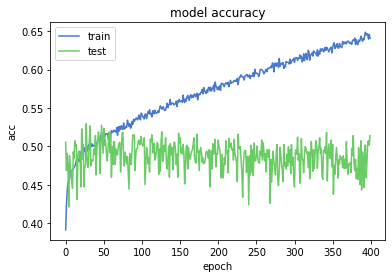

In [251]:
from tensorflow.python.keras.models import load_model 

plt.plot(cnnhistory.history['accuracy'])
plt.plot(cnnhistory.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [252]:
df1 = np.random.rand(len(test)) < 0.4
train_2 = test[df1]
test_2 = test[~df1]

In [253]:
test_2

,wav_file,label,0,1,2,3,4,5,6,7,...,32,33,34,35,36,37,38,39,actor,session
7867,Ses05F_impro01_F000,3,-585.852802,198.867099,-35.402785,25.608204,31.915689,-20.628153,12.542390,7.062307,...,-0.725490,-2.759125,0.132562,0.770999,0.737975,1.642577,-0.123987,0.143570,F,Ses05
7868,Ses05F_impro01_F001,0,-533.893890,188.525680,-12.882806,12.114414,26.861663,-7.700467,8.306076,3.648815,...,-1.353904,-2.393861,-0.037116,1.299204,0.635383,1.620514,2.629586,1.268480,F,Ses05
7871,Ses05F_impro01_F004,0,-459.823822,185.527681,-40.886769,28.305041,37.132338,-23.203142,5.151591,3.610659,...,5.092653,2.399904,3.708929,4.725662,4.652699,5.132569,4.557204,4.173012,F,Ses05
7873,Ses05F_impro01_F006,0,-455.309703,177.457854,-27.271942,6.219689,29.569399,-17.049014,-3.581623,6.416520,...,1.989035,1.970364,3.527211,4.056161,3.406622,3.236684,2.701955,1.629213,F,Ses05
7874,Ses05F_impro01_F007,0,-486.144134,180.223827,-23.857040,5.591753,27.781481,-16.763066,-3.466697,5.502682,...,2.416606,1.979190,2.500062,2.724847,3.021664,3.665444,3.581198,3.523417,F,Ses05
7875,Ses05F_impro01_F008,3,-476.238778,186.939744,-34.736982,14.157448,30.816447,-23.685803,0.009929,5.585601,...,1.988673,1.102847,3.165118,4.094647,5.370751,8.120942,6.835108,3.817647,F,Ses05
7876,Ses05F_impro01_F009,0,-548.998456,173.222571,-18.048247,10.106872,22.354704,-14.788894,6.136228,8.086484,...,4.913514,3.483173,3.690874,4.197776,4.329406,5.085555,4.174868,1.383461,F,Ses05
7877,Ses05F_impro01_F010,0,-508.356199,175.374699,-23.584123,4.688213,20.687035,-13.397882,6.187692,7.625885,...,1.688875,1.733743,2.397435,5.492016,6.558246,4.717554,2.784216,1.103984,F,Ses05
7878,Ses05F_impro01_F011,0,-482.828019,178.049008,-28.243431,6.403959,33.774726,-10.184799,-2.375824,2.740853,...,3.513314,2.490853,2.220517,1.818959,0.072294,-0.768165,0.941708,2.599931,F,Ses05
7879,Ses05F_impro01_F012,0,-429.988752,197.508906,-32.374375,15.600101,32.185388,-19.273362,0.383144,0.478265,...,2.132305,2.644496,3.398131,2.126299,1.437473,2.136495,1.254787,1.926298,F,Ses05


In [254]:
trainlabel=train_2.iloc[:,1:2]
trainfeatures = train_2.iloc[: ,2:-2]
testfeatures = test_2.iloc[:, 2:-2]
testlabel=test_2.iloc[:, 1:2]

In [255]:
X_train = np.array(trainfeatures)
y_train = np.array(trainlabel)
X_test = np.array(testfeatures)
y_test = np.array(testlabel)


In [256]:
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder



lb = LabelEncoder()

y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))
#for cnn
x_traincnn =np.expand_dims(X_train, axis=2)
x_testcnn= np.expand_dims(X_test, axis=2)

C:\Users\ioann\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [257]:
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt ,metrics=['accuracy'])

In [258]:
cnnhistory_2=loaded_model.fit(x_traincnn, y_train, batch_size=16, epochs=400, validation_data=(x_testcnn, y_test))

Train on 439 samples, validate on 594 samples
Epoch 1/400
439/439 [==============================] - ETA: 7s - loss: 0.7922 - accuracy: 0.68 - ETA: 0s - loss: 1.2079 - accuracy: 0.52 - ETA: 0s - loss: 1.2364 - accuracy: 0.48 - ETA: 0s - loss: 1.2505 - accuracy: 0.49 - 1s 2ms/step - loss: 1.2555 - accuracy: 0.4852 - val_loss: 1.1500 - val_accuracy: 0.5000
Epoch 2/400
439/439 [==============================] - ETA: 0s - loss: 1.1961 - accuracy: 0.25 - ETA: 0s - loss: 1.1947 - accuracy: 0.45 - ETA: 0s - loss: 1.1616 - accuracy: 0.48 - ETA: 0s - loss: 1.1546 - accuracy: 0.50 - 0s 684us/step - loss: 1.1755 - accuracy: 0.4875 - val_loss: 1.1575 - val_accuracy: 0.5051
Epoch 3/400
439/439 [==============================] - ETA: 0s - loss: 1.4146 - accuracy: 0.43 - ETA: 0s - loss: 1.1267 - accuracy: 0.50 - ETA: 0s - loss: 1.1362 - accuracy: 0.47 - ETA: 0s - loss: 1.1218 - accuracy: 0.49 - 0s 659us/step - loss: 1.1277 - accuracy: 0.4943 - val_loss: 1.1458 - val_accuracy: 0.5101
Epoch 4/400
439/4

Epoch 27/400
439/439 [==============================] - ETA: 0s - loss: 0.9243 - accuracy: 0.62 - ETA: 0s - loss: 0.9343 - accuracy: 0.59 - ETA: 0s - loss: 0.8933 - accuracy: 0.64 - ETA: 0s - loss: 0.8925 - accuracy: 0.63 - 0s 672us/step - loss: 0.8823 - accuracy: 0.6378 - val_loss: 1.0693 - val_accuracy: 0.5488
Epoch 28/400
439/439 [==============================] - ETA: 0s - loss: 0.8642 - accuracy: 0.56 - ETA: 0s - loss: 0.8444 - accuracy: 0.65 - ETA: 0s - loss: 0.8661 - accuracy: 0.65 - ETA: 0s - loss: 0.8433 - accuracy: 0.66 - 0s 663us/step - loss: 0.8400 - accuracy: 0.6606 - val_loss: 1.0725 - val_accuracy: 0.5471
Epoch 29/400
439/439 [==============================] - ETA: 0s - loss: 0.8471 - accuracy: 0.75 - ETA: 0s - loss: 0.8203 - accuracy: 0.66 - ETA: 0s - loss: 0.8883 - accuracy: 0.62 - ETA: 0s - loss: 0.8517 - accuracy: 0.63 - 0s 693us/step - loss: 0.8606 - accuracy: 0.6355 - val_loss: 1.0672 - val_accuracy: 0.5471
Epoch 30/400
439/439 [==============================] - ET

439/439 [==============================] - ETA: 0s - loss: 0.9243 - accuracy: 0.50 - ETA: 0s - loss: 0.7196 - accuracy: 0.70 - ETA: 0s - loss: 0.7258 - accuracy: 0.71 - ETA: 0s - loss: 0.7048 - accuracy: 0.72 - 0s 661us/step - loss: 0.7162 - accuracy: 0.7198 - val_loss: 1.0807 - val_accuracy: 0.5269
Epoch 80/400
439/439 [==============================] - ETA: 0s - loss: 0.6410 - accuracy: 0.62 - ETA: 0s - loss: 0.6841 - accuracy: 0.68 - ETA: 0s - loss: 0.6925 - accuracy: 0.70 - ETA: 0s - loss: 0.6951 - accuracy: 0.70 - 0s 666us/step - loss: 0.7013 - accuracy: 0.7107 - val_loss: 1.1322 - val_accuracy: 0.5286
Epoch 81/400
439/439 [==============================] - ETA: 0s - loss: 0.5639 - accuracy: 0.81 - ETA: 0s - loss: 0.6910 - accuracy: 0.75 - ETA: 0s - loss: 0.7237 - accuracy: 0.74 - ETA: 0s - loss: 0.7033 - accuracy: 0.75 - 0s 661us/step - loss: 0.7021 - accuracy: 0.7494 - val_loss: 1.0916 - val_accuracy: 0.5539
Epoch 82/400
439/439 [==============================] - ETA: 0s - loss:

439/439 [==============================] - ETA: 0s - loss: 0.4514 - accuracy: 0.87 - ETA: 0s - loss: 0.6224 - accuracy: 0.75 - ETA: 0s - loss: 0.6476 - accuracy: 0.75 - ETA: 0s - loss: 0.6081 - accuracy: 0.77 - 0s 677us/step - loss: 0.6031 - accuracy: 0.7722 - val_loss: 1.1062 - val_accuracy: 0.5505
Epoch 132/400
439/439 [==============================] - ETA: 0s - loss: 0.5696 - accuracy: 0.81 - ETA: 0s - loss: 0.5828 - accuracy: 0.78 - ETA: 0s - loss: 0.5860 - accuracy: 0.77 - ETA: 0s - loss: 0.6067 - accuracy: 0.77 - 0s 668us/step - loss: 0.6073 - accuracy: 0.7722 - val_loss: 1.1061 - val_accuracy: 0.5505
Epoch 133/400
439/439 [==============================] - ETA: 0s - loss: 0.4053 - accuracy: 0.81 - ETA: 0s - loss: 0.6598 - accuracy: 0.71 - ETA: 0s - loss: 0.6075 - accuracy: 0.73 - ETA: 0s - loss: 0.6024 - accuracy: 0.74 - 0s 661us/step - loss: 0.5964 - accuracy: 0.7517 - val_loss: 1.1189 - val_accuracy: 0.5589
Epoch 134/400
439/439 [==============================] - ETA: 0s - lo

439/439 [==============================] - ETA: 0s - loss: 0.6440 - accuracy: 0.75 - ETA: 0s - loss: 0.5860 - accuracy: 0.74 - ETA: 0s - loss: 0.5323 - accuracy: 0.78 - ETA: 0s - loss: 0.5160 - accuracy: 0.79 - 0s 679us/step - loss: 0.5172 - accuracy: 0.7995 - val_loss: 1.1245 - val_accuracy: 0.5556
Epoch 184/400
439/439 [==============================] - ETA: 0s - loss: 0.4607 - accuracy: 0.68 - ETA: 0s - loss: 0.5013 - accuracy: 0.79 - ETA: 0s - loss: 0.5210 - accuracy: 0.79 - ETA: 0s - loss: 0.5442 - accuracy: 0.78 - 0s 684us/step - loss: 0.5490 - accuracy: 0.7813 - val_loss: 1.1373 - val_accuracy: 0.5253
Epoch 185/400
439/439 [==============================] - ETA: 0s - loss: 0.5260 - accuracy: 0.75 - ETA: 0s - loss: 0.5172 - accuracy: 0.80 - ETA: 0s - loss: 0.5073 - accuracy: 0.80 - ETA: 0s - loss: 0.5144 - accuracy: 0.79 - 0s 688us/step - loss: 0.4997 - accuracy: 0.8109 - val_loss: 1.1407 - val_accuracy: 0.5640
Epoch 186/400
439/439 [==============================] - ETA: 0s - lo

439/439 [==============================] - ETA: 0s - loss: 0.6952 - accuracy: 0.81 - ETA: 0s - loss: 0.4644 - accuracy: 0.84 - ETA: 0s - loss: 0.4528 - accuracy: 0.84 - ETA: 0s - loss: 0.4649 - accuracy: 0.83 - 0s 702us/step - loss: 0.4774 - accuracy: 0.8223 - val_loss: 1.1713 - val_accuracy: 0.5455
Epoch 236/400
439/439 [==============================] - ETA: 0s - loss: 0.3920 - accuracy: 0.87 - ETA: 0s - loss: 0.4276 - accuracy: 0.87 - ETA: 0s - loss: 0.4533 - accuracy: 0.84 - ETA: 0s - loss: 0.4833 - accuracy: 0.83 - 0s 680us/step - loss: 0.4668 - accuracy: 0.8383 - val_loss: 1.1758 - val_accuracy: 0.5387
Epoch 237/400
439/439 [==============================] - ETA: 0s - loss: 0.5085 - accuracy: 0.81 - ETA: 0s - loss: 0.4402 - accuracy: 0.86 - ETA: 0s - loss: 0.4582 - accuracy: 0.83 - ETA: 0s - loss: 0.4686 - accuracy: 0.83 - 0s 684us/step - loss: 0.4599 - accuracy: 0.8383 - val_loss: 1.1864 - val_accuracy: 0.5572
Epoch 238/400
439/439 [==============================] - ETA: 0s - lo

439/439 [==============================] - ETA: 0s - loss: 0.3045 - accuracy: 1.00 - ETA: 0s - loss: 0.3786 - accuracy: 0.89 - ETA: 0s - loss: 0.3825 - accuracy: 0.88 - ETA: 0s - loss: 0.3961 - accuracy: 0.86 - 0s 743us/step - loss: 0.4146 - accuracy: 0.8633 - val_loss: 1.2159 - val_accuracy: 0.5269
Epoch 288/400
439/439 [==============================] - ETA: 0s - loss: 0.4957 - accuracy: 0.81 - ETA: 0s - loss: 0.4826 - accuracy: 0.81 - ETA: 0s - loss: 0.4667 - accuracy: 0.83 - ETA: 0s - loss: 0.4372 - accuracy: 0.84 - 0s 700us/step - loss: 0.4330 - accuracy: 0.8474 - val_loss: 1.2043 - val_accuracy: 0.5337
Epoch 289/400
439/439 [==============================] - ETA: 0s - loss: 0.4980 - accuracy: 0.75 - ETA: 0s - loss: 0.4428 - accuracy: 0.84 - ETA: 0s - loss: 0.4075 - accuracy: 0.86 - ETA: 0s - loss: 0.4150 - accuracy: 0.85 - 0s 700us/step - loss: 0.4128 - accuracy: 0.8519 - val_loss: 1.1883 - val_accuracy: 0.5488
Epoch 290/400
439/439 [==============================] - ETA: 0s - lo

439/439 [==============================] - ETA: 0s - loss: 0.3797 - accuracy: 0.81 - ETA: 0s - loss: 0.3792 - accuracy: 0.84 - ETA: 0s - loss: 0.3666 - accuracy: 0.86 - ETA: 0s - loss: 0.3627 - accuracy: 0.87 - 0s 722us/step - loss: 0.3602 - accuracy: 0.8793 - val_loss: 1.2075 - val_accuracy: 0.5539
Epoch 340/400
439/439 [==============================] - ETA: 0s - loss: 0.4315 - accuracy: 0.81 - ETA: 0s - loss: 0.3948 - accuracy: 0.87 - ETA: 0s - loss: 0.3881 - accuracy: 0.87 - ETA: 0s - loss: 0.3702 - accuracy: 0.88 - 0s 720us/step - loss: 0.3855 - accuracy: 0.8702 - val_loss: 1.2041 - val_accuracy: 0.5370
Epoch 341/400
439/439 [==============================] - ETA: 0s - loss: 0.3946 - accuracy: 0.87 - ETA: 0s - loss: 0.3616 - accuracy: 0.90 - ETA: 0s - loss: 0.3696 - accuracy: 0.89 - ETA: 0s - loss: 0.3477 - accuracy: 0.91 - 0s 718us/step - loss: 0.3495 - accuracy: 0.9134 - val_loss: 1.2443 - val_accuracy: 0.5337
Epoch 342/400
439/439 [==============================] - ETA: 0s - lo

439/439 [==============================] - ETA: 0s - loss: 0.4279 - accuracy: 0.81 - ETA: 0s - loss: 0.2802 - accuracy: 0.92 - ETA: 0s - loss: 0.3117 - accuracy: 0.90 - ETA: 0s - loss: 0.3264 - accuracy: 0.89 - 0s 716us/step - loss: 0.3245 - accuracy: 0.8975 - val_loss: 1.2662 - val_accuracy: 0.5354
Epoch 392/400
439/439 [==============================] - ETA: 0s - loss: 0.4882 - accuracy: 0.81 - ETA: 0s - loss: 0.3483 - accuracy: 0.87 - ETA: 0s - loss: 0.3341 - accuracy: 0.88 - ETA: 0s - loss: 0.3340 - accuracy: 0.89 - 0s 719us/step - loss: 0.3379 - accuracy: 0.8975 - val_loss: 1.2602 - val_accuracy: 0.5370
Epoch 393/400
439/439 [==============================] - ETA: 0s - loss: 0.2281 - accuracy: 0.93 - ETA: 0s - loss: 0.3149 - accuracy: 0.91 - ETA: 0s - loss: 0.3115 - accuracy: 0.91 - ETA: 0s - loss: 0.3260 - accuracy: 0.89 - 0s 712us/step - loss: 0.3332 - accuracy: 0.8952 - val_loss: 1.2633 - val_accuracy: 0.5387
Epoch 394/400
439/439 [==============================] - ETA: 0s - lo

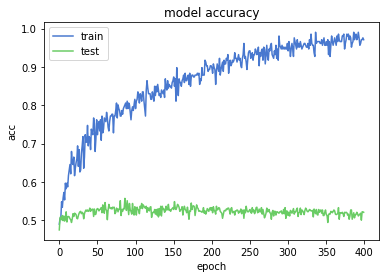

In [233]:
plt.plot(cnnhistory_2.history['accuracy'])
plt.plot(cnnhistory_2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [234]:
#save model
loaded_model_name = 'aug_all_1_Model_ravdess.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
loaded_model_path = os.path.join(save_dir, loaded_model_name)
loaded_model.save(loaded_model_path)
print('Saved trained model at %s ' % loaded_model_path)

Saved trained model at C:\Users\ioann\saved_models\aug_all_1_Model_ravdess.h5 


In [235]:
import json
loaded_model_json = loaded_model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(loaded_model_json)

In [236]:
#load
# loading json and creating model
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json_2 = json_file.read()
json_file.close()
loaded_model_2 = model_from_json(loaded_model_json_2)
# load weights into new model
loaded_model_2.load_weights("/Users/ioann/saved_models/aug_all_1_Model_ravdess.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model_2.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model_2.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model_2.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 52.12%
